<a href="https://colab.research.google.com/github/ksushrut/CoinClassifier/blob/main/Adv_CV_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Coin Classification

## Guidelines
1) Please import packages in the import section only.

2) Use sensible variable names. If possible try to describe the use of the variables in the variable description section.

3) Github commits and branches?

4) set device to gpu. No cpu!


# PIP Install statements

# Import packages here

In [1]:
# write only import statements here
import torch
import os
import cv2
import matplotlib.pyplot as plt
from google.colab import drive
import random
from PIL import Image, ImageEnhance
from tqdm import tqdm
import numpy as np
import pandas as pd
import seaborn as sns


In [3]:
if torch.cuda.is_available():
    device = torch.device("cuda")
    print(f"GPU is available: {torch.cuda.get_device_name(0)}")
else:
    device = torch.device("cpu")

GPU is available: Tesla T4


# Variable Description:

##### Describe the essential variables here. preferable datatype and use. This is to make sure we understand the code we are using
eg: Xtrain: tensor, stores images for training

In [2]:
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
folder_path = "/content/drive/My Drive/CoinImages"

# Preprocessed images output path
output_path = folder_path + "/Latest_Four_Countries_Preprocessed_Images"
os.makedirs(output_path, exist_ok=True)

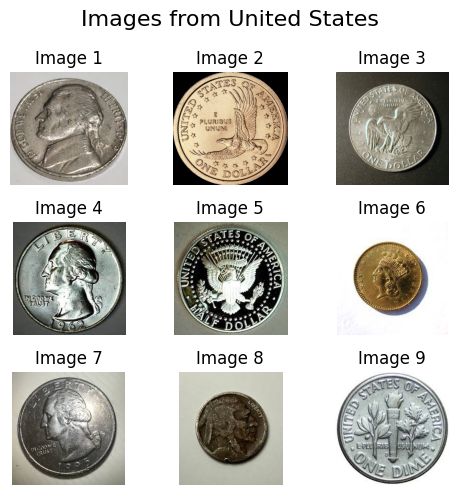

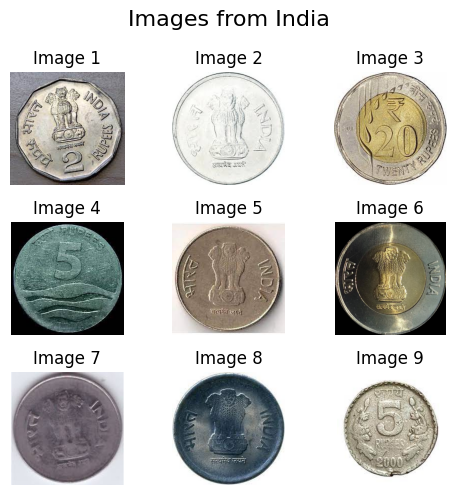

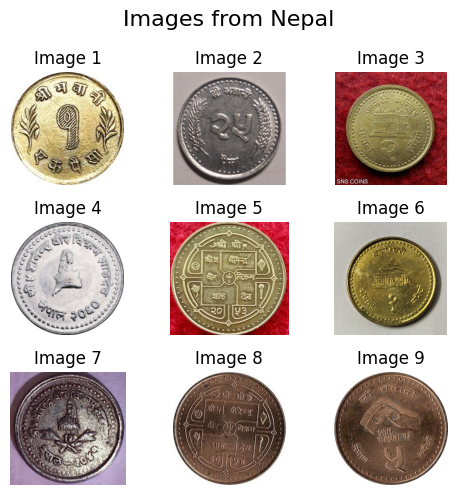

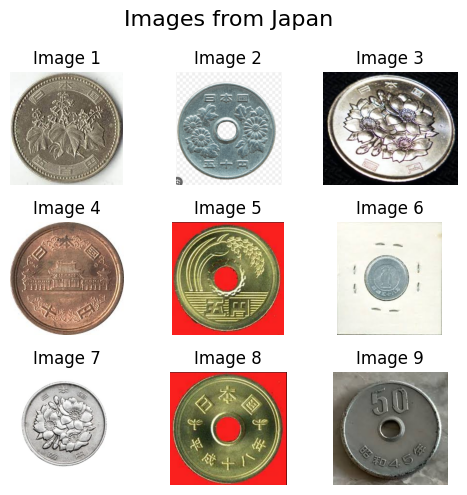

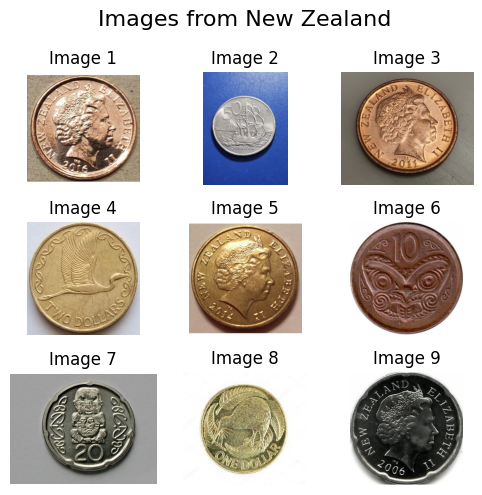

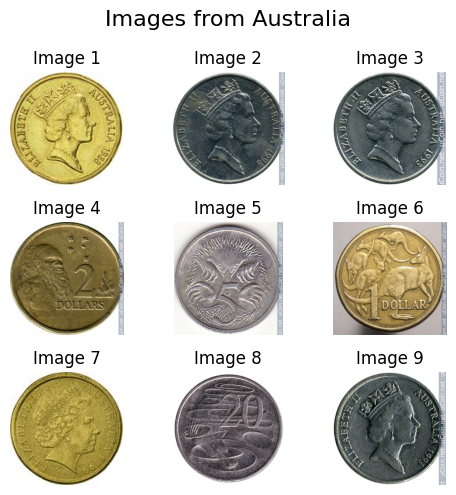

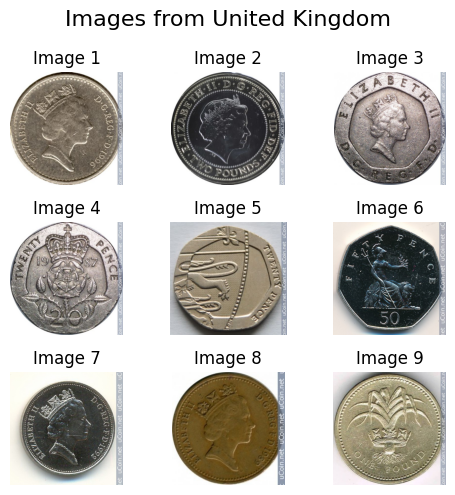

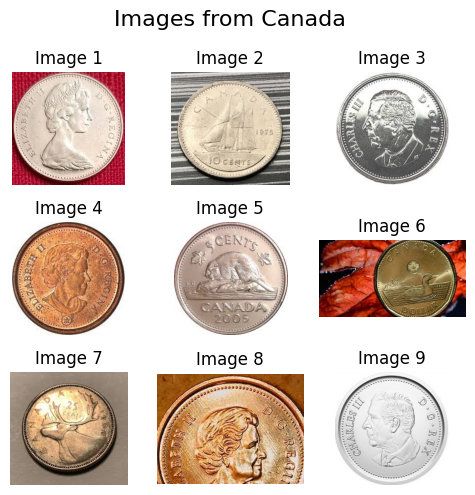

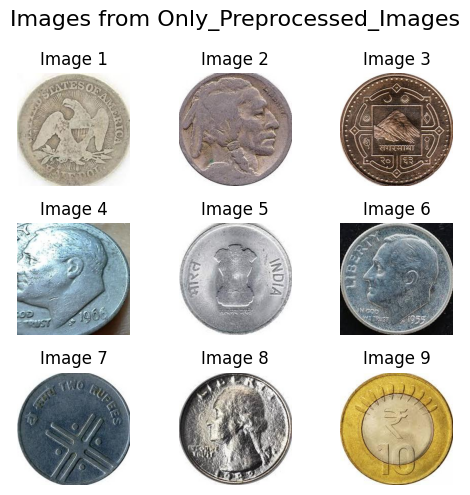

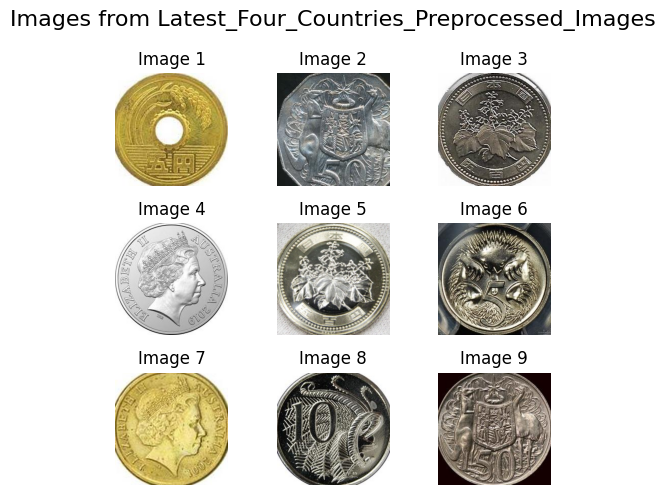

In [4]:
#Prerequisite for this cell: Right click on CoinImages in drive. Organize and then add short cut to My Drive
image_files = [f for f in os.listdir(folder_path) if f.endswith(('.jpg', '.png', '.jpeg'))]

country_folders = [f for f in os.listdir(folder_path) if os.path.isdir(os.path.join(folder_path, f))]

# Loop through each country folder
for country in country_folders:
    country_path = os.path.join(folder_path, country)

    # Collect all images from this country's subfolders
    image_files = []
    for root, _, files in os.walk(country_path):
        for file in files:
            if file.lower().endswith((".jpg", ".jpeg", ".png")):
                image_files.append(os.path.join(root, file))

    # If no images found, skip this country
    if len(image_files) == 0:
        print(f"No images found for {country}")
        continue

    # Select 9 random images (or fewer if less than 9 exist)
    random_images = random.sample(image_files, min(9, len(image_files)))

    # Display images in a 3x3 grid
    fig, axes = plt.subplots(3, 3, figsize=(5, 5))
    fig.suptitle(f"Images from {country}", fontsize=16)

    for i, ax in enumerate(axes.flat):
        if i < len(random_images):
            img_path = random_images[i]
            img = cv2.imread(img_path)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            ax.imshow(img)
            ax.set_title(f"Image {i+1}")
        ax.axis("off")  # Hide axes if no image

    plt.tight_layout()
    plt.show()

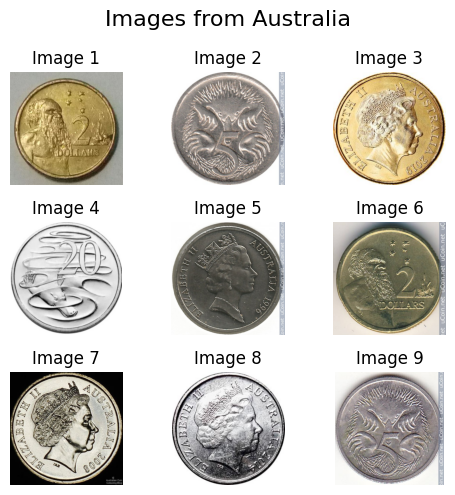

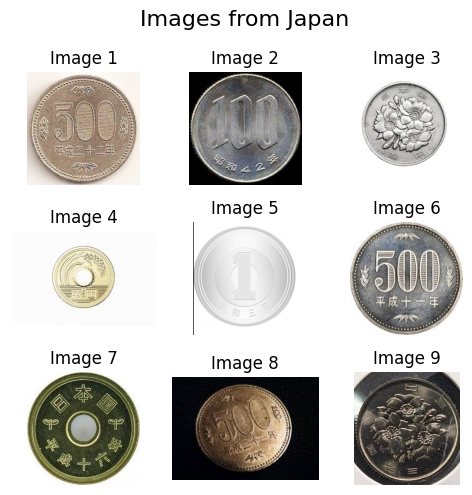

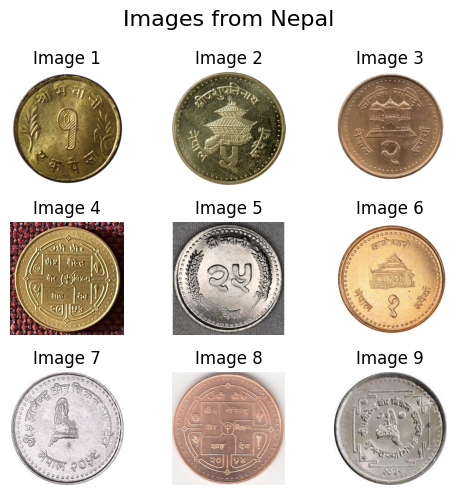

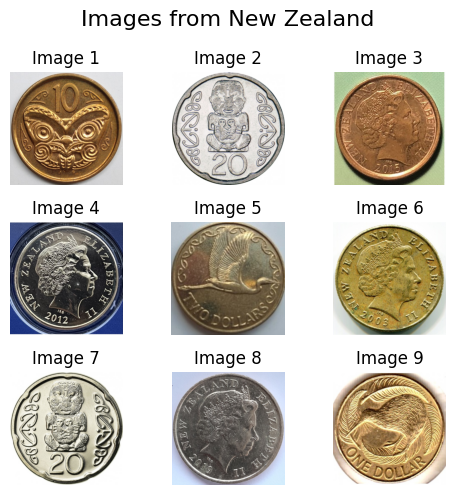

In [5]:
valid_country_folders = ['Australia', 'Japan', 'Nepal', 'New Zealand']

# Loop through only the selected country folders
for country in valid_country_folders:
    country_path = os.path.join(folder_path, country)

    # Collect all images from this country's subfolders
    image_files = []
    for root, _, files in os.walk(country_path):
        for file in files:
            if file.lower().endswith((".jpg", ".jpeg", ".png")):
                image_files.append(os.path.join(root, file))

    if len(image_files) == 0:
        print(f"No images found for {country}")
        continue

    # Pick 9 random images
    random_images = random.sample(image_files, min(9, len(image_files)))

    # Plot in a 3x3 grid
    fig, axes = plt.subplots(3, 3, figsize=(5, 5))
    fig.suptitle(f"Images from {country}", fontsize=16)

    for i, ax in enumerate(axes.flat):
        if i < len(random_images):
            img = cv2.imread(random_images[i])
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            ax.imshow(img)
            ax.set_title(f"Image {i+1}")
        ax.axis("off")

    plt.tight_layout()
    plt.show()

# **Data Preprocessing** DRAFT VERSION WILL EDIT LATER

This step will include image preprocessing methodoligies so as to increase the quality of the dataset before the training process. Techniques such as Image size standardization, normalization and augmentation will be used to:
1. Create additional images to bring the image per class count to 50.
2. Bring about variation and diversity in the original dataset, without permanently altering the dataset itself.

Reasons for choosing the steps:
1. Greyscale conversion transforms a three-channel image into a single channel, which helps reduce computational complexity, lower memory usage, and enhance processing speed.
2. Median blur smoothens out the noise from the coin images, while preserving the edge, which will make it easier to apply Hough Circle detection.
3. Hough Circle detection helps to identify and isolate circular regions of interest, such as coins, from the background by detecting prominent circular shapes within an image.

In [6]:
def image_preprocessor(img_path, img_size=(224, 224)):
    """
    Load, crop coin using Hough Circle detection, resize to standard size.
    """
    image = cv2.imread(img_path)
    if image is None:
        return None

    gray_img = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    median_img = cv2.medianBlur(gray_img, 5)

    circles = cv2.HoughCircles(
        median_img,
        cv2.HOUGH_GRADIENT,
        dp=1.2,
        minDist=100,
        param1=50,
        param2=30,
        minRadius=50,
        maxRadius=300
    )

    if circles is not None:
        circles = np.around(circles[0, :]).astype("int")
        x, y, r = circles[0]
        x1, y1 = max(x - r, 0), max(y - r, 0)
        x2, y2 = min(x + r, image.shape[1]), min(y + r, image.shape[0])
        coin_image = image[y1:y2, x1:x2]
    else:
        print("No coin detected in:", img_path)
        coin_image = image  # Fallback: use full image

    coin_image = cv2.cvtColor(coin_image, cv2.COLOR_BGR2RGB)
    coin_image = Image.fromarray(coin_image)
    final_image = coin_image.resize(img_size, Image.Resampling.LANCZOS)
    return final_image


In [7]:
def save_preprocessed_image(input_path, output_path, output_size=(224, 224)):
    """
    Run preprocessing on image and save it to the mirrored output path.
    """
    coin_img = image_preprocessor(input_path, output_size)
    if coin_img is not None:
        os.makedirs(os.path.dirname(output_path), exist_ok=True)
        coin_img.save(output_path)
        print("Saved:", output_path)
    else:
        print("Failed:", input_path)


In [8]:
# Get country folders
valid_country_folders = [ 'Japan', 'Nepal', 'New Zealand']

# Loop through each country and their subfolders
for country in valid_country_folders:
    country_path = os.path.join(folder_path, country)

    # Process all images inside country's denomination folders
    for root, _, files in os.walk(country_path):
        for file in tqdm(files, desc=f"Processing {country}"):
            if file.lower().endswith((".jpg", ".jpeg", ".png")):
                input_path = os.path.join(root, file)

                # Create mirrored output path
                relative_path = os.path.relpath(input_path, folder_path)
                output_folder = os.path.join(output_path, relative_path)

                save_preprocessed_image(input_path, output_folder)

print("Dataset preprocessing completed for all countries.")


Processing Japan: 0it [00:00, ?it/s]
Processing Japan:   2%|▏         | 1/50 [00:01<00:54,  1.11s/it]

Saved: /content/drive/My Drive/CoinImages/Latest_Four_Countries_Preprocessed_Images/Japan/500 Yen/1h.jpeg


Processing Japan:   4%|▍         | 2/50 [00:04<01:45,  2.19s/it]

Saved: /content/drive/My Drive/CoinImages/Latest_Four_Countries_Preprocessed_Images/Japan/500 Yen/2h.png


Processing Japan:   6%|▌         | 3/50 [00:04<01:15,  1.60s/it]

Saved: /content/drive/My Drive/CoinImages/Latest_Four_Countries_Preprocessed_Images/Japan/500 Yen/3h.jpeg


Processing Japan:   8%|▊         | 4/50 [00:06<01:08,  1.49s/it]

Saved: /content/drive/My Drive/CoinImages/Latest_Four_Countries_Preprocessed_Images/Japan/500 Yen/4h.png


Processing Japan:  10%|█         | 5/50 [00:07<01:03,  1.40s/it]

Saved: /content/drive/My Drive/CoinImages/Latest_Four_Countries_Preprocessed_Images/Japan/500 Yen/5h.jpeg


Processing Japan:  12%|█▏        | 6/50 [00:09<01:15,  1.71s/it]

Saved: /content/drive/My Drive/CoinImages/Latest_Four_Countries_Preprocessed_Images/Japan/500 Yen/6h.png


Processing Japan:  14%|█▍        | 7/50 [00:12<01:33,  2.18s/it]

Saved: /content/drive/My Drive/CoinImages/Latest_Four_Countries_Preprocessed_Images/Japan/500 Yen/7h.png


Processing Japan:  16%|█▌        | 8/50 [00:13<01:14,  1.77s/it]

Saved: /content/drive/My Drive/CoinImages/Latest_Four_Countries_Preprocessed_Images/Japan/500 Yen/8h.jpeg


Processing Japan:  18%|█▊        | 9/50 [00:16<01:26,  2.10s/it]

Saved: /content/drive/My Drive/CoinImages/Latest_Four_Countries_Preprocessed_Images/Japan/500 Yen/9h.png


Processing Japan:  20%|██        | 10/50 [00:18<01:15,  1.90s/it]

Saved: /content/drive/My Drive/CoinImages/Latest_Four_Countries_Preprocessed_Images/Japan/500 Yen/10h.png


Processing Japan:  22%|██▏       | 11/50 [00:18<01:01,  1.57s/it]

Saved: /content/drive/My Drive/CoinImages/Latest_Four_Countries_Preprocessed_Images/Japan/500 Yen/11h.jpeg


Processing Japan:  24%|██▍       | 12/50 [00:19<00:53,  1.40s/it]

Saved: /content/drive/My Drive/CoinImages/Latest_Four_Countries_Preprocessed_Images/Japan/500 Yen/12h.jpeg


Processing Japan:  26%|██▌       | 13/50 [00:21<00:48,  1.31s/it]

Saved: /content/drive/My Drive/CoinImages/Latest_Four_Countries_Preprocessed_Images/Japan/500 Yen/13h.jpeg


Processing Japan:  28%|██▊       | 14/50 [00:22<00:42,  1.19s/it]

Saved: /content/drive/My Drive/CoinImages/Latest_Four_Countries_Preprocessed_Images/Japan/500 Yen/1t.jpeg


Processing Japan:  30%|███       | 15/50 [00:22<00:35,  1.00s/it]

Saved: /content/drive/My Drive/CoinImages/Latest_Four_Countries_Preprocessed_Images/Japan/500 Yen/2t.jpeg


Processing Japan:  32%|███▏      | 16/50 [00:23<00:29,  1.14it/s]

Saved: /content/drive/My Drive/CoinImages/Latest_Four_Countries_Preprocessed_Images/Japan/500 Yen/3t.jpeg


Processing Japan:  34%|███▍      | 17/50 [00:24<00:28,  1.15it/s]

Saved: /content/drive/My Drive/CoinImages/Latest_Four_Countries_Preprocessed_Images/Japan/500 Yen/4t.jpeg


Processing Japan:  36%|███▌      | 18/50 [00:24<00:24,  1.29it/s]

Saved: /content/drive/My Drive/CoinImages/Latest_Four_Countries_Preprocessed_Images/Japan/500 Yen/5t.jpeg


Processing Japan:  38%|███▊      | 19/50 [00:24<00:19,  1.57it/s]

Saved: /content/drive/My Drive/CoinImages/Latest_Four_Countries_Preprocessed_Images/Japan/500 Yen/6t.jpeg


Processing Japan:  40%|████      | 20/50 [00:25<00:21,  1.39it/s]

Saved: /content/drive/My Drive/CoinImages/Latest_Four_Countries_Preprocessed_Images/Japan/500 Yen/7t.jpeg


Processing Japan:  42%|████▏     | 21/50 [00:26<00:19,  1.51it/s]

Saved: /content/drive/My Drive/CoinImages/Latest_Four_Countries_Preprocessed_Images/Japan/500 Yen/8t.jpeg


Processing Japan:  44%|████▍     | 22/50 [00:27<00:19,  1.42it/s]

Saved: /content/drive/My Drive/CoinImages/Latest_Four_Countries_Preprocessed_Images/Japan/500 Yen/9t.jpeg


Processing Japan:  46%|████▌     | 23/50 [00:27<00:19,  1.40it/s]

Saved: /content/drive/My Drive/CoinImages/Latest_Four_Countries_Preprocessed_Images/Japan/500 Yen/10t.jpeg


Processing Japan:  48%|████▊     | 24/50 [00:28<00:17,  1.46it/s]

Saved: /content/drive/My Drive/CoinImages/Latest_Four_Countries_Preprocessed_Images/Japan/500 Yen/11t.jpeg


Processing Japan:  50%|█████     | 25/50 [00:28<00:15,  1.60it/s]

Saved: /content/drive/My Drive/CoinImages/Latest_Four_Countries_Preprocessed_Images/Japan/500 Yen/12t.jpeg


Processing Japan:  52%|█████▏    | 26/50 [00:29<00:14,  1.64it/s]

Saved: /content/drive/My Drive/CoinImages/Latest_Four_Countries_Preprocessed_Images/Japan/500 Yen/13t.jpeg


Processing Japan:  54%|█████▍    | 27/50 [00:31<00:22,  1.03it/s]

Saved: /content/drive/My Drive/CoinImages/Latest_Four_Countries_Preprocessed_Images/Japan/500 Yen/14h.jpg


Processing Japan:  56%|█████▌    | 28/50 [00:33<00:30,  1.40s/it]

Saved: /content/drive/My Drive/CoinImages/Latest_Four_Countries_Preprocessed_Images/Japan/500 Yen/14t.jpg


Processing Japan:  58%|█████▊    | 29/50 [00:45<01:36,  4.59s/it]

Saved: /content/drive/My Drive/CoinImages/Latest_Four_Countries_Preprocessed_Images/Japan/500 Yen/15h.jpg


Processing Japan:  60%|██████    | 30/50 [00:58<02:22,  7.11s/it]

Saved: /content/drive/My Drive/CoinImages/Latest_Four_Countries_Preprocessed_Images/Japan/500 Yen/15t.jpg


Processing Japan:  62%|██████▏   | 31/50 [01:00<01:42,  5.42s/it]

Saved: /content/drive/My Drive/CoinImages/Latest_Four_Countries_Preprocessed_Images/Japan/500 Yen/16h.jpg


Processing Japan:  64%|██████▍   | 32/50 [01:02<01:20,  4.50s/it]

Saved: /content/drive/My Drive/CoinImages/Latest_Four_Countries_Preprocessed_Images/Japan/500 Yen/16t.jpg


Processing Japan:  66%|██████▌   | 33/50 [02:05<06:16, 22.12s/it]

Saved: /content/drive/My Drive/CoinImages/Latest_Four_Countries_Preprocessed_Images/Japan/500 Yen/17h.jpg


Processing Japan:  68%|██████▊   | 34/50 [03:08<09:07, 34.24s/it]

Saved: /content/drive/My Drive/CoinImages/Latest_Four_Countries_Preprocessed_Images/Japan/500 Yen/17t.jpg


Processing Japan:  70%|███████   | 35/50 [03:18<06:43, 26.90s/it]

Saved: /content/drive/My Drive/CoinImages/Latest_Four_Countries_Preprocessed_Images/Japan/500 Yen/18h.jpg


Processing Japan:  72%|███████▏  | 36/50 [03:27<05:02, 21.58s/it]

Saved: /content/drive/My Drive/CoinImages/Latest_Four_Countries_Preprocessed_Images/Japan/500 Yen/18t.jpg


Processing Japan:  74%|███████▍  | 37/50 [03:34<03:45, 17.33s/it]

Saved: /content/drive/My Drive/CoinImages/Latest_Four_Countries_Preprocessed_Images/Japan/500 Yen/19h.jpg


Processing Japan:  76%|███████▌  | 38/50 [03:40<02:45, 13.79s/it]

Saved: /content/drive/My Drive/CoinImages/Latest_Four_Countries_Preprocessed_Images/Japan/500 Yen/19t.jpg


Processing Japan:  78%|███████▊  | 39/50 [03:42<01:52, 10.19s/it]

Saved: /content/drive/My Drive/CoinImages/Latest_Four_Countries_Preprocessed_Images/Japan/500 Yen/20h.jpg


Processing Japan:  80%|████████  | 40/50 [03:44<01:17,  7.75s/it]

Saved: /content/drive/My Drive/CoinImages/Latest_Four_Countries_Preprocessed_Images/Japan/500 Yen/20t.jpg


Processing Japan:  82%|████████▏ | 41/50 [03:48<01:00,  6.77s/it]

Saved: /content/drive/My Drive/CoinImages/Latest_Four_Countries_Preprocessed_Images/Japan/500 Yen/21h.jpg


Processing Japan:  84%|████████▍ | 42/50 [03:49<00:39,  4.89s/it]

Saved: /content/drive/My Drive/CoinImages/Latest_Four_Countries_Preprocessed_Images/Japan/500 Yen/22h.jpeg


Processing Japan:  86%|████████▌ | 43/50 [03:49<00:25,  3.66s/it]

Saved: /content/drive/My Drive/CoinImages/Latest_Four_Countries_Preprocessed_Images/Japan/500 Yen/23h.jpeg


Processing Japan:  88%|████████▊ | 44/50 [03:50<00:16,  2.79s/it]

Saved: /content/drive/My Drive/CoinImages/Latest_Four_Countries_Preprocessed_Images/Japan/500 Yen/24h.jpeg


Processing Japan:  90%|█████████ | 45/50 [03:51<00:11,  2.22s/it]

Saved: /content/drive/My Drive/CoinImages/Latest_Four_Countries_Preprocessed_Images/Japan/500 Yen/25h.jpeg


Processing Japan:  92%|█████████▏| 46/50 [03:52<00:07,  1.89s/it]

Saved: /content/drive/My Drive/CoinImages/Latest_Four_Countries_Preprocessed_Images/Japan/500 Yen/21t.jpeg


Processing Japan:  94%|█████████▍| 47/50 [03:53<00:04,  1.59s/it]

Saved: /content/drive/My Drive/CoinImages/Latest_Four_Countries_Preprocessed_Images/Japan/500 Yen/22t.jpg


Processing Japan:  96%|█████████▌| 48/50 [03:54<00:02,  1.26s/it]

Saved: /content/drive/My Drive/CoinImages/Latest_Four_Countries_Preprocessed_Images/Japan/500 Yen/23t.jpeg


Processing Japan:  98%|█████████▊| 49/50 [03:54<00:01,  1.12s/it]

Saved: /content/drive/My Drive/CoinImages/Latest_Four_Countries_Preprocessed_Images/Japan/500 Yen/24t.jpeg


Processing Japan: 100%|██████████| 50/50 [03:55<00:00,  4.71s/it]


Saved: /content/drive/My Drive/CoinImages/Latest_Four_Countries_Preprocessed_Images/Japan/500 Yen/25t.jpeg


Processing Japan:   2%|▏         | 1/50 [00:01<00:50,  1.03s/it]

Saved: /content/drive/My Drive/CoinImages/Latest_Four_Countries_Preprocessed_Images/Japan/5 Yen/1h.jpeg


Processing Japan:   4%|▍         | 2/50 [00:01<00:37,  1.26it/s]

Saved: /content/drive/My Drive/CoinImages/Latest_Four_Countries_Preprocessed_Images/Japan/5 Yen/2h.png


Processing Japan:   6%|▌         | 3/50 [00:02<00:38,  1.22it/s]

Saved: /content/drive/My Drive/CoinImages/Latest_Four_Countries_Preprocessed_Images/Japan/5 Yen/3h.jpg


Processing Japan:   8%|▊         | 4/50 [00:04<00:54,  1.19s/it]

Saved: /content/drive/My Drive/CoinImages/Latest_Four_Countries_Preprocessed_Images/Japan/5 Yen/4h.png


Processing Japan:  10%|█         | 5/50 [00:05<00:46,  1.04s/it]

Saved: /content/drive/My Drive/CoinImages/Latest_Four_Countries_Preprocessed_Images/Japan/5 Yen/5h.jpeg


Processing Japan:  12%|█▏        | 6/50 [00:05<00:40,  1.10it/s]

Saved: /content/drive/My Drive/CoinImages/Latest_Four_Countries_Preprocessed_Images/Japan/5 Yen/6h.jpeg


Processing Japan:  14%|█▍        | 7/50 [00:06<00:34,  1.24it/s]

Saved: /content/drive/My Drive/CoinImages/Latest_Four_Countries_Preprocessed_Images/Japan/5 Yen/7h.jpeg


Processing Japan:  16%|█▌        | 8/50 [00:07<00:33,  1.24it/s]

Saved: /content/drive/My Drive/CoinImages/Latest_Four_Countries_Preprocessed_Images/Japan/5 Yen/8h.jpeg


Processing Japan:  18%|█▊        | 9/50 [00:07<00:30,  1.36it/s]

Saved: /content/drive/My Drive/CoinImages/Latest_Four_Countries_Preprocessed_Images/Japan/5 Yen/9h.jpeg


Processing Japan:  20%|██        | 10/50 [00:09<00:39,  1.02it/s]

Saved: /content/drive/My Drive/CoinImages/Latest_Four_Countries_Preprocessed_Images/Japan/5 Yen/10h.png


Processing Japan:  22%|██▏       | 11/50 [00:10<00:42,  1.08s/it]

Saved: /content/drive/My Drive/CoinImages/Latest_Four_Countries_Preprocessed_Images/Japan/5 Yen/11h.png


Processing Japan:  24%|██▍       | 12/50 [00:13<01:00,  1.58s/it]

Saved: /content/drive/My Drive/CoinImages/Latest_Four_Countries_Preprocessed_Images/Japan/5 Yen/12h.jpg


Processing Japan:  26%|██▌       | 13/50 [00:14<00:50,  1.38s/it]

Saved: /content/drive/My Drive/CoinImages/Latest_Four_Countries_Preprocessed_Images/Japan/5 Yen/13h.jpeg


Processing Japan:  28%|██▊       | 14/50 [00:14<00:40,  1.12s/it]

Saved: /content/drive/My Drive/CoinImages/Latest_Four_Countries_Preprocessed_Images/Japan/5 Yen/1t.png


Processing Japan:  30%|███       | 15/50 [00:20<01:28,  2.52s/it]

Saved: /content/drive/My Drive/CoinImages/Latest_Four_Countries_Preprocessed_Images/Japan/5 Yen/2t.jpeg


Processing Japan:  32%|███▏      | 16/50 [00:21<01:05,  1.94s/it]

Saved: /content/drive/My Drive/CoinImages/Latest_Four_Countries_Preprocessed_Images/Japan/5 Yen/3t.jpeg


Processing Japan:  34%|███▍      | 17/50 [00:21<00:51,  1.55s/it]

Saved: /content/drive/My Drive/CoinImages/Latest_Four_Countries_Preprocessed_Images/Japan/5 Yen/4t.jpeg


Processing Japan:  36%|███▌      | 18/50 [00:22<00:40,  1.27s/it]

Saved: /content/drive/My Drive/CoinImages/Latest_Four_Countries_Preprocessed_Images/Japan/5 Yen/5t.jpeg


Processing Japan:  38%|███▊      | 19/50 [00:23<00:34,  1.12s/it]

Saved: /content/drive/My Drive/CoinImages/Latest_Four_Countries_Preprocessed_Images/Japan/5 Yen/6t.jpeg


Processing Japan:  40%|████      | 20/50 [00:23<00:26,  1.14it/s]

Failed: /content/drive/My Drive/CoinImages/Japan/5 Yen/7t.jpg


Processing Japan:  42%|████▏     | 21/50 [00:24<00:23,  1.24it/s]

Saved: /content/drive/My Drive/CoinImages/Latest_Four_Countries_Preprocessed_Images/Japan/5 Yen/8t.jpeg


Processing Japan:  44%|████▍     | 22/50 [00:24<00:18,  1.49it/s]

Saved: /content/drive/My Drive/CoinImages/Latest_Four_Countries_Preprocessed_Images/Japan/5 Yen/9t.jpeg


Processing Japan:  46%|████▌     | 23/50 [00:25<00:18,  1.43it/s]

Saved: /content/drive/My Drive/CoinImages/Latest_Four_Countries_Preprocessed_Images/Japan/5 Yen/10t.jpeg


Processing Japan:  48%|████▊     | 24/50 [00:28<00:38,  1.47s/it]

Saved: /content/drive/My Drive/CoinImages/Latest_Four_Countries_Preprocessed_Images/Japan/5 Yen/11t.png


Processing Japan:  50%|█████     | 25/50 [00:33<01:05,  2.62s/it]

Saved: /content/drive/My Drive/CoinImages/Latest_Four_Countries_Preprocessed_Images/Japan/5 Yen/12t.jpg


Processing Japan:  52%|█████▏    | 26/50 [00:39<01:22,  3.44s/it]

Saved: /content/drive/My Drive/CoinImages/Latest_Four_Countries_Preprocessed_Images/Japan/5 Yen/13t.jpeg


Processing Japan:  54%|█████▍    | 27/50 [00:41<01:13,  3.21s/it]

Saved: /content/drive/My Drive/CoinImages/Latest_Four_Countries_Preprocessed_Images/Japan/5 Yen/14h.jpg


Processing Japan:  56%|█████▌    | 28/50 [00:42<00:55,  2.52s/it]

Saved: /content/drive/My Drive/CoinImages/Latest_Four_Countries_Preprocessed_Images/Japan/5 Yen/15h.jpeg


Processing Japan:  58%|█████▊    | 29/50 [00:43<00:42,  2.03s/it]

Saved: /content/drive/My Drive/CoinImages/Latest_Four_Countries_Preprocessed_Images/Japan/5 Yen/16h.jpeg


Processing Japan:  60%|██████    | 30/50 [00:44<00:32,  1.62s/it]

Saved: /content/drive/My Drive/CoinImages/Latest_Four_Countries_Preprocessed_Images/Japan/5 Yen/17h.jpeg


Processing Japan:  62%|██████▏   | 31/50 [00:44<00:24,  1.26s/it]

Saved: /content/drive/My Drive/CoinImages/Latest_Four_Countries_Preprocessed_Images/Japan/5 Yen/18h.jpeg


Processing Japan:  64%|██████▍   | 32/50 [00:44<00:17,  1.03it/s]

Saved: /content/drive/My Drive/CoinImages/Latest_Four_Countries_Preprocessed_Images/Japan/5 Yen/19h.jpeg


Processing Japan:  66%|██████▌   | 33/50 [00:45<00:15,  1.09it/s]

Saved: /content/drive/My Drive/CoinImages/Latest_Four_Countries_Preprocessed_Images/Japan/5 Yen/20h.jpeg


Processing Japan:  68%|██████▊   | 34/50 [01:54<05:42, 21.39s/it]

Saved: /content/drive/My Drive/CoinImages/Latest_Four_Countries_Preprocessed_Images/Japan/5 Yen/21h.jpg


Processing Japan:  70%|███████   | 35/50 [01:55<03:48, 15.23s/it]

Saved: /content/drive/My Drive/CoinImages/Latest_Four_Countries_Preprocessed_Images/Japan/5 Yen/22h.jpeg


Processing Japan:  72%|███████▏  | 36/50 [01:56<02:31, 10.85s/it]

Saved: /content/drive/My Drive/CoinImages/Latest_Four_Countries_Preprocessed_Images/Japan/5 Yen/23h.jpeg


Processing Japan:  74%|███████▍  | 37/50 [01:57<01:41,  7.84s/it]

Saved: /content/drive/My Drive/CoinImages/Latest_Four_Countries_Preprocessed_Images/Japan/5 Yen/24h.jpeg


Processing Japan:  76%|███████▌  | 38/50 [01:58<01:09,  5.80s/it]

Saved: /content/drive/My Drive/CoinImages/Latest_Four_Countries_Preprocessed_Images/Japan/5 Yen/25h.jpg


Processing Japan:  78%|███████▊  | 39/50 [01:58<00:46,  4.24s/it]

Saved: /content/drive/My Drive/CoinImages/Latest_Four_Countries_Preprocessed_Images/Japan/5 Yen/14t.jpeg


Processing Japan:  80%|████████  | 40/50 [01:59<00:32,  3.26s/it]

Saved: /content/drive/My Drive/CoinImages/Latest_Four_Countries_Preprocessed_Images/Japan/5 Yen/15t.jpeg


Processing Japan:  82%|████████▏ | 41/50 [02:00<00:22,  2.51s/it]

Saved: /content/drive/My Drive/CoinImages/Latest_Four_Countries_Preprocessed_Images/Japan/5 Yen/16t.jpeg


Processing Japan:  84%|████████▍ | 42/50 [02:01<00:16,  2.01s/it]

Saved: /content/drive/My Drive/CoinImages/Latest_Four_Countries_Preprocessed_Images/Japan/5 Yen/17t.jpeg


Processing Japan:  86%|████████▌ | 43/50 [03:22<03:01, 25.89s/it]

Saved: /content/drive/My Drive/CoinImages/Latest_Four_Countries_Preprocessed_Images/Japan/5 Yen/18t.jpg


Processing Japan:  88%|████████▊ | 44/50 [03:23<01:49, 18.31s/it]

Saved: /content/drive/My Drive/CoinImages/Latest_Four_Countries_Preprocessed_Images/Japan/5 Yen/19t.jpeg


Processing Japan:  90%|█████████ | 45/50 [03:24<01:04, 12.99s/it]

Saved: /content/drive/My Drive/CoinImages/Latest_Four_Countries_Preprocessed_Images/Japan/5 Yen/20t.jpeg


Processing Japan:  92%|█████████▏| 46/50 [03:25<00:37,  9.45s/it]

Saved: /content/drive/My Drive/CoinImages/Latest_Four_Countries_Preprocessed_Images/Japan/5 Yen/21t.jpg


Processing Japan:  94%|█████████▍| 47/50 [03:25<00:20,  6.79s/it]

Saved: /content/drive/My Drive/CoinImages/Latest_Four_Countries_Preprocessed_Images/Japan/5 Yen/22t.jpeg


Processing Japan:  96%|█████████▌| 48/50 [24:20<12:42, 381.26s/it]

Saved: /content/drive/My Drive/CoinImages/Latest_Four_Countries_Preprocessed_Images/Japan/5 Yen/23t.jpg


Processing Japan:  98%|█████████▊| 49/50 [24:21<04:26, 266.98s/it]

Saved: /content/drive/My Drive/CoinImages/Latest_Four_Countries_Preprocessed_Images/Japan/5 Yen/24t.jpeg


Processing Japan: 100%|██████████| 50/50 [24:21<00:00, 29.24s/it] 


Saved: /content/drive/My Drive/CoinImages/Latest_Four_Countries_Preprocessed_Images/Japan/5 Yen/25t.jpeg


Processing Japan:   2%|▏         | 1/50 [00:00<00:30,  1.60it/s]

Saved: /content/drive/My Drive/CoinImages/Latest_Four_Countries_Preprocessed_Images/Japan/50 Yen/1h.jpeg


Processing Japan:   4%|▍         | 2/50 [00:01<00:29,  1.61it/s]

Saved: /content/drive/My Drive/CoinImages/Latest_Four_Countries_Preprocessed_Images/Japan/50 Yen/2h.jpeg


Processing Japan:   6%|▌         | 3/50 [00:03<01:12,  1.54s/it]

Saved: /content/drive/My Drive/CoinImages/Latest_Four_Countries_Preprocessed_Images/Japan/50 Yen/3h.png


Processing Japan:   8%|▊         | 4/50 [00:05<01:20,  1.74s/it]

Saved: /content/drive/My Drive/CoinImages/Latest_Four_Countries_Preprocessed_Images/Japan/50 Yen/4h.png


Processing Japan:  10%|█         | 5/50 [00:06<01:05,  1.46s/it]

Saved: /content/drive/My Drive/CoinImages/Latest_Four_Countries_Preprocessed_Images/Japan/50 Yen/5h.jpeg


Processing Japan:  12%|█▏        | 6/50 [00:09<01:24,  1.92s/it]

Saved: /content/drive/My Drive/CoinImages/Latest_Four_Countries_Preprocessed_Images/Japan/50 Yen/6h.png


Processing Japan:  14%|█▍        | 7/50 [00:10<01:04,  1.50s/it]

Saved: /content/drive/My Drive/CoinImages/Latest_Four_Countries_Preprocessed_Images/Japan/50 Yen/7h.jpeg


Processing Japan:  16%|█▌        | 8/50 [00:10<00:51,  1.23s/it]

Saved: /content/drive/My Drive/CoinImages/Latest_Four_Countries_Preprocessed_Images/Japan/50 Yen/8h.jpeg


Processing Japan:  18%|█▊        | 9/50 [00:12<00:53,  1.30s/it]

Saved: /content/drive/My Drive/CoinImages/Latest_Four_Countries_Preprocessed_Images/Japan/50 Yen/9h.png


Processing Japan:  20%|██        | 10/50 [00:12<00:41,  1.03s/it]

Saved: /content/drive/My Drive/CoinImages/Latest_Four_Countries_Preprocessed_Images/Japan/50 Yen/10h.jpeg


Processing Japan:  22%|██▏       | 11/50 [00:13<00:35,  1.10it/s]

Saved: /content/drive/My Drive/CoinImages/Latest_Four_Countries_Preprocessed_Images/Japan/50 Yen/11h.jpeg


Processing Japan:  24%|██▍       | 12/50 [00:14<00:32,  1.18it/s]

Saved: /content/drive/My Drive/CoinImages/Latest_Four_Countries_Preprocessed_Images/Japan/50 Yen/12h.jpeg


Processing Japan:  26%|██▌       | 13/50 [00:16<00:46,  1.25s/it]

Saved: /content/drive/My Drive/CoinImages/Latest_Four_Countries_Preprocessed_Images/Japan/50 Yen/13h.jpg


Processing Japan:  28%|██▊       | 14/50 [00:16<00:36,  1.01s/it]

Saved: /content/drive/My Drive/CoinImages/Latest_Four_Countries_Preprocessed_Images/Japan/50 Yen/1t.jpeg


Processing Japan:  30%|███       | 15/50 [00:17<00:30,  1.14it/s]

Saved: /content/drive/My Drive/CoinImages/Latest_Four_Countries_Preprocessed_Images/Japan/50 Yen/2t.jpeg


Processing Japan:  32%|███▏      | 16/50 [00:19<00:39,  1.15s/it]

Saved: /content/drive/My Drive/CoinImages/Latest_Four_Countries_Preprocessed_Images/Japan/50 Yen/3t.png


Processing Japan:  34%|███▍      | 17/50 [00:19<00:33,  1.00s/it]

Saved: /content/drive/My Drive/CoinImages/Latest_Four_Countries_Preprocessed_Images/Japan/50 Yen/4t.jpeg


Processing Japan:  36%|███▌      | 18/50 [00:20<00:25,  1.24it/s]

Saved: /content/drive/My Drive/CoinImages/Latest_Four_Countries_Preprocessed_Images/Japan/50 Yen/5t.jpeg


Processing Japan:  38%|███▊      | 19/50 [00:22<00:34,  1.12s/it]

Saved: /content/drive/My Drive/CoinImages/Latest_Four_Countries_Preprocessed_Images/Japan/50 Yen/6t.png


Processing Japan:  40%|████      | 20/50 [00:22<00:26,  1.12it/s]

Saved: /content/drive/My Drive/CoinImages/Latest_Four_Countries_Preprocessed_Images/Japan/50 Yen/7t.jpeg


Processing Japan:  42%|████▏     | 21/50 [00:22<00:22,  1.32it/s]

Saved: /content/drive/My Drive/CoinImages/Latest_Four_Countries_Preprocessed_Images/Japan/50 Yen/8t.jpeg


Processing Japan:  44%|████▍     | 22/50 [00:23<00:21,  1.33it/s]

Saved: /content/drive/My Drive/CoinImages/Latest_Four_Countries_Preprocessed_Images/Japan/50 Yen/9t.jpeg


Processing Japan:  46%|████▌     | 23/50 [00:23<00:17,  1.56it/s]

Saved: /content/drive/My Drive/CoinImages/Latest_Four_Countries_Preprocessed_Images/Japan/50 Yen/10t.jpeg


Processing Japan:  48%|████▊     | 24/50 [00:24<00:17,  1.45it/s]

Saved: /content/drive/My Drive/CoinImages/Latest_Four_Countries_Preprocessed_Images/Japan/50 Yen/11t.jpeg
Saved: /content/drive/My Drive/CoinImages/Latest_Four_Countries_Preprocessed_Images/Japan/50 Yen/12t.jpeg


Processing Japan:  52%|█████▏    | 26/50 [00:25<00:12,  1.89it/s]

Saved: /content/drive/My Drive/CoinImages/Latest_Four_Countries_Preprocessed_Images/Japan/50 Yen/13t.jpeg


Processing Japan:  54%|█████▍    | 27/50 [00:25<00:11,  1.99it/s]

Saved: /content/drive/My Drive/CoinImages/Latest_Four_Countries_Preprocessed_Images/Japan/50 Yen/14t.jpeg


Processing Japan:  56%|█████▌    | 28/50 [00:26<00:10,  2.15it/s]

Saved: /content/drive/My Drive/CoinImages/Latest_Four_Countries_Preprocessed_Images/Japan/50 Yen/15t.jpeg


Processing Japan:  58%|█████▊    | 29/50 [00:26<00:08,  2.40it/s]

Saved: /content/drive/My Drive/CoinImages/Latest_Four_Countries_Preprocessed_Images/Japan/50 Yen/16t.jpeg


Processing Japan:  60%|██████    | 30/50 [00:26<00:08,  2.42it/s]

Saved: /content/drive/My Drive/CoinImages/Latest_Four_Countries_Preprocessed_Images/Japan/50 Yen/17t.jpeg


Processing Japan:  62%|██████▏   | 31/50 [00:27<00:09,  2.10it/s]

Saved: /content/drive/My Drive/CoinImages/Latest_Four_Countries_Preprocessed_Images/Japan/50 Yen/18t.jpeg


Processing Japan:  64%|██████▍   | 32/50 [00:28<00:09,  1.93it/s]

Saved: /content/drive/My Drive/CoinImages/Latest_Four_Countries_Preprocessed_Images/Japan/50 Yen/19t.jpeg


Processing Japan:  66%|██████▌   | 33/50 [00:28<00:09,  1.82it/s]

Saved: /content/drive/My Drive/CoinImages/Latest_Four_Countries_Preprocessed_Images/Japan/50 Yen/20t.jpeg


Processing Japan:  68%|██████▊   | 34/50 [00:29<00:08,  1.91it/s]

Saved: /content/drive/My Drive/CoinImages/Latest_Four_Countries_Preprocessed_Images/Japan/50 Yen/21t.jpeg


Processing Japan:  70%|███████   | 35/50 [00:29<00:07,  1.94it/s]

Saved: /content/drive/My Drive/CoinImages/Latest_Four_Countries_Preprocessed_Images/Japan/50 Yen/22t.jpeg


Processing Japan:  72%|███████▏  | 36/50 [00:30<00:06,  2.03it/s]

Saved: /content/drive/My Drive/CoinImages/Latest_Four_Countries_Preprocessed_Images/Japan/50 Yen/23t.jpeg


Processing Japan:  74%|███████▍  | 37/50 [00:30<00:06,  1.97it/s]

Saved: /content/drive/My Drive/CoinImages/Latest_Four_Countries_Preprocessed_Images/Japan/50 Yen/24t.jpeg


Processing Japan:  76%|███████▌  | 38/50 [00:31<00:05,  2.14it/s]

Saved: /content/drive/My Drive/CoinImages/Latest_Four_Countries_Preprocessed_Images/Japan/50 Yen/25t.jpeg


Processing Japan:  78%|███████▊  | 39/50 [00:31<00:04,  2.45it/s]

No coin detected in: /content/drive/My Drive/CoinImages/Japan/50 Yen/14h.jpeg
Saved: /content/drive/My Drive/CoinImages/Latest_Four_Countries_Preprocessed_Images/Japan/50 Yen/14h.jpeg


Processing Japan:  80%|████████  | 40/50 [00:31<00:04,  2.17it/s]

Saved: /content/drive/My Drive/CoinImages/Latest_Four_Countries_Preprocessed_Images/Japan/50 Yen/15h.jpeg


Processing Japan:  82%|████████▏ | 41/50 [00:32<00:04,  2.13it/s]

Saved: /content/drive/My Drive/CoinImages/Latest_Four_Countries_Preprocessed_Images/Japan/50 Yen/16h.jpeg


Processing Japan:  84%|████████▍ | 42/50 [00:33<00:04,  1.92it/s]

Saved: /content/drive/My Drive/CoinImages/Latest_Four_Countries_Preprocessed_Images/Japan/50 Yen/17h.jpeg


Processing Japan:  86%|████████▌ | 43/50 [00:33<00:03,  2.02it/s]

Saved: /content/drive/My Drive/CoinImages/Latest_Four_Countries_Preprocessed_Images/Japan/50 Yen/18h.jpeg


Processing Japan:  88%|████████▊ | 44/50 [00:34<00:03,  1.71it/s]

Saved: /content/drive/My Drive/CoinImages/Latest_Four_Countries_Preprocessed_Images/Japan/50 Yen/19h.jpeg


Processing Japan:  90%|█████████ | 45/50 [00:34<00:02,  1.81it/s]

Saved: /content/drive/My Drive/CoinImages/Latest_Four_Countries_Preprocessed_Images/Japan/50 Yen/20h.jpeg


Processing Japan:  92%|█████████▏| 46/50 [00:35<00:02,  1.82it/s]

Saved: /content/drive/My Drive/CoinImages/Latest_Four_Countries_Preprocessed_Images/Japan/50 Yen/21h.jpeg


Processing Japan:  94%|█████████▍| 47/50 [00:35<00:01,  1.92it/s]

Saved: /content/drive/My Drive/CoinImages/Latest_Four_Countries_Preprocessed_Images/Japan/50 Yen/22h.jpeg


Processing Japan:  96%|█████████▌| 48/50 [00:36<00:00,  2.17it/s]

Saved: /content/drive/My Drive/CoinImages/Latest_Four_Countries_Preprocessed_Images/Japan/50 Yen/23h.jpeg


Processing Japan:  98%|█████████▊| 49/50 [00:36<00:00,  1.99it/s]

Saved: /content/drive/My Drive/CoinImages/Latest_Four_Countries_Preprocessed_Images/Japan/50 Yen/24h.jpeg


Processing Japan: 100%|██████████| 50/50 [00:37<00:00,  1.34it/s]


Saved: /content/drive/My Drive/CoinImages/Latest_Four_Countries_Preprocessed_Images/Japan/50 Yen/25h.jpeg


Processing Japan:   2%|▏         | 1/50 [00:00<00:26,  1.84it/s]

Saved: /content/drive/My Drive/CoinImages/Latest_Four_Countries_Preprocessed_Images/Japan/100 Yen/1h.jpeg


Processing Japan:   4%|▍         | 2/50 [00:03<01:22,  1.71s/it]

Saved: /content/drive/My Drive/CoinImages/Latest_Four_Countries_Preprocessed_Images/Japan/100 Yen/2h.png


Processing Japan:   6%|▌         | 3/50 [00:03<00:59,  1.26s/it]

Saved: /content/drive/My Drive/CoinImages/Latest_Four_Countries_Preprocessed_Images/Japan/100 Yen/3h.jpeg
Saved: /content/drive/My Drive/CoinImages/Latest_Four_Countries_Preprocessed_Images/Japan/100 Yen/4h.png


Processing Japan:  10%|█         | 5/50 [00:05<00:41,  1.09it/s]

Saved: /content/drive/My Drive/CoinImages/Latest_Four_Countries_Preprocessed_Images/Japan/100 Yen/5h.png


Processing Japan:  12%|█▏        | 6/50 [00:05<00:37,  1.19it/s]

Saved: /content/drive/My Drive/CoinImages/Latest_Four_Countries_Preprocessed_Images/Japan/100 Yen/6h.jpeg


Processing Japan:  14%|█▍        | 7/50 [00:06<00:32,  1.34it/s]

Saved: /content/drive/My Drive/CoinImages/Latest_Four_Countries_Preprocessed_Images/Japan/100 Yen/7h.jpeg


Processing Japan:  16%|█▌        | 8/50 [00:06<00:27,  1.51it/s]

Saved: /content/drive/My Drive/CoinImages/Latest_Four_Countries_Preprocessed_Images/Japan/100 Yen/8h.jpeg


Processing Japan:  18%|█▊        | 9/50 [00:07<00:27,  1.48it/s]

Saved: /content/drive/My Drive/CoinImages/Latest_Four_Countries_Preprocessed_Images/Japan/100 Yen/9h.jpeg


Processing Japan:  20%|██        | 10/50 [00:08<00:28,  1.42it/s]

Saved: /content/drive/My Drive/CoinImages/Latest_Four_Countries_Preprocessed_Images/Japan/100 Yen/10h.jpeg


Processing Japan:  22%|██▏       | 11/50 [00:10<00:44,  1.14s/it]

Saved: /content/drive/My Drive/CoinImages/Latest_Four_Countries_Preprocessed_Images/Japan/100 Yen/11h.png


Processing Japan:  24%|██▍       | 12/50 [00:10<00:35,  1.07it/s]

Saved: /content/drive/My Drive/CoinImages/Latest_Four_Countries_Preprocessed_Images/Japan/100 Yen/12h.jpeg


Processing Japan:  26%|██▌       | 13/50 [00:11<00:30,  1.21it/s]

Saved: /content/drive/My Drive/CoinImages/Latest_Four_Countries_Preprocessed_Images/Japan/100 Yen/13h.jpeg


Processing Japan:  30%|███       | 15/50 [00:12<00:20,  1.71it/s]

Saved: /content/drive/My Drive/CoinImages/Latest_Four_Countries_Preprocessed_Images/Japan/100 Yen/1t.jpeg
Saved: /content/drive/My Drive/CoinImages/Latest_Four_Countries_Preprocessed_Images/Japan/100 Yen/2t.jpeg


Processing Japan:  32%|███▏      | 16/50 [00:13<00:26,  1.30it/s]

Saved: /content/drive/My Drive/CoinImages/Latest_Four_Countries_Preprocessed_Images/Japan/100 Yen/3t.png


Processing Japan:  34%|███▍      | 17/50 [00:13<00:23,  1.41it/s]

Saved: /content/drive/My Drive/CoinImages/Latest_Four_Countries_Preprocessed_Images/Japan/100 Yen/4t.jpeg


Processing Japan:  36%|███▌      | 18/50 [00:14<00:20,  1.54it/s]

Saved: /content/drive/My Drive/CoinImages/Latest_Four_Countries_Preprocessed_Images/Japan/100 Yen/5t.png


Processing Japan:  38%|███▊      | 19/50 [00:14<00:18,  1.72it/s]

Saved: /content/drive/My Drive/CoinImages/Latest_Four_Countries_Preprocessed_Images/Japan/100 Yen/6t.jpeg


Processing Japan:  40%|████      | 20/50 [00:15<00:15,  1.92it/s]

Saved: /content/drive/My Drive/CoinImages/Latest_Four_Countries_Preprocessed_Images/Japan/100 Yen/7t.png


Processing Japan:  42%|████▏     | 21/50 [00:15<00:14,  2.05it/s]

Saved: /content/drive/My Drive/CoinImages/Latest_Four_Countries_Preprocessed_Images/Japan/100 Yen/8t.jpeg


Processing Japan:  44%|████▍     | 22/50 [00:16<00:14,  1.98it/s]

Saved: /content/drive/My Drive/CoinImages/Latest_Four_Countries_Preprocessed_Images/Japan/100 Yen/9t.jpeg


Processing Japan:  46%|████▌     | 23/50 [00:18<00:24,  1.08it/s]

Saved: /content/drive/My Drive/CoinImages/Latest_Four_Countries_Preprocessed_Images/Japan/100 Yen/10t.png


Processing Japan:  48%|████▊     | 24/50 [00:18<00:20,  1.29it/s]

Saved: /content/drive/My Drive/CoinImages/Latest_Four_Countries_Preprocessed_Images/Japan/100 Yen/11t.jpeg


Processing Japan:  50%|█████     | 25/50 [00:19<00:17,  1.45it/s]

Saved: /content/drive/My Drive/CoinImages/Latest_Four_Countries_Preprocessed_Images/Japan/100 Yen/12t.jpeg


Processing Japan:  52%|█████▏    | 26/50 [00:19<00:14,  1.62it/s]

Saved: /content/drive/My Drive/CoinImages/Latest_Four_Countries_Preprocessed_Images/Japan/100 Yen/13t.jpeg


Processing Japan:  54%|█████▍    | 27/50 [02:51<17:38, 46.01s/it]

Saved: /content/drive/My Drive/CoinImages/Latest_Four_Countries_Preprocessed_Images/Japan/100 Yen/14h.jpg


Processing Japan:  56%|█████▌    | 28/50 [02:51<11:51, 32.35s/it]

Saved: /content/drive/My Drive/CoinImages/Latest_Four_Countries_Preprocessed_Images/Japan/100 Yen/15h.jpeg


Processing Japan:  58%|█████▊    | 29/50 [02:52<07:59, 22.84s/it]

Saved: /content/drive/My Drive/CoinImages/Latest_Four_Countries_Preprocessed_Images/Japan/100 Yen/16h.jpeg


Processing Japan:  60%|██████    | 30/50 [02:53<05:22, 16.12s/it]

Saved: /content/drive/My Drive/CoinImages/Latest_Four_Countries_Preprocessed_Images/Japan/100 Yen/17h.jpeg


Processing Japan:  62%|██████▏   | 31/50 [02:53<03:39, 11.53s/it]

Saved: /content/drive/My Drive/CoinImages/Latest_Four_Countries_Preprocessed_Images/Japan/100 Yen/18h.jpeg


Processing Japan:  64%|██████▍   | 32/50 [02:54<02:29,  8.29s/it]

Saved: /content/drive/My Drive/CoinImages/Latest_Four_Countries_Preprocessed_Images/Japan/100 Yen/19h.jpeg


Processing Japan:  66%|██████▌   | 33/50 [02:54<01:40,  5.92s/it]

Saved: /content/drive/My Drive/CoinImages/Latest_Four_Countries_Preprocessed_Images/Japan/100 Yen/20h.jpeg


Processing Japan:  68%|██████▊   | 34/50 [02:55<01:08,  4.31s/it]

Saved: /content/drive/My Drive/CoinImages/Latest_Four_Countries_Preprocessed_Images/Japan/100 Yen/21h.jpeg


Processing Japan:  70%|███████   | 35/50 [02:55<00:47,  3.14s/it]

Saved: /content/drive/My Drive/CoinImages/Latest_Four_Countries_Preprocessed_Images/Japan/100 Yen/22h.jpeg


Processing Japan:  72%|███████▏  | 36/50 [02:56<00:33,  2.38s/it]

Saved: /content/drive/My Drive/CoinImages/Latest_Four_Countries_Preprocessed_Images/Japan/100 Yen/23h.jpeg


Processing Japan:  74%|███████▍  | 37/50 [02:57<00:23,  1.82s/it]

Saved: /content/drive/My Drive/CoinImages/Latest_Four_Countries_Preprocessed_Images/Japan/100 Yen/24h.jpeg


Processing Japan:  76%|███████▌  | 38/50 [02:57<00:16,  1.41s/it]

Saved: /content/drive/My Drive/CoinImages/Latest_Four_Countries_Preprocessed_Images/Japan/100 Yen/25h.jpeg


Processing Japan:  78%|███████▊  | 39/50 [02:57<00:12,  1.09s/it]

Saved: /content/drive/My Drive/CoinImages/Latest_Four_Countries_Preprocessed_Images/Japan/100 Yen/14t.jpeg


Processing Japan:  80%|████████  | 40/50 [02:58<00:08,  1.15it/s]

Saved: /content/drive/My Drive/CoinImages/Latest_Four_Countries_Preprocessed_Images/Japan/100 Yen/15t.jpeg


Processing Japan:  82%|████████▏ | 41/50 [02:58<00:07,  1.23it/s]

Saved: /content/drive/My Drive/CoinImages/Latest_Four_Countries_Preprocessed_Images/Japan/100 Yen/16t.jpeg


Processing Japan:  84%|████████▍ | 42/50 [02:59<00:05,  1.51it/s]

Saved: /content/drive/My Drive/CoinImages/Latest_Four_Countries_Preprocessed_Images/Japan/100 Yen/17t.jpeg


Processing Japan:  86%|████████▌ | 43/50 [03:02<00:10,  1.43s/it]

Saved: /content/drive/My Drive/CoinImages/Latest_Four_Countries_Preprocessed_Images/Japan/100 Yen/18t.jpg


Processing Japan:  88%|████████▊ | 44/50 [03:02<00:06,  1.09s/it]

Saved: /content/drive/My Drive/CoinImages/Latest_Four_Countries_Preprocessed_Images/Japan/100 Yen/19t.jpeg


Processing Japan:  90%|█████████ | 45/50 [03:03<00:04,  1.14it/s]

Saved: /content/drive/My Drive/CoinImages/Latest_Four_Countries_Preprocessed_Images/Japan/100 Yen/20t.jpeg


Processing Japan:  92%|█████████▏| 46/50 [03:03<00:03,  1.19it/s]

Saved: /content/drive/My Drive/CoinImages/Latest_Four_Countries_Preprocessed_Images/Japan/100 Yen/21t.jpeg


Processing Japan:  94%|█████████▍| 47/50 [03:04<00:02,  1.29it/s]

Saved: /content/drive/My Drive/CoinImages/Latest_Four_Countries_Preprocessed_Images/Japan/100 Yen/22t.jpeg


Processing Japan:  96%|█████████▌| 48/50 [03:05<00:01,  1.32it/s]

Saved: /content/drive/My Drive/CoinImages/Latest_Four_Countries_Preprocessed_Images/Japan/100 Yen/23t.jpeg


Processing Japan:  98%|█████████▊| 49/50 [03:05<00:00,  1.62it/s]

Saved: /content/drive/My Drive/CoinImages/Latest_Four_Countries_Preprocessed_Images/Japan/100 Yen/24t.jpeg


Processing Japan: 100%|██████████| 50/50 [03:06<00:00,  3.72s/it]


Saved: /content/drive/My Drive/CoinImages/Latest_Four_Countries_Preprocessed_Images/Japan/100 Yen/25t.jpeg


Processing Japan:   2%|▏         | 1/50 [00:05<04:53,  5.99s/it]

Saved: /content/drive/My Drive/CoinImages/Latest_Four_Countries_Preprocessed_Images/Japan/1 Yen/1h.jpg


Processing Japan:   4%|▍         | 2/50 [00:56<25:36, 32.01s/it]

Saved: /content/drive/My Drive/CoinImages/Latest_Four_Countries_Preprocessed_Images/Japan/1 Yen/2h.jpg


Processing Japan:   6%|▌         | 3/50 [00:57<13:55, 17.77s/it]

Saved: /content/drive/My Drive/CoinImages/Latest_Four_Countries_Preprocessed_Images/Japan/1 Yen/3h.png


Processing Japan:   8%|▊         | 4/50 [05:28<1:30:32, 118.10s/it]

Saved: /content/drive/My Drive/CoinImages/Latest_Four_Countries_Preprocessed_Images/Japan/1 Yen/4h.jpg


Processing Japan:  10%|█         | 5/50 [05:35<58:29, 78.00s/it]   

Saved: /content/drive/My Drive/CoinImages/Latest_Four_Countries_Preprocessed_Images/Japan/1 Yen/5h.jpg


Processing Japan:  12%|█▏        | 6/50 [05:43<39:44, 54.20s/it]

Saved: /content/drive/My Drive/CoinImages/Latest_Four_Countries_Preprocessed_Images/Japan/1 Yen/6h.jpg


Processing Japan:  14%|█▍        | 7/50 [05:54<28:37, 39.94s/it]

Saved: /content/drive/My Drive/CoinImages/Latest_Four_Countries_Preprocessed_Images/Japan/1 Yen/7h.jpg


Processing Japan:  16%|█▌        | 8/50 [06:03<21:01, 30.03s/it]

Saved: /content/drive/My Drive/CoinImages/Latest_Four_Countries_Preprocessed_Images/Japan/1 Yen/8h.jpg


Processing Japan:  20%|██        | 10/50 [06:03<10:33, 15.85s/it]

Saved: /content/drive/My Drive/CoinImages/Latest_Four_Countries_Preprocessed_Images/Japan/1 Yen/10h.jpeg


Processing Japan:  22%|██▏       | 11/50 [06:20<10:23, 16.00s/it]

Saved: /content/drive/My Drive/CoinImages/Latest_Four_Countries_Preprocessed_Images/Japan/1 Yen/11h.jpg


Processing Japan:  24%|██▍       | 12/50 [06:22<07:50, 12.39s/it]

Saved: /content/drive/My Drive/CoinImages/Latest_Four_Countries_Preprocessed_Images/Japan/1 Yen/12h.png


Processing Japan:  26%|██▌       | 13/50 [08:09<23:44, 38.50s/it]

Saved: /content/drive/My Drive/CoinImages/Latest_Four_Countries_Preprocessed_Images/Japan/1 Yen/13h.jpg


Processing Japan:  28%|██▊       | 14/50 [08:11<16:53, 28.15s/it]

Saved: /content/drive/My Drive/CoinImages/Latest_Four_Countries_Preprocessed_Images/Japan/1 Yen/2t.png


Processing Japan:  30%|███       | 15/50 [08:12<11:46, 20.18s/it]

Saved: /content/drive/My Drive/CoinImages/Latest_Four_Countries_Preprocessed_Images/Japan/1 Yen/1t.jpg


Processing Japan:  32%|███▏      | 16/50 [08:13<08:20, 14.72s/it]

Saved: /content/drive/My Drive/CoinImages/Latest_Four_Countries_Preprocessed_Images/Japan/1 Yen/3t.png


Processing Japan:  34%|███▍      | 17/50 [08:14<05:48, 10.56s/it]

Saved: /content/drive/My Drive/CoinImages/Latest_Four_Countries_Preprocessed_Images/Japan/1 Yen/4t.jpeg


Processing Japan:  36%|███▌      | 18/50 [08:14<04:00,  7.51s/it]

Saved: /content/drive/My Drive/CoinImages/Latest_Four_Countries_Preprocessed_Images/Japan/1 Yen/5t.png


Processing Japan:  38%|███▊      | 19/50 [08:17<03:08,  6.09s/it]

Saved: /content/drive/My Drive/CoinImages/Latest_Four_Countries_Preprocessed_Images/Japan/1 Yen/6t.png


Processing Japan:  40%|████      | 20/50 [08:17<02:12,  4.41s/it]

Saved: /content/drive/My Drive/CoinImages/Latest_Four_Countries_Preprocessed_Images/Japan/1 Yen/7t.jpeg


Processing Japan:  42%|████▏     | 21/50 [08:18<01:34,  3.25s/it]

Saved: /content/drive/My Drive/CoinImages/Latest_Four_Countries_Preprocessed_Images/Japan/1 Yen/8t.jpeg


Processing Japan:  44%|████▍     | 22/50 [08:18<01:08,  2.46s/it]

Saved: /content/drive/My Drive/CoinImages/Latest_Four_Countries_Preprocessed_Images/Japan/1 Yen/9t.jpeg


Processing Japan:  46%|████▌     | 23/50 [08:19<00:49,  1.84s/it]

Saved: /content/drive/My Drive/CoinImages/Latest_Four_Countries_Preprocessed_Images/Japan/1 Yen/10t.jpeg


Processing Japan:  48%|████▊     | 24/50 [08:19<00:37,  1.43s/it]

Saved: /content/drive/My Drive/CoinImages/Latest_Four_Countries_Preprocessed_Images/Japan/1 Yen/11t.jpeg


Processing Japan:  50%|█████     | 25/50 [08:19<00:28,  1.13s/it]

Saved: /content/drive/My Drive/CoinImages/Latest_Four_Countries_Preprocessed_Images/Japan/1 Yen/12t.jpeg


Processing Japan:  52%|█████▏    | 26/50 [08:20<00:22,  1.06it/s]

Saved: /content/drive/My Drive/CoinImages/Latest_Four_Countries_Preprocessed_Images/Japan/1 Yen/13t.jpeg


Processing Japan:  54%|█████▍    | 27/50 [08:20<00:17,  1.34it/s]

Saved: /content/drive/My Drive/CoinImages/Latest_Four_Countries_Preprocessed_Images/Japan/1 Yen/14t.jpeg


Processing Japan:  56%|█████▌    | 28/50 [08:20<00:13,  1.64it/s]

Saved: /content/drive/My Drive/CoinImages/Latest_Four_Countries_Preprocessed_Images/Japan/1 Yen/15t.jpeg
Saved: /content/drive/My Drive/CoinImages/Latest_Four_Countries_Preprocessed_Images/Japan/1 Yen/16t.jpeg


Processing Japan:  60%|██████    | 30/50 [08:21<00:09,  2.17it/s]

Saved: /content/drive/My Drive/CoinImages/Latest_Four_Countries_Preprocessed_Images/Japan/1 Yen/17t.jpeg


Processing Japan:  62%|██████▏   | 31/50 [08:21<00:08,  2.22it/s]

No coin detected in: /content/drive/My Drive/CoinImages/Japan/1 Yen/18t.jpeg
Saved: /content/drive/My Drive/CoinImages/Latest_Four_Countries_Preprocessed_Images/Japan/1 Yen/18t.jpeg


Processing Japan:  64%|██████▍   | 32/50 [08:22<00:07,  2.37it/s]

Saved: /content/drive/My Drive/CoinImages/Latest_Four_Countries_Preprocessed_Images/Japan/1 Yen/19t.jpeg


Processing Japan:  66%|██████▌   | 33/50 [08:23<00:09,  1.87it/s]

Saved: /content/drive/My Drive/CoinImages/Latest_Four_Countries_Preprocessed_Images/Japan/1 Yen/20t.jpeg


Processing Japan:  68%|██████▊   | 34/50 [08:34<00:57,  3.61s/it]

Saved: /content/drive/My Drive/CoinImages/Latest_Four_Countries_Preprocessed_Images/Japan/1 Yen/21t.jpg


Processing Japan:  70%|███████   | 35/50 [08:34<00:39,  2.66s/it]

No coin detected in: /content/drive/My Drive/CoinImages/Japan/1 Yen/22t.jpeg
Saved: /content/drive/My Drive/CoinImages/Latest_Four_Countries_Preprocessed_Images/Japan/1 Yen/22t.jpeg


Processing Japan:  72%|███████▏  | 36/50 [08:35<00:28,  2.05s/it]

Saved: /content/drive/My Drive/CoinImages/Latest_Four_Countries_Preprocessed_Images/Japan/1 Yen/23t.jpeg


Processing Japan:  74%|███████▍  | 37/50 [08:35<00:19,  1.53s/it]

Saved: /content/drive/My Drive/CoinImages/Latest_Four_Countries_Preprocessed_Images/Japan/1 Yen/24t.jpeg


Processing Japan:  76%|███████▌  | 38/50 [08:36<00:13,  1.16s/it]

Saved: /content/drive/My Drive/CoinImages/Latest_Four_Countries_Preprocessed_Images/Japan/1 Yen/25t.jpeg


Processing Japan:  78%|███████▊  | 39/50 [08:36<00:10,  1.02it/s]

Saved: /content/drive/My Drive/CoinImages/Latest_Four_Countries_Preprocessed_Images/Japan/1 Yen/14h.jpeg


Processing Japan:  80%|████████  | 40/50 [08:36<00:07,  1.30it/s]

Saved: /content/drive/My Drive/CoinImages/Latest_Four_Countries_Preprocessed_Images/Japan/1 Yen/15h.jpeg


Processing Japan:  82%|████████▏ | 41/50 [08:37<00:06,  1.42it/s]

Saved: /content/drive/My Drive/CoinImages/Latest_Four_Countries_Preprocessed_Images/Japan/1 Yen/16h.jpeg


Processing Japan:  84%|████████▍ | 42/50 [08:37<00:04,  1.75it/s]

Saved: /content/drive/My Drive/CoinImages/Latest_Four_Countries_Preprocessed_Images/Japan/1 Yen/17h.jpeg


Processing Japan:  86%|████████▌ | 43/50 [08:38<00:03,  1.76it/s]

Saved: /content/drive/My Drive/CoinImages/Latest_Four_Countries_Preprocessed_Images/Japan/1 Yen/18h.jpeg


Processing Japan:  88%|████████▊ | 44/50 [08:38<00:03,  1.79it/s]

Saved: /content/drive/My Drive/CoinImages/Latest_Four_Countries_Preprocessed_Images/Japan/1 Yen/19h.jpeg


Processing Japan:  90%|█████████ | 45/50 [08:40<00:03,  1.28it/s]

Saved: /content/drive/My Drive/CoinImages/Latest_Four_Countries_Preprocessed_Images/Japan/1 Yen/20h.jpg


Processing Japan:  92%|█████████▏| 46/50 [08:40<00:02,  1.33it/s]

Saved: /content/drive/My Drive/CoinImages/Latest_Four_Countries_Preprocessed_Images/Japan/1 Yen/21h.jpeg


Processing Japan:  94%|█████████▍| 47/50 [08:41<00:02,  1.41it/s]

Saved: /content/drive/My Drive/CoinImages/Latest_Four_Countries_Preprocessed_Images/Japan/1 Yen/22h.jpeg


Processing Japan:  96%|█████████▌| 48/50 [08:51<00:06,  3.48s/it]

Saved: /content/drive/My Drive/CoinImages/Latest_Four_Countries_Preprocessed_Images/Japan/1 Yen/23h.jpg


Processing Japan:  98%|█████████▊| 49/50 [08:51<00:02,  2.61s/it]

Saved: /content/drive/My Drive/CoinImages/Latest_Four_Countries_Preprocessed_Images/Japan/1 Yen/24h.jpeg


Processing Japan: 100%|██████████| 50/50 [08:52<00:00, 10.65s/it]


Saved: /content/drive/My Drive/CoinImages/Latest_Four_Countries_Preprocessed_Images/Japan/1 Yen/25h.jpeg


Processing Japan:   2%|▏         | 1/50 [00:00<00:13,  3.60it/s]

Saved: /content/drive/My Drive/CoinImages/Latest_Four_Countries_Preprocessed_Images/Japan/10 Yen/1h.jpeg


Processing Japan:   4%|▍         | 2/50 [00:00<00:17,  2.69it/s]

Saved: /content/drive/My Drive/CoinImages/Latest_Four_Countries_Preprocessed_Images/Japan/10 Yen/2h.jpeg


Processing Japan:   6%|▌         | 3/50 [00:01<00:19,  2.43it/s]

Saved: /content/drive/My Drive/CoinImages/Latest_Four_Countries_Preprocessed_Images/Japan/10 Yen/3h.jpg


Processing Japan:   8%|▊         | 4/50 [00:11<03:25,  4.47s/it]

Saved: /content/drive/My Drive/CoinImages/Latest_Four_Countries_Preprocessed_Images/Japan/10 Yen/4h.jpg


Processing Japan:  10%|█         | 5/50 [00:13<02:39,  3.54s/it]

Saved: /content/drive/My Drive/CoinImages/Latest_Four_Countries_Preprocessed_Images/Japan/10 Yen/5h.png


Processing Japan:  12%|█▏        | 6/50 [00:14<01:50,  2.51s/it]

Saved: /content/drive/My Drive/CoinImages/Latest_Four_Countries_Preprocessed_Images/Japan/10 Yen/6h.jpeg


Processing Japan:  14%|█▍        | 7/50 [00:16<01:41,  2.35s/it]

Saved: /content/drive/My Drive/CoinImages/Latest_Four_Countries_Preprocessed_Images/Japan/10 Yen/7h.png


Processing Japan:  16%|█▌        | 8/50 [00:16<01:16,  1.83s/it]

Saved: /content/drive/My Drive/CoinImages/Latest_Four_Countries_Preprocessed_Images/Japan/10 Yen/8h.jpeg


Processing Japan:  18%|█▊        | 9/50 [00:17<00:58,  1.43s/it]

Saved: /content/drive/My Drive/CoinImages/Latest_Four_Countries_Preprocessed_Images/Japan/10 Yen/9h.jpeg


Processing Japan:  20%|██        | 10/50 [00:18<00:50,  1.26s/it]

Saved: /content/drive/My Drive/CoinImages/Latest_Four_Countries_Preprocessed_Images/Japan/10 Yen/10h.jpeg


Processing Japan:  22%|██▏       | 11/50 [00:21<01:13,  1.90s/it]

Saved: /content/drive/My Drive/CoinImages/Latest_Four_Countries_Preprocessed_Images/Japan/10 Yen/11h.png


Processing Japan:  24%|██▍       | 12/50 [00:22<00:53,  1.42s/it]

Saved: /content/drive/My Drive/CoinImages/Latest_Four_Countries_Preprocessed_Images/Japan/10 Yen/12h.jpeg


Processing Japan:  26%|██▌       | 13/50 [00:22<00:45,  1.23s/it]

Saved: /content/drive/My Drive/CoinImages/Latest_Four_Countries_Preprocessed_Images/Japan/10 Yen/13h.jpg


Processing Japan:  28%|██▊       | 14/50 [00:23<00:36,  1.00s/it]

Saved: /content/drive/My Drive/CoinImages/Latest_Four_Countries_Preprocessed_Images/Japan/10 Yen/1t.jpeg


Processing Japan:  30%|███       | 15/50 [00:24<00:33,  1.04it/s]

Saved: /content/drive/My Drive/CoinImages/Latest_Four_Countries_Preprocessed_Images/Japan/10 Yen/2t.jpeg


Processing Japan:  32%|███▏      | 16/50 [00:24<00:30,  1.12it/s]

Saved: /content/drive/My Drive/CoinImages/Latest_Four_Countries_Preprocessed_Images/Japan/10 Yen/3t.jpeg


Processing Japan:  34%|███▍      | 17/50 [00:26<00:35,  1.07s/it]

Saved: /content/drive/My Drive/CoinImages/Latest_Four_Countries_Preprocessed_Images/Japan/10 Yen/4t.png


Processing Japan:  36%|███▌      | 18/50 [00:26<00:28,  1.12it/s]

Saved: /content/drive/My Drive/CoinImages/Latest_Four_Countries_Preprocessed_Images/Japan/10 Yen/5t.jpeg


Processing Japan:  38%|███▊      | 19/50 [00:28<00:32,  1.06s/it]

Saved: /content/drive/My Drive/CoinImages/Latest_Four_Countries_Preprocessed_Images/Japan/10 Yen/6t.png


Processing Japan:  40%|████      | 20/50 [00:28<00:25,  1.18it/s]

Saved: /content/drive/My Drive/CoinImages/Latest_Four_Countries_Preprocessed_Images/Japan/10 Yen/7t.jpeg


Processing Japan:  42%|████▏     | 21/50 [00:29<00:20,  1.40it/s]

Saved: /content/drive/My Drive/CoinImages/Latest_Four_Countries_Preprocessed_Images/Japan/10 Yen/8t.jpeg


Processing Japan:  44%|████▍     | 22/50 [00:29<00:18,  1.49it/s]

Saved: /content/drive/My Drive/CoinImages/Latest_Four_Countries_Preprocessed_Images/Japan/10 Yen/9t.jpeg


Processing Japan:  46%|████▌     | 23/50 [00:30<00:16,  1.61it/s]

Saved: /content/drive/My Drive/CoinImages/Latest_Four_Countries_Preprocessed_Images/Japan/10 Yen/11t.jpeg


Processing Japan:  48%|████▊     | 24/50 [00:30<00:16,  1.54it/s]

Saved: /content/drive/My Drive/CoinImages/Latest_Four_Countries_Preprocessed_Images/Japan/10 Yen/12t.jpeg


Processing Japan:  50%|█████     | 25/50 [00:31<00:14,  1.77it/s]

Saved: /content/drive/My Drive/CoinImages/Latest_Four_Countries_Preprocessed_Images/Japan/10 Yen/13t.jpeg


Processing Japan:  52%|█████▏    | 26/50 [00:33<00:23,  1.04it/s]

Saved: /content/drive/My Drive/CoinImages/Latest_Four_Countries_Preprocessed_Images/Japan/10 Yen/10t.png


Processing Japan:  54%|█████▍    | 27/50 [02:29<13:39, 35.62s/it]

Saved: /content/drive/My Drive/CoinImages/Latest_Four_Countries_Preprocessed_Images/Japan/10 Yen/14h.jpg


Processing Japan:  56%|█████▌    | 28/50 [02:30<09:13, 25.15s/it]

Saved: /content/drive/My Drive/CoinImages/Latest_Four_Countries_Preprocessed_Images/Japan/10 Yen/15h.jpeg


Processing Japan:  58%|█████▊    | 29/50 [02:30<06:13, 17.79s/it]

Saved: /content/drive/My Drive/CoinImages/Latest_Four_Countries_Preprocessed_Images/Japan/10 Yen/16h.jpeg


Processing Japan:  60%|██████    | 30/50 [02:31<04:12, 12.61s/it]

Saved: /content/drive/My Drive/CoinImages/Latest_Four_Countries_Preprocessed_Images/Japan/10 Yen/17h.jpeg


Processing Japan:  62%|██████▏   | 31/50 [02:32<02:50,  8.99s/it]

Saved: /content/drive/My Drive/CoinImages/Latest_Four_Countries_Preprocessed_Images/Japan/10 Yen/18h.jpeg


Processing Japan:  64%|██████▍   | 32/50 [02:32<01:55,  6.44s/it]

Saved: /content/drive/My Drive/CoinImages/Latest_Four_Countries_Preprocessed_Images/Japan/10 Yen/19h.jpeg


Processing Japan:  66%|██████▌   | 33/50 [02:35<01:29,  5.25s/it]

Saved: /content/drive/My Drive/CoinImages/Latest_Four_Countries_Preprocessed_Images/Japan/10 Yen/20h.jpg


Processing Japan:  68%|██████▊   | 34/50 [02:35<01:02,  3.90s/it]

Saved: /content/drive/My Drive/CoinImages/Latest_Four_Countries_Preprocessed_Images/Japan/10 Yen/21h.jpeg


Processing Japan:  70%|███████   | 35/50 [02:36<00:43,  2.90s/it]

Saved: /content/drive/My Drive/CoinImages/Latest_Four_Countries_Preprocessed_Images/Japan/10 Yen/22h.jpeg


Processing Japan:  72%|███████▏  | 36/50 [02:36<00:31,  2.23s/it]

Saved: /content/drive/My Drive/CoinImages/Latest_Four_Countries_Preprocessed_Images/Japan/10 Yen/23h.jpeg


Processing Japan:  76%|███████▌  | 38/50 [02:37<00:16,  1.35s/it]

Saved: /content/drive/My Drive/CoinImages/Latest_Four_Countries_Preprocessed_Images/Japan/10 Yen/25h.jpeg


Processing Japan:  78%|███████▊  | 39/50 [02:38<00:12,  1.12s/it]

Saved: /content/drive/My Drive/CoinImages/Latest_Four_Countries_Preprocessed_Images/Japan/10 Yen/14t.jpeg


Processing Japan:  80%|████████  | 40/50 [02:38<00:09,  1.00it/s]

Saved: /content/drive/My Drive/CoinImages/Latest_Four_Countries_Preprocessed_Images/Japan/10 Yen/15t.jpeg


Processing Japan:  82%|████████▏ | 41/50 [02:39<00:07,  1.21it/s]

Saved: /content/drive/My Drive/CoinImages/Latest_Four_Countries_Preprocessed_Images/Japan/10 Yen/16t.jpeg


Processing Japan:  84%|████████▍ | 42/50 [02:39<00:05,  1.40it/s]

Saved: /content/drive/My Drive/CoinImages/Latest_Four_Countries_Preprocessed_Images/Japan/10 Yen/17t.jpeg


Processing Japan:  86%|████████▌ | 43/50 [02:39<00:04,  1.59it/s]

Saved: /content/drive/My Drive/CoinImages/Latest_Four_Countries_Preprocessed_Images/Japan/10 Yen/18t.jpeg


Processing Japan:  88%|████████▊ | 44/50 [02:40<00:03,  1.88it/s]

Saved: /content/drive/My Drive/CoinImages/Latest_Four_Countries_Preprocessed_Images/Japan/10 Yen/19t.jpeg


Processing Japan:  90%|█████████ | 45/50 [02:40<00:02,  1.82it/s]

Saved: /content/drive/My Drive/CoinImages/Latest_Four_Countries_Preprocessed_Images/Japan/10 Yen/20t.jpeg


Processing Japan:  92%|█████████▏| 46/50 [03:48<01:21, 20.29s/it]

Saved: /content/drive/My Drive/CoinImages/Latest_Four_Countries_Preprocessed_Images/Japan/10 Yen/21t.png


Processing Japan:  94%|█████████▍| 47/50 [03:48<00:43, 14.37s/it]

Saved: /content/drive/My Drive/CoinImages/Latest_Four_Countries_Preprocessed_Images/Japan/10 Yen/22t.jpeg


Processing Japan:  96%|█████████▌| 48/50 [03:49<00:20, 10.26s/it]

Saved: /content/drive/My Drive/CoinImages/Latest_Four_Countries_Preprocessed_Images/Japan/10 Yen/23t.jpeg


Processing Japan:  98%|█████████▊| 49/50 [03:49<00:07,  7.41s/it]

Saved: /content/drive/My Drive/CoinImages/Latest_Four_Countries_Preprocessed_Images/Japan/10 Yen/24t.jpeg


Processing Japan: 100%|██████████| 50/50 [03:50<00:00,  4.61s/it]


Saved: /content/drive/My Drive/CoinImages/Latest_Four_Countries_Preprocessed_Images/Japan/10 Yen/25t.jpeg


Processing Nepal: 0it [00:00, ?it/s]
Processing Nepal:   2%|▏         | 1/50 [00:04<03:41,  4.52s/it]

Saved: /content/drive/My Drive/CoinImages/Latest_Four_Countries_Preprocessed_Images/Nepal/2  Nepali Rupee/1h.jpg


Processing Nepal:   4%|▍         | 2/50 [00:22<09:58, 12.48s/it]

Saved: /content/drive/My Drive/CoinImages/Latest_Four_Countries_Preprocessed_Images/Nepal/2  Nepali Rupee/1t.jpg


Processing Nepal:   6%|▌         | 3/50 [01:45<35:00, 44.69s/it]

Saved: /content/drive/My Drive/CoinImages/Latest_Four_Countries_Preprocessed_Images/Nepal/2  Nepali Rupee/2h.jpg


Processing Nepal:   8%|▊         | 4/50 [01:59<24:49, 32.37s/it]

Saved: /content/drive/My Drive/CoinImages/Latest_Four_Countries_Preprocessed_Images/Nepal/2  Nepali Rupee/2t.jpg


Processing Nepal:  10%|█         | 5/50 [02:02<16:35, 22.11s/it]

Saved: /content/drive/My Drive/CoinImages/Latest_Four_Countries_Preprocessed_Images/Nepal/2  Nepali Rupee/3t.jpg


Processing Nepal:  12%|█▏        | 6/50 [03:09<27:21, 37.32s/it]

Saved: /content/drive/My Drive/CoinImages/Latest_Four_Countries_Preprocessed_Images/Nepal/2  Nepali Rupee/3h.jpg


Processing Nepal:  14%|█▍        | 7/50 [03:20<20:28, 28.58s/it]

Saved: /content/drive/My Drive/CoinImages/Latest_Four_Countries_Preprocessed_Images/Nepal/2  Nepali Rupee/4t.jpg


Processing Nepal:  16%|█▌        | 8/50 [03:28<15:31, 22.17s/it]

Saved: /content/drive/My Drive/CoinImages/Latest_Four_Countries_Preprocessed_Images/Nepal/2  Nepali Rupee/4h.jpg


Processing Nepal:  18%|█▊        | 9/50 [03:36<11:58, 17.53s/it]

Saved: /content/drive/My Drive/CoinImages/Latest_Four_Countries_Preprocessed_Images/Nepal/2  Nepali Rupee/5h.jpg


Processing Nepal:  20%|██        | 10/50 [03:40<09:03, 13.58s/it]

Saved: /content/drive/My Drive/CoinImages/Latest_Four_Countries_Preprocessed_Images/Nepal/2  Nepali Rupee/5t.jpg


Processing Nepal:  22%|██▏       | 11/50 [03:47<07:27, 11.48s/it]

Saved: /content/drive/My Drive/CoinImages/Latest_Four_Countries_Preprocessed_Images/Nepal/2  Nepali Rupee/6h.jpg


Processing Nepal:  24%|██▍       | 12/50 [03:50<05:38,  8.90s/it]

Saved: /content/drive/My Drive/CoinImages/Latest_Four_Countries_Preprocessed_Images/Nepal/2  Nepali Rupee/6t.jpg


Processing Nepal:  26%|██▌       | 13/50 [04:08<07:07, 11.56s/it]

Saved: /content/drive/My Drive/CoinImages/Latest_Four_Countries_Preprocessed_Images/Nepal/2  Nepali Rupee/7h.jpg


Processing Nepal:  28%|██▊       | 14/50 [04:23<07:39, 12.77s/it]

Saved: /content/drive/My Drive/CoinImages/Latest_Four_Countries_Preprocessed_Images/Nepal/2  Nepali Rupee/7t.jpg


Processing Nepal:  30%|███       | 15/50 [04:26<05:39,  9.70s/it]

Saved: /content/drive/My Drive/CoinImages/Latest_Four_Countries_Preprocessed_Images/Nepal/2  Nepali Rupee/8h.jpg


Processing Nepal:  32%|███▏      | 16/50 [04:32<04:55,  8.70s/it]

Saved: /content/drive/My Drive/CoinImages/Latest_Four_Countries_Preprocessed_Images/Nepal/2  Nepali Rupee/8t.jpg


Processing Nepal:  34%|███▍      | 17/50 [04:47<05:49, 10.59s/it]

Saved: /content/drive/My Drive/CoinImages/Latest_Four_Countries_Preprocessed_Images/Nepal/2  Nepali Rupee/9t.jpg


Processing Nepal:  36%|███▌      | 18/50 [05:02<06:22, 11.95s/it]

Saved: /content/drive/My Drive/CoinImages/Latest_Four_Countries_Preprocessed_Images/Nepal/2  Nepali Rupee/9h.jpg


Processing Nepal:  38%|███▊      | 19/50 [05:08<05:11, 10.04s/it]

Saved: /content/drive/My Drive/CoinImages/Latest_Four_Countries_Preprocessed_Images/Nepal/2  Nepali Rupee/10t.jpg


Processing Nepal:  40%|████      | 20/50 [05:15<04:36,  9.22s/it]

Saved: /content/drive/My Drive/CoinImages/Latest_Four_Countries_Preprocessed_Images/Nepal/2  Nepali Rupee/10h.jpg


Processing Nepal:  42%|████▏     | 21/50 [05:24<04:24,  9.12s/it]

Saved: /content/drive/My Drive/CoinImages/Latest_Four_Countries_Preprocessed_Images/Nepal/2  Nepali Rupee/11t.jpg


Processing Nepal:  44%|████▍     | 22/50 [05:36<04:34,  9.81s/it]

Saved: /content/drive/My Drive/CoinImages/Latest_Four_Countries_Preprocessed_Images/Nepal/2  Nepali Rupee/11h.jpg


Processing Nepal:  46%|████▌     | 23/50 [06:24<09:38, 21.44s/it]

Saved: /content/drive/My Drive/CoinImages/Latest_Four_Countries_Preprocessed_Images/Nepal/2  Nepali Rupee/12t.jpg


Processing Nepal:  48%|████▊     | 24/50 [07:20<13:47, 31.84s/it]

Saved: /content/drive/My Drive/CoinImages/Latest_Four_Countries_Preprocessed_Images/Nepal/2  Nepali Rupee/12h.jpg


Processing Nepal:  50%|█████     | 25/50 [07:32<10:47, 25.91s/it]

Saved: /content/drive/My Drive/CoinImages/Latest_Four_Countries_Preprocessed_Images/Nepal/2  Nepali Rupee/13t.jpg


Processing Nepal:  52%|█████▏    | 26/50 [07:44<08:35, 21.50s/it]

Saved: /content/drive/My Drive/CoinImages/Latest_Four_Countries_Preprocessed_Images/Nepal/2  Nepali Rupee/13h.jpg


Processing Nepal:  54%|█████▍    | 27/50 [07:51<06:34, 17.14s/it]

Saved: /content/drive/My Drive/CoinImages/Latest_Four_Countries_Preprocessed_Images/Nepal/2  Nepali Rupee/14t.jpg


Processing Nepal:  56%|█████▌    | 28/50 [07:57<05:07, 13.99s/it]

Saved: /content/drive/My Drive/CoinImages/Latest_Four_Countries_Preprocessed_Images/Nepal/2  Nepali Rupee/14h.jpg


Processing Nepal:  58%|█████▊    | 29/50 [08:02<03:53, 11.13s/it]

Saved: /content/drive/My Drive/CoinImages/Latest_Four_Countries_Preprocessed_Images/Nepal/2  Nepali Rupee/15t.jpg


Processing Nepal:  60%|██████    | 30/50 [08:06<03:01,  9.07s/it]

Saved: /content/drive/My Drive/CoinImages/Latest_Four_Countries_Preprocessed_Images/Nepal/2  Nepali Rupee/15h.jpg


Processing Nepal:  62%|██████▏   | 31/50 [08:09<02:18,  7.26s/it]

Saved: /content/drive/My Drive/CoinImages/Latest_Four_Countries_Preprocessed_Images/Nepal/2  Nepali Rupee/16t.jpg


Processing Nepal:  64%|██████▍   | 32/50 [08:10<01:38,  5.45s/it]

Saved: /content/drive/My Drive/CoinImages/Latest_Four_Countries_Preprocessed_Images/Nepal/2  Nepali Rupee/16h.jpg


Processing Nepal:  66%|██████▌   | 33/50 [08:25<02:19,  8.20s/it]

Saved: /content/drive/My Drive/CoinImages/Latest_Four_Countries_Preprocessed_Images/Nepal/2  Nepali Rupee/17h.jpg


Processing Nepal:  68%|██████▊   | 34/50 [08:40<02:43, 10.23s/it]

Saved: /content/drive/My Drive/CoinImages/Latest_Four_Countries_Preprocessed_Images/Nepal/2  Nepali Rupee/17t.jpg


Processing Nepal:  70%|███████   | 35/50 [08:41<01:51,  7.46s/it]

Saved: /content/drive/My Drive/CoinImages/Latest_Four_Countries_Preprocessed_Images/Nepal/2  Nepali Rupee/18h.jpeg


Processing Nepal:  72%|███████▏  | 36/50 [08:41<01:14,  5.35s/it]

Saved: /content/drive/My Drive/CoinImages/Latest_Four_Countries_Preprocessed_Images/Nepal/2  Nepali Rupee/19h.jpeg


Processing Nepal:  74%|███████▍  | 37/50 [08:42<00:51,  3.93s/it]

Saved: /content/drive/My Drive/CoinImages/Latest_Four_Countries_Preprocessed_Images/Nepal/2  Nepali Rupee/20h.jpeg


Processing Nepal:  76%|███████▌  | 38/50 [16:24<28:16, 141.41s/it]

Saved: /content/drive/My Drive/CoinImages/Latest_Four_Countries_Preprocessed_Images/Nepal/2  Nepali Rupee/21h.jpeg


Processing Nepal:  78%|███████▊  | 39/50 [16:25<18:10, 99.15s/it] 

Saved: /content/drive/My Drive/CoinImages/Latest_Four_Countries_Preprocessed_Images/Nepal/2  Nepali Rupee/22h.jpeg


Processing Nepal:  80%|████████  | 40/50 [16:32<11:56, 71.64s/it]

Saved: /content/drive/My Drive/CoinImages/Latest_Four_Countries_Preprocessed_Images/Nepal/2  Nepali Rupee/23h.jpg


Processing Nepal:  82%|████████▏ | 41/50 [16:33<07:33, 50.37s/it]

Saved: /content/drive/My Drive/CoinImages/Latest_Four_Countries_Preprocessed_Images/Nepal/2  Nepali Rupee/24h.jpeg


Processing Nepal:  84%|████████▍ | 42/50 [16:33<04:43, 35.39s/it]

Saved: /content/drive/My Drive/CoinImages/Latest_Four_Countries_Preprocessed_Images/Nepal/2  Nepali Rupee/25h.jpeg


Processing Nepal:  86%|████████▌ | 43/50 [16:36<02:58, 25.55s/it]

Saved: /content/drive/My Drive/CoinImages/Latest_Four_Countries_Preprocessed_Images/Nepal/2  Nepali Rupee/18t.jpg


Processing Nepal:  88%|████████▊ | 44/50 [16:36<01:48, 18.04s/it]

Saved: /content/drive/My Drive/CoinImages/Latest_Four_Countries_Preprocessed_Images/Nepal/2  Nepali Rupee/19t.jpeg


Processing Nepal:  90%|█████████ | 45/50 [16:37<01:04, 12.87s/it]

Saved: /content/drive/My Drive/CoinImages/Latest_Four_Countries_Preprocessed_Images/Nepal/2  Nepali Rupee/20t.jpeg


Processing Nepal:  92%|█████████▏| 46/50 [16:38<00:36,  9.19s/it]

Saved: /content/drive/My Drive/CoinImages/Latest_Four_Countries_Preprocessed_Images/Nepal/2  Nepali Rupee/21t.jpeg


Processing Nepal:  94%|█████████▍| 47/50 [16:55<00:34, 11.50s/it]

Saved: /content/drive/My Drive/CoinImages/Latest_Four_Countries_Preprocessed_Images/Nepal/2  Nepali Rupee/22t.png


Processing Nepal:  96%|█████████▌| 48/50 [17:00<00:19,  9.73s/it]

Saved: /content/drive/My Drive/CoinImages/Latest_Four_Countries_Preprocessed_Images/Nepal/2  Nepali Rupee/23t.jpg


Processing Nepal:  98%|█████████▊| 49/50 [17:01<00:06,  6.96s/it]

Saved: /content/drive/My Drive/CoinImages/Latest_Four_Countries_Preprocessed_Images/Nepal/2  Nepali Rupee/24t.jpeg


Processing Nepal: 100%|██████████| 50/50 [17:16<00:00, 20.73s/it]


Saved: /content/drive/My Drive/CoinImages/Latest_Four_Countries_Preprocessed_Images/Nepal/2  Nepali Rupee/25t.jpg


Processing Nepal:   2%|▏         | 1/50 [00:04<03:53,  4.77s/it]

Saved: /content/drive/My Drive/CoinImages/Latest_Four_Countries_Preprocessed_Images/Nepal/25 Nepali Paisa/1h.jpg


Processing Nepal:   4%|▍         | 2/50 [00:11<04:30,  5.63s/it]

Saved: /content/drive/My Drive/CoinImages/Latest_Four_Countries_Preprocessed_Images/Nepal/25 Nepali Paisa/1t.jpg


Processing Nepal:   6%|▌         | 3/50 [00:15<04:00,  5.12s/it]

Saved: /content/drive/My Drive/CoinImages/Latest_Four_Countries_Preprocessed_Images/Nepal/25 Nepali Paisa/2h.jpg


Processing Nepal:   8%|▊         | 4/50 [00:19<03:40,  4.79s/it]

Saved: /content/drive/My Drive/CoinImages/Latest_Four_Countries_Preprocessed_Images/Nepal/25 Nepali Paisa/2t.jpg


Processing Nepal:  10%|█         | 5/50 [00:26<03:59,  5.33s/it]

Saved: /content/drive/My Drive/CoinImages/Latest_Four_Countries_Preprocessed_Images/Nepal/25 Nepali Paisa/3h.jpg


Processing Nepal:  12%|█▏        | 6/50 [00:30<03:47,  5.18s/it]

Saved: /content/drive/My Drive/CoinImages/Latest_Four_Countries_Preprocessed_Images/Nepal/25 Nepali Paisa/3t.jpg


Processing Nepal:  14%|█▍        | 7/50 [00:35<03:38,  5.09s/it]

Saved: /content/drive/My Drive/CoinImages/Latest_Four_Countries_Preprocessed_Images/Nepal/25 Nepali Paisa/4h.jpg


Processing Nepal:  16%|█▌        | 8/50 [00:41<03:44,  5.34s/it]

Saved: /content/drive/My Drive/CoinImages/Latest_Four_Countries_Preprocessed_Images/Nepal/25 Nepali Paisa/4t.jpg


Processing Nepal:  18%|█▊        | 9/50 [00:44<03:07,  4.57s/it]

Saved: /content/drive/My Drive/CoinImages/Latest_Four_Countries_Preprocessed_Images/Nepal/25 Nepali Paisa/5h.jpg


Processing Nepal:  20%|██        | 10/50 [00:47<02:45,  4.14s/it]

Saved: /content/drive/My Drive/CoinImages/Latest_Four_Countries_Preprocessed_Images/Nepal/25 Nepali Paisa/5t.jpg


Processing Nepal:  22%|██▏       | 11/50 [01:03<04:59,  7.69s/it]

Saved: /content/drive/My Drive/CoinImages/Latest_Four_Countries_Preprocessed_Images/Nepal/25 Nepali Paisa/6h.jpg


Processing Nepal:  24%|██▍       | 12/50 [01:18<06:12,  9.80s/it]

Saved: /content/drive/My Drive/CoinImages/Latest_Four_Countries_Preprocessed_Images/Nepal/25 Nepali Paisa/6t.jpg


Processing Nepal:  26%|██▌       | 13/50 [01:18<04:19,  7.01s/it]

Saved: /content/drive/My Drive/CoinImages/Latest_Four_Countries_Preprocessed_Images/Nepal/25 Nepali Paisa/7h.jpg


Processing Nepal:  28%|██▊       | 14/50 [01:19<03:03,  5.08s/it]

Saved: /content/drive/My Drive/CoinImages/Latest_Four_Countries_Preprocessed_Images/Nepal/25 Nepali Paisa/7t.jpg


Processing Nepal:  30%|███       | 15/50 [01:23<02:49,  4.83s/it]

Saved: /content/drive/My Drive/CoinImages/Latest_Four_Countries_Preprocessed_Images/Nepal/25 Nepali Paisa/8h.jpg


Processing Nepal:  32%|███▏      | 16/50 [01:28<02:39,  4.69s/it]

Saved: /content/drive/My Drive/CoinImages/Latest_Four_Countries_Preprocessed_Images/Nepal/25 Nepali Paisa/8t.jpg


Processing Nepal:  34%|███▍      | 17/50 [01:31<02:27,  4.47s/it]

Saved: /content/drive/My Drive/CoinImages/Latest_Four_Countries_Preprocessed_Images/Nepal/25 Nepali Paisa/9t.jpg


Processing Nepal:  36%|███▌      | 18/50 [01:36<02:22,  4.46s/it]

Saved: /content/drive/My Drive/CoinImages/Latest_Four_Countries_Preprocessed_Images/Nepal/25 Nepali Paisa/9h.jpg


Processing Nepal:  38%|███▊      | 19/50 [01:38<01:55,  3.71s/it]

Saved: /content/drive/My Drive/CoinImages/Latest_Four_Countries_Preprocessed_Images/Nepal/25 Nepali Paisa/10h.jpg


Processing Nepal:  40%|████      | 20/50 [01:39<01:31,  3.07s/it]

Saved: /content/drive/My Drive/CoinImages/Latest_Four_Countries_Preprocessed_Images/Nepal/25 Nepali Paisa/10t.jpg


Processing Nepal:  42%|████▏     | 21/50 [02:21<07:00, 14.49s/it]

Saved: /content/drive/My Drive/CoinImages/Latest_Four_Countries_Preprocessed_Images/Nepal/25 Nepali Paisa/11h.jpg


Processing Nepal:  44%|████▍     | 22/50 [02:32<06:22, 13.67s/it]

Saved: /content/drive/My Drive/CoinImages/Latest_Four_Countries_Preprocessed_Images/Nepal/25 Nepali Paisa/11t.jpg


Processing Nepal:  46%|████▌     | 23/50 [02:37<04:57, 11.01s/it]

Saved: /content/drive/My Drive/CoinImages/Latest_Four_Countries_Preprocessed_Images/Nepal/25 Nepali Paisa/12h.jpg


Processing Nepal:  48%|████▊     | 24/50 [02:41<03:49,  8.85s/it]

Saved: /content/drive/My Drive/CoinImages/Latest_Four_Countries_Preprocessed_Images/Nepal/25 Nepali Paisa/12t.jpg


Processing Nepal:  50%|█████     | 25/50 [02:45<03:08,  7.55s/it]

Saved: /content/drive/My Drive/CoinImages/Latest_Four_Countries_Preprocessed_Images/Nepal/25 Nepali Paisa/13h.jpg


Processing Nepal:  52%|█████▏    | 26/50 [02:52<02:55,  7.29s/it]

Saved: /content/drive/My Drive/CoinImages/Latest_Four_Countries_Preprocessed_Images/Nepal/25 Nepali Paisa/13t.jpg


Processing Nepal:  54%|█████▍    | 27/50 [03:00<02:49,  7.38s/it]

Saved: /content/drive/My Drive/CoinImages/Latest_Four_Countries_Preprocessed_Images/Nepal/25 Nepali Paisa/14t.jpg


Processing Nepal:  56%|█████▌    | 28/50 [03:09<02:53,  7.87s/it]

Saved: /content/drive/My Drive/CoinImages/Latest_Four_Countries_Preprocessed_Images/Nepal/25 Nepali Paisa/14h.jpg


Processing Nepal:  58%|█████▊    | 29/50 [03:11<02:06,  6.05s/it]

Saved: /content/drive/My Drive/CoinImages/Latest_Four_Countries_Preprocessed_Images/Nepal/25 Nepali Paisa/15t.jpg


Processing Nepal:  60%|██████    | 30/50 [03:12<01:36,  4.81s/it]

Saved: /content/drive/My Drive/CoinImages/Latest_Four_Countries_Preprocessed_Images/Nepal/25 Nepali Paisa/15h.jpg


Processing Nepal:  62%|██████▏   | 31/50 [03:21<01:54,  6.03s/it]

Saved: /content/drive/My Drive/CoinImages/Latest_Four_Countries_Preprocessed_Images/Nepal/25 Nepali Paisa/16h.jpg


Processing Nepal:  66%|██████▌   | 33/50 [03:29<01:19,  4.65s/it]

Saved: /content/drive/My Drive/CoinImages/Latest_Four_Countries_Preprocessed_Images/Nepal/25 Nepali Paisa/16t.jpg
Saved: /content/drive/My Drive/CoinImages/Latest_Four_Countries_Preprocessed_Images/Nepal/25 Nepali Paisa/17h.jpeg


Processing Nepal:  68%|██████▊   | 34/50 [03:30<00:53,  3.33s/it]

Saved: /content/drive/My Drive/CoinImages/Latest_Four_Countries_Preprocessed_Images/Nepal/25 Nepali Paisa/18h.jpeg


Processing Nepal:  70%|███████   | 35/50 [03:31<00:40,  2.68s/it]

Saved: /content/drive/My Drive/CoinImages/Latest_Four_Countries_Preprocessed_Images/Nepal/25 Nepali Paisa/19h.jpg


Processing Nepal:  72%|███████▏  | 36/50 [03:31<00:28,  2.06s/it]

Saved: /content/drive/My Drive/CoinImages/Latest_Four_Countries_Preprocessed_Images/Nepal/25 Nepali Paisa/20h.jpeg


Processing Nepal:  74%|███████▍  | 37/50 [03:32<00:20,  1.59s/it]

Saved: /content/drive/My Drive/CoinImages/Latest_Four_Countries_Preprocessed_Images/Nepal/25 Nepali Paisa/21h.jpeg


Processing Nepal:  76%|███████▌  | 38/50 [03:33<00:17,  1.42s/it]

Saved: /content/drive/My Drive/CoinImages/Latest_Four_Countries_Preprocessed_Images/Nepal/25 Nepali Paisa/22h.jpeg


Processing Nepal:  78%|███████▊  | 39/50 [03:33<00:12,  1.10s/it]

Saved: /content/drive/My Drive/CoinImages/Latest_Four_Countries_Preprocessed_Images/Nepal/25 Nepali Paisa/23h.jpeg


Processing Nepal:  80%|████████  | 40/50 [03:34<00:10,  1.01s/it]

Saved: /content/drive/My Drive/CoinImages/Latest_Four_Countries_Preprocessed_Images/Nepal/25 Nepali Paisa/24h.jpeg


Processing Nepal:  82%|████████▏ | 41/50 [03:35<00:08,  1.05it/s]

Saved: /content/drive/My Drive/CoinImages/Latest_Four_Countries_Preprocessed_Images/Nepal/25 Nepali Paisa/25h.jpeg


Processing Nepal:  84%|████████▍ | 42/50 [03:35<00:06,  1.29it/s]

Saved: /content/drive/My Drive/CoinImages/Latest_Four_Countries_Preprocessed_Images/Nepal/25 Nepali Paisa/17t.jpeg


Processing Nepal:  86%|████████▌ | 43/50 [03:36<00:05,  1.40it/s]

Saved: /content/drive/My Drive/CoinImages/Latest_Four_Countries_Preprocessed_Images/Nepal/25 Nepali Paisa/18t.jpeg


Processing Nepal:  88%|████████▊ | 44/50 [03:36<00:03,  1.56it/s]

Saved: /content/drive/My Drive/CoinImages/Latest_Four_Countries_Preprocessed_Images/Nepal/25 Nepali Paisa/19t.jpeg


Processing Nepal:  90%|█████████ | 45/50 [07:00<05:07, 61.47s/it]

Saved: /content/drive/My Drive/CoinImages/Latest_Four_Countries_Preprocessed_Images/Nepal/25 Nepali Paisa/20t.jpg


Processing Nepal:  92%|█████████▏| 46/50 [07:00<02:52, 43.21s/it]

Saved: /content/drive/My Drive/CoinImages/Latest_Four_Countries_Preprocessed_Images/Nepal/25 Nepali Paisa/21t.jpeg


Processing Nepal:  94%|█████████▍| 47/50 [07:01<01:31, 30.39s/it]

Saved: /content/drive/My Drive/CoinImages/Latest_Four_Countries_Preprocessed_Images/Nepal/25 Nepali Paisa/22t.jpeg


Processing Nepal:  96%|█████████▌| 48/50 [07:01<00:42, 21.49s/it]

Saved: /content/drive/My Drive/CoinImages/Latest_Four_Countries_Preprocessed_Images/Nepal/25 Nepali Paisa/23t.jpg


Processing Nepal:  98%|█████████▊| 49/50 [08:13<00:36, 36.55s/it]

Saved: /content/drive/My Drive/CoinImages/Latest_Four_Countries_Preprocessed_Images/Nepal/25 Nepali Paisa/24t.jpg


Processing Nepal: 100%|██████████| 50/50 [10:42<00:00, 12.85s/it]


Saved: /content/drive/My Drive/CoinImages/Latest_Four_Countries_Preprocessed_Images/Nepal/25 Nepali Paisa/25t.jpg


Processing Nepal:   2%|▏         | 1/50 [01:23<1:07:59, 83.26s/it]

Saved: /content/drive/My Drive/CoinImages/Latest_Four_Countries_Preprocessed_Images/Nepal/1 Nepali Rupee/6t.jpg


Processing Nepal:   4%|▍         | 2/50 [04:31<1:55:56, 144.92s/it]

Saved: /content/drive/My Drive/CoinImages/Latest_Four_Countries_Preprocessed_Images/Nepal/1 Nepali Rupee/6h.jpg


Processing Nepal:   6%|▌         | 3/50 [04:51<1:08:43, 87.73s/it] 

Saved: /content/drive/My Drive/CoinImages/Latest_Four_Countries_Preprocessed_Images/Nepal/1 Nepali Rupee/1h.jpg


Processing Nepal:   8%|▊         | 4/50 [05:04<44:47, 58.43s/it]  

Saved: /content/drive/My Drive/CoinImages/Latest_Four_Countries_Preprocessed_Images/Nepal/1 Nepali Rupee/1t.jpg


Processing Nepal:  10%|█         | 5/50 [05:18<31:52, 42.49s/it]

Saved: /content/drive/My Drive/CoinImages/Latest_Four_Countries_Preprocessed_Images/Nepal/1 Nepali Rupee/2h.jpg


Processing Nepal:  12%|█▏        | 6/50 [05:28<22:56, 31.29s/it]

Saved: /content/drive/My Drive/CoinImages/Latest_Four_Countries_Preprocessed_Images/Nepal/1 Nepali Rupee/2t.jpg


Processing Nepal:  14%|█▍        | 7/50 [06:28<29:07, 40.64s/it]

Saved: /content/drive/My Drive/CoinImages/Latest_Four_Countries_Preprocessed_Images/Nepal/1 Nepali Rupee/3h.jpg


Processing Nepal:  16%|█▌        | 8/50 [06:41<22:18, 31.88s/it]

Saved: /content/drive/My Drive/CoinImages/Latest_Four_Countries_Preprocessed_Images/Nepal/1 Nepali Rupee/3t.jpg


Processing Nepal:  18%|█▊        | 9/50 [06:52<17:19, 25.36s/it]

Saved: /content/drive/My Drive/CoinImages/Latest_Four_Countries_Preprocessed_Images/Nepal/1 Nepali Rupee/4h.jpg


Processing Nepal:  20%|██        | 10/50 [08:27<31:19, 46.98s/it]

Saved: /content/drive/My Drive/CoinImages/Latest_Four_Countries_Preprocessed_Images/Nepal/1 Nepali Rupee/4t.jpg


Processing Nepal:  22%|██▏       | 11/50 [08:36<22:56, 35.29s/it]

Saved: /content/drive/My Drive/CoinImages/Latest_Four_Countries_Preprocessed_Images/Nepal/1 Nepali Rupee/5h.jpg


Processing Nepal:  24%|██▍       | 12/50 [08:45<17:18, 27.32s/it]

Saved: /content/drive/My Drive/CoinImages/Latest_Four_Countries_Preprocessed_Images/Nepal/1 Nepali Rupee/5t.jpg


Processing Nepal:  26%|██▌       | 13/50 [08:55<13:33, 21.99s/it]

Saved: /content/drive/My Drive/CoinImages/Latest_Four_Countries_Preprocessed_Images/Nepal/1 Nepali Rupee/7h.jpg


Processing Nepal:  28%|██▊       | 14/50 [09:04<10:53, 18.16s/it]

Saved: /content/drive/My Drive/CoinImages/Latest_Four_Countries_Preprocessed_Images/Nepal/1 Nepali Rupee/7t.jpg


Processing Nepal:  30%|███       | 15/50 [09:15<09:16, 15.89s/it]

Saved: /content/drive/My Drive/CoinImages/Latest_Four_Countries_Preprocessed_Images/Nepal/1 Nepali Rupee/8h.jpg


Processing Nepal:  32%|███▏      | 16/50 [09:27<08:22, 14.78s/it]

Saved: /content/drive/My Drive/CoinImages/Latest_Four_Countries_Preprocessed_Images/Nepal/1 Nepali Rupee/8t.jpg


Processing Nepal:  34%|███▍      | 17/50 [09:36<07:06, 12.94s/it]

Saved: /content/drive/My Drive/CoinImages/Latest_Four_Countries_Preprocessed_Images/Nepal/1 Nepali Rupee/9h.jpg


Processing Nepal:  36%|███▌      | 18/50 [09:42<05:53, 11.04s/it]

Saved: /content/drive/My Drive/CoinImages/Latest_Four_Countries_Preprocessed_Images/Nepal/1 Nepali Rupee/9t.jpg


Processing Nepal:  38%|███▊      | 19/50 [09:43<04:09,  8.05s/it]

Saved: /content/drive/My Drive/CoinImages/Latest_Four_Countries_Preprocessed_Images/Nepal/1 Nepali Rupee/10h.jpg


Processing Nepal:  40%|████      | 20/50 [09:45<03:00,  6.02s/it]

Saved: /content/drive/My Drive/CoinImages/Latest_Four_Countries_Preprocessed_Images/Nepal/1 Nepali Rupee/10t.jpg


Processing Nepal:  42%|████▏     | 21/50 [10:06<05:04, 10.51s/it]

Saved: /content/drive/My Drive/CoinImages/Latest_Four_Countries_Preprocessed_Images/Nepal/1 Nepali Rupee/11h.jpg


Processing Nepal:  44%|████▍     | 22/50 [10:19<05:16, 11.32s/it]

Saved: /content/drive/My Drive/CoinImages/Latest_Four_Countries_Preprocessed_Images/Nepal/1 Nepali Rupee/11t.jpg


Processing Nepal:  46%|████▌     | 23/50 [10:29<04:59, 11.09s/it]

Saved: /content/drive/My Drive/CoinImages/Latest_Four_Countries_Preprocessed_Images/Nepal/1 Nepali Rupee/12h.jpg


Processing Nepal:  48%|████▊     | 24/50 [10:41<04:51, 11.23s/it]

Saved: /content/drive/My Drive/CoinImages/Latest_Four_Countries_Preprocessed_Images/Nepal/1 Nepali Rupee/12t.jpg


Processing Nepal:  50%|█████     | 25/50 [10:49<04:17, 10.28s/it]

Saved: /content/drive/My Drive/CoinImages/Latest_Four_Countries_Preprocessed_Images/Nepal/1 Nepali Rupee/13h.jpg


Processing Nepal:  52%|█████▏    | 26/50 [10:55<03:38,  9.11s/it]

Saved: /content/drive/My Drive/CoinImages/Latest_Four_Countries_Preprocessed_Images/Nepal/1 Nepali Rupee/13t.jpg


Processing Nepal:  54%|█████▍    | 27/50 [10:56<02:32,  6.62s/it]

Saved: /content/drive/My Drive/CoinImages/Latest_Four_Countries_Preprocessed_Images/Nepal/1 Nepali Rupee/14h.jpg


Processing Nepal:  56%|█████▌    | 28/50 [10:57<01:48,  4.95s/it]

Saved: /content/drive/My Drive/CoinImages/Latest_Four_Countries_Preprocessed_Images/Nepal/1 Nepali Rupee/14t.jpg


Processing Nepal:  58%|█████▊    | 29/50 [11:11<02:41,  7.67s/it]

Saved: /content/drive/My Drive/CoinImages/Latest_Four_Countries_Preprocessed_Images/Nepal/1 Nepali Rupee/15h.jpg


Processing Nepal:  60%|██████    | 30/50 [11:27<03:24, 10.22s/it]

Saved: /content/drive/My Drive/CoinImages/Latest_Four_Countries_Preprocessed_Images/Nepal/1 Nepali Rupee/15t.jpg


Processing Nepal:  62%|██████▏   | 31/50 [11:32<02:44,  8.64s/it]

Saved: /content/drive/My Drive/CoinImages/Latest_Four_Countries_Preprocessed_Images/Nepal/1 Nepali Rupee/16h.jpg


Processing Nepal:  64%|██████▍   | 32/50 [11:38<02:19,  7.75s/it]

Saved: /content/drive/My Drive/CoinImages/Latest_Four_Countries_Preprocessed_Images/Nepal/1 Nepali Rupee/16t.jpg


Processing Nepal:  66%|██████▌   | 33/50 [11:46<02:15,  7.95s/it]

Saved: /content/drive/My Drive/CoinImages/Latest_Four_Countries_Preprocessed_Images/Nepal/1 Nepali Rupee/17h.jpg


Processing Nepal:  68%|██████▊   | 34/50 [11:55<02:09,  8.07s/it]

Saved: /content/drive/My Drive/CoinImages/Latest_Four_Countries_Preprocessed_Images/Nepal/1 Nepali Rupee/17t.jpg


Processing Nepal:  70%|███████   | 35/50 [16:28<21:55, 87.71s/it]

Saved: /content/drive/My Drive/CoinImages/Latest_Four_Countries_Preprocessed_Images/Nepal/1 Nepali Rupee/18h.jpeg


Processing Nepal:  72%|███████▏  | 36/50 [16:29<14:22, 61.62s/it]

Saved: /content/drive/My Drive/CoinImages/Latest_Four_Countries_Preprocessed_Images/Nepal/1 Nepali Rupee/19h.jpeg


Processing Nepal:  74%|███████▍  | 37/50 [16:30<09:23, 43.37s/it]

Saved: /content/drive/My Drive/CoinImages/Latest_Four_Countries_Preprocessed_Images/Nepal/1 Nepali Rupee/18t.jpeg


Processing Nepal:  76%|███████▌  | 38/50 [16:31<06:06, 30.56s/it]

Saved: /content/drive/My Drive/CoinImages/Latest_Four_Countries_Preprocessed_Images/Nepal/1 Nepali Rupee/19t.jpeg


Processing Nepal:  78%|███████▊  | 39/50 [16:31<03:57, 21.58s/it]

Saved: /content/drive/My Drive/CoinImages/Latest_Four_Countries_Preprocessed_Images/Nepal/1 Nepali Rupee/20t.jpeg


Processing Nepal:  80%|████████  | 40/50 [17:35<05:41, 34.17s/it]

Saved: /content/drive/My Drive/CoinImages/Latest_Four_Countries_Preprocessed_Images/Nepal/1 Nepali Rupee/21t.jpg


Processing Nepal:  82%|████████▏ | 41/50 [17:35<03:36, 24.10s/it]

Saved: /content/drive/My Drive/CoinImages/Latest_Four_Countries_Preprocessed_Images/Nepal/1 Nepali Rupee/22t.jpg


Processing Nepal:  84%|████████▍ | 42/50 [17:36<02:16, 17.11s/it]

Saved: /content/drive/My Drive/CoinImages/Latest_Four_Countries_Preprocessed_Images/Nepal/1 Nepali Rupee/20h.jpg


Processing Nepal:  86%|████████▌ | 43/50 [20:06<06:38, 56.99s/it]

Saved: /content/drive/My Drive/CoinImages/Latest_Four_Countries_Preprocessed_Images/Nepal/1 Nepali Rupee/21h.jpg


Processing Nepal:  88%|████████▊ | 44/50 [20:09<04:05, 40.85s/it]

Saved: /content/drive/My Drive/CoinImages/Latest_Four_Countries_Preprocessed_Images/Nepal/1 Nepali Rupee/23t.jpg


Processing Nepal:  90%|█████████ | 45/50 [20:10<02:23, 28.74s/it]

Saved: /content/drive/My Drive/CoinImages/Latest_Four_Countries_Preprocessed_Images/Nepal/1 Nepali Rupee/24t.jpeg


Processing Nepal:  92%|█████████▏| 46/50 [20:10<01:20, 20.24s/it]

Saved: /content/drive/My Drive/CoinImages/Latest_Four_Countries_Preprocessed_Images/Nepal/1 Nepali Rupee/22h.jpeg


Processing Nepal:  94%|█████████▍| 47/50 [20:11<00:42, 14.31s/it]

Saved: /content/drive/My Drive/CoinImages/Latest_Four_Countries_Preprocessed_Images/Nepal/1 Nepali Rupee/23h.jpeg


Processing Nepal:  96%|█████████▌| 48/50 [20:11<00:20, 10.24s/it]

Saved: /content/drive/My Drive/CoinImages/Latest_Four_Countries_Preprocessed_Images/Nepal/1 Nepali Rupee/24h.jpeg


Processing Nepal:  98%|█████████▊| 49/50 [24:47<01:29, 89.94s/it]

Saved: /content/drive/My Drive/CoinImages/Latest_Four_Countries_Preprocessed_Images/Nepal/1 Nepali Rupee/25t.jpeg


Processing Nepal: 100%|██████████| 50/50 [24:54<00:00, 29.88s/it]


Saved: /content/drive/My Drive/CoinImages/Latest_Four_Countries_Preprocessed_Images/Nepal/1 Nepali Rupee/25h.jpg


Processing Nepal:   2%|▏         | 1/50 [00:05<04:45,  5.82s/it]

Saved: /content/drive/My Drive/CoinImages/Latest_Four_Countries_Preprocessed_Images/Nepal/1 Nepali Paisa/1h.jpg


Processing Nepal:   4%|▍         | 2/50 [00:10<04:15,  5.32s/it]

Saved: /content/drive/My Drive/CoinImages/Latest_Four_Countries_Preprocessed_Images/Nepal/1 Nepali Paisa/1t.jpg


Processing Nepal:   6%|▌         | 3/50 [00:11<02:38,  3.37s/it]

Saved: /content/drive/My Drive/CoinImages/Latest_Four_Countries_Preprocessed_Images/Nepal/1 Nepali Paisa/2t.jpg


Processing Nepal:   8%|▊         | 4/50 [00:12<01:52,  2.46s/it]

Saved: /content/drive/My Drive/CoinImages/Latest_Four_Countries_Preprocessed_Images/Nepal/1 Nepali Paisa/2h.jpg


Processing Nepal:  10%|█         | 5/50 [00:18<02:40,  3.57s/it]

Saved: /content/drive/My Drive/CoinImages/Latest_Four_Countries_Preprocessed_Images/Nepal/1 Nepali Paisa/3h.jpg


Processing Nepal:  12%|█▏        | 6/50 [00:25<03:28,  4.74s/it]

Saved: /content/drive/My Drive/CoinImages/Latest_Four_Countries_Preprocessed_Images/Nepal/1 Nepali Paisa/3t.jpg


Processing Nepal:  14%|█▍        | 7/50 [00:28<02:57,  4.13s/it]

Saved: /content/drive/My Drive/CoinImages/Latest_Four_Countries_Preprocessed_Images/Nepal/1 Nepali Paisa/4h.jpg


Processing Nepal:  16%|█▌        | 8/50 [00:31<02:42,  3.86s/it]

Saved: /content/drive/My Drive/CoinImages/Latest_Four_Countries_Preprocessed_Images/Nepal/1 Nepali Paisa/4t.jpg


Processing Nepal:  18%|█▊        | 9/50 [00:39<03:31,  5.16s/it]

Saved: /content/drive/My Drive/CoinImages/Latest_Four_Countries_Preprocessed_Images/Nepal/1 Nepali Paisa/5h.jpg


Processing Nepal:  20%|██        | 10/50 [00:47<04:05,  6.13s/it]

Saved: /content/drive/My Drive/CoinImages/Latest_Four_Countries_Preprocessed_Images/Nepal/1 Nepali Paisa/5t.jpg


Processing Nepal:  22%|██▏       | 11/50 [01:03<05:50,  8.98s/it]

Saved: /content/drive/My Drive/CoinImages/Latest_Four_Countries_Preprocessed_Images/Nepal/1 Nepali Paisa/6h.jpg


Processing Nepal:  24%|██▍       | 12/50 [01:17<06:45, 10.67s/it]

Saved: /content/drive/My Drive/CoinImages/Latest_Four_Countries_Preprocessed_Images/Nepal/1 Nepali Paisa/6t.jpg


Processing Nepal:  26%|██▌       | 13/50 [01:23<05:43,  9.29s/it]

Saved: /content/drive/My Drive/CoinImages/Latest_Four_Countries_Preprocessed_Images/Nepal/1 Nepali Paisa/7h.jpg


Processing Nepal:  28%|██▊       | 14/50 [01:29<04:49,  8.05s/it]

Saved: /content/drive/My Drive/CoinImages/Latest_Four_Countries_Preprocessed_Images/Nepal/1 Nepali Paisa/7t.jpg


Processing Nepal:  30%|███       | 15/50 [01:34<04:16,  7.34s/it]

Saved: /content/drive/My Drive/CoinImages/Latest_Four_Countries_Preprocessed_Images/Nepal/1 Nepali Paisa/8h.jpg


Processing Nepal:  32%|███▏      | 16/50 [01:40<03:53,  6.88s/it]

Saved: /content/drive/My Drive/CoinImages/Latest_Four_Countries_Preprocessed_Images/Nepal/1 Nepali Paisa/8t.jpg


Processing Nepal:  34%|███▍      | 17/50 [01:47<03:41,  6.71s/it]

Saved: /content/drive/My Drive/CoinImages/Latest_Four_Countries_Preprocessed_Images/Nepal/1 Nepali Paisa/9h.jpg


Processing Nepal:  36%|███▌      | 18/50 [01:51<03:14,  6.08s/it]

Saved: /content/drive/My Drive/CoinImages/Latest_Four_Countries_Preprocessed_Images/Nepal/1 Nepali Paisa/9t.jpg


Processing Nepal:  38%|███▊      | 19/50 [01:56<02:59,  5.79s/it]

Saved: /content/drive/My Drive/CoinImages/Latest_Four_Countries_Preprocessed_Images/Nepal/1 Nepali Paisa/10h.jpg


Processing Nepal:  40%|████      | 20/50 [02:02<02:55,  5.84s/it]

Saved: /content/drive/My Drive/CoinImages/Latest_Four_Countries_Preprocessed_Images/Nepal/1 Nepali Paisa/10t.jpg


Processing Nepal:  42%|████▏     | 21/50 [02:06<02:31,  5.23s/it]

Saved: /content/drive/My Drive/CoinImages/Latest_Four_Countries_Preprocessed_Images/Nepal/1 Nepali Paisa/11h.jpg


Processing Nepal:  44%|████▍     | 22/50 [02:10<02:19,  4.97s/it]

Saved: /content/drive/My Drive/CoinImages/Latest_Four_Countries_Preprocessed_Images/Nepal/1 Nepali Paisa/11t.jpg


Processing Nepal:  46%|████▌     | 23/50 [02:16<02:20,  5.19s/it]

Saved: /content/drive/My Drive/CoinImages/Latest_Four_Countries_Preprocessed_Images/Nepal/1 Nepali Paisa/12h.jpg


Processing Nepal:  48%|████▊     | 24/50 [02:21<02:09,  4.97s/it]

Saved: /content/drive/My Drive/CoinImages/Latest_Four_Countries_Preprocessed_Images/Nepal/1 Nepali Paisa/12t.jpg


Processing Nepal:  50%|█████     | 25/50 [02:21<01:34,  3.77s/it]

Saved: /content/drive/My Drive/CoinImages/Latest_Four_Countries_Preprocessed_Images/Nepal/1 Nepali Paisa/13h.jpg


Processing Nepal:  52%|█████▏    | 26/50 [02:22<01:10,  2.93s/it]

Saved: /content/drive/My Drive/CoinImages/Latest_Four_Countries_Preprocessed_Images/Nepal/1 Nepali Paisa/13t.jpg


Processing Nepal:  54%|█████▍    | 27/50 [02:25<01:04,  2.79s/it]

Saved: /content/drive/My Drive/CoinImages/Latest_Four_Countries_Preprocessed_Images/Nepal/1 Nepali Paisa/14h.jpg


Processing Nepal:  56%|█████▌    | 28/50 [02:28<01:04,  2.91s/it]

Saved: /content/drive/My Drive/CoinImages/Latest_Four_Countries_Preprocessed_Images/Nepal/1 Nepali Paisa/14t.jpg


Processing Nepal:  58%|█████▊    | 29/50 [02:31<01:02,  2.99s/it]

Saved: /content/drive/My Drive/CoinImages/Latest_Four_Countries_Preprocessed_Images/Nepal/1 Nepali Paisa/15t.jpg


Processing Nepal:  60%|██████    | 30/50 [02:34<00:58,  2.92s/it]

Saved: /content/drive/My Drive/CoinImages/Latest_Four_Countries_Preprocessed_Images/Nepal/1 Nepali Paisa/15h.jpg


Processing Nepal:  62%|██████▏   | 31/50 [02:51<02:13,  7.05s/it]

Saved: /content/drive/My Drive/CoinImages/Latest_Four_Countries_Preprocessed_Images/Nepal/1 Nepali Paisa/16h.jpg


Processing Nepal:  64%|██████▍   | 32/50 [03:04<02:42,  9.00s/it]

Saved: /content/drive/My Drive/CoinImages/Latest_Four_Countries_Preprocessed_Images/Nepal/1 Nepali Paisa/16t.jpg


Processing Nepal:  66%|██████▌   | 33/50 [03:05<01:50,  6.48s/it]

Saved: /content/drive/My Drive/CoinImages/Latest_Four_Countries_Preprocessed_Images/Nepal/1 Nepali Paisa/17h.jpeg


Processing Nepal:  68%|██████▊   | 34/50 [03:05<01:15,  4.71s/it]

Saved: /content/drive/My Drive/CoinImages/Latest_Four_Countries_Preprocessed_Images/Nepal/1 Nepali Paisa/17t.jpeg


Processing Nepal:  70%|███████   | 35/50 [03:09<01:04,  4.33s/it]

Saved: /content/drive/My Drive/CoinImages/Latest_Four_Countries_Preprocessed_Images/Nepal/1 Nepali Paisa/18h.jpg


Processing Nepal:  72%|███████▏  | 36/50 [03:10<00:46,  3.31s/it]

Saved: /content/drive/My Drive/CoinImages/Latest_Four_Countries_Preprocessed_Images/Nepal/1 Nepali Paisa/19h.jpeg


Processing Nepal:  76%|███████▌  | 38/50 [03:11<00:23,  1.97s/it]

Saved: /content/drive/My Drive/CoinImages/Latest_Four_Countries_Preprocessed_Images/Nepal/1 Nepali Paisa/21h.jpeg


Processing Nepal:  78%|███████▊  | 39/50 [03:11<00:17,  1.61s/it]

Saved: /content/drive/My Drive/CoinImages/Latest_Four_Countries_Preprocessed_Images/Nepal/1 Nepali Paisa/22h.jpeg


Processing Nepal:  80%|████████  | 40/50 [03:12<00:13,  1.30s/it]

Saved: /content/drive/My Drive/CoinImages/Latest_Four_Countries_Preprocessed_Images/Nepal/1 Nepali Paisa/23h.jpeg


Processing Nepal:  82%|████████▏ | 41/50 [03:12<00:09,  1.08s/it]

Saved: /content/drive/My Drive/CoinImages/Latest_Four_Countries_Preprocessed_Images/Nepal/1 Nepali Paisa/24h.jpeg


Processing Nepal:  84%|████████▍ | 42/50 [03:13<00:08,  1.00s/it]

Saved: /content/drive/My Drive/CoinImages/Latest_Four_Countries_Preprocessed_Images/Nepal/1 Nepali Paisa/25h.jpg


Processing Nepal:  86%|████████▌ | 43/50 [03:13<00:05,  1.23it/s]

Saved: /content/drive/My Drive/CoinImages/Latest_Four_Countries_Preprocessed_Images/Nepal/1 Nepali Paisa/18t.jpeg


Processing Nepal:  90%|█████████ | 45/50 [03:14<00:02,  1.73it/s]

Saved: /content/drive/My Drive/CoinImages/Latest_Four_Countries_Preprocessed_Images/Nepal/1 Nepali Paisa/20t.jpeg


Processing Nepal:  92%|█████████▏| 46/50 [03:14<00:02,  1.76it/s]

Saved: /content/drive/My Drive/CoinImages/Latest_Four_Countries_Preprocessed_Images/Nepal/1 Nepali Paisa/21t.jpeg


Processing Nepal:  94%|█████████▍| 47/50 [03:15<00:01,  1.84it/s]

Saved: /content/drive/My Drive/CoinImages/Latest_Four_Countries_Preprocessed_Images/Nepal/1 Nepali Paisa/22t.jpeg


Processing Nepal:  96%|█████████▌| 48/50 [03:15<00:01,  1.78it/s]

Saved: /content/drive/My Drive/CoinImages/Latest_Four_Countries_Preprocessed_Images/Nepal/1 Nepali Paisa/23t.jpeg


Processing Nepal:  98%|█████████▊| 49/50 [03:16<00:00,  1.65it/s]

Saved: /content/drive/My Drive/CoinImages/Latest_Four_Countries_Preprocessed_Images/Nepal/1 Nepali Paisa/24t.jpeg


Processing Nepal: 100%|██████████| 50/50 [05:10<00:00,  6.21s/it]


Saved: /content/drive/My Drive/CoinImages/Latest_Four_Countries_Preprocessed_Images/Nepal/1 Nepali Paisa/25t.jpg


Processing Nepal:   2%|▏         | 1/50 [01:03<52:04, 63.77s/it]

Saved: /content/drive/My Drive/CoinImages/Latest_Four_Countries_Preprocessed_Images/Nepal/5  Nepali Rupee/1t.jpg


Processing Nepal:   4%|▍         | 2/50 [02:18<56:21, 70.45s/it]

Saved: /content/drive/My Drive/CoinImages/Latest_Four_Countries_Preprocessed_Images/Nepal/5  Nepali Rupee/1h.jpg


Processing Nepal:   6%|▌         | 3/50 [05:02<1:28:39, 113.18s/it]

Saved: /content/drive/My Drive/CoinImages/Latest_Four_Countries_Preprocessed_Images/Nepal/5  Nepali Rupee/2t.jpg


Processing Nepal:   8%|▊         | 4/50 [07:09<1:30:41, 118.30s/it]

Saved: /content/drive/My Drive/CoinImages/Latest_Four_Countries_Preprocessed_Images/Nepal/5  Nepali Rupee/2h.jpg


Processing Nepal:  10%|█         | 5/50 [07:20<59:48, 79.74s/it]   

Saved: /content/drive/My Drive/CoinImages/Latest_Four_Countries_Preprocessed_Images/Nepal/5  Nepali Rupee/3t.jpg


Processing Nepal:  12%|█▏        | 6/50 [07:31<41:27, 56.55s/it]

Saved: /content/drive/My Drive/CoinImages/Latest_Four_Countries_Preprocessed_Images/Nepal/5  Nepali Rupee/3h.jpg


Processing Nepal:  14%|█▍        | 7/50 [07:37<28:29, 39.76s/it]

Saved: /content/drive/My Drive/CoinImages/Latest_Four_Countries_Preprocessed_Images/Nepal/5  Nepali Rupee/4h.jpg


Processing Nepal:  16%|█▌        | 8/50 [07:42<20:04, 28.69s/it]

Saved: /content/drive/My Drive/CoinImages/Latest_Four_Countries_Preprocessed_Images/Nepal/5  Nepali Rupee/4t.jpg


Processing Nepal:  18%|█▊        | 9/50 [07:47<14:39, 21.46s/it]

Saved: /content/drive/My Drive/CoinImages/Latest_Four_Countries_Preprocessed_Images/Nepal/5  Nepali Rupee/5h.jpg


Processing Nepal:  20%|██        | 10/50 [07:52<10:55, 16.40s/it]

Saved: /content/drive/My Drive/CoinImages/Latest_Four_Countries_Preprocessed_Images/Nepal/5  Nepali Rupee/5t.jpg


Processing Nepal:  22%|██▏       | 11/50 [10:35<39:50, 61.29s/it]

Saved: /content/drive/My Drive/CoinImages/Latest_Four_Countries_Preprocessed_Images/Nepal/5  Nepali Rupee/6h.jpg


Processing Nepal:  24%|██▍       | 12/50 [13:20<58:42, 92.69s/it]

Saved: /content/drive/My Drive/CoinImages/Latest_Four_Countries_Preprocessed_Images/Nepal/5  Nepali Rupee/6t.jpg


Processing Nepal:  26%|██▌       | 13/50 [13:23<40:21, 65.43s/it]

Saved: /content/drive/My Drive/CoinImages/Latest_Four_Countries_Preprocessed_Images/Nepal/5  Nepali Rupee/7t.jpg


Processing Nepal:  28%|██▊       | 14/50 [13:25<27:52, 46.45s/it]

Saved: /content/drive/My Drive/CoinImages/Latest_Four_Countries_Preprocessed_Images/Nepal/5  Nepali Rupee/7h.jpg


Processing Nepal:  30%|███       | 15/50 [13:26<19:06, 32.75s/it]

Saved: /content/drive/My Drive/CoinImages/Latest_Four_Countries_Preprocessed_Images/Nepal/5  Nepali Rupee/8h.jpg


Processing Nepal:  32%|███▏      | 16/50 [13:29<13:23, 23.63s/it]

Saved: /content/drive/My Drive/CoinImages/Latest_Four_Countries_Preprocessed_Images/Nepal/5  Nepali Rupee/8t.jpg


Processing Nepal:  34%|███▍      | 17/50 [13:44<11:37, 21.15s/it]

Saved: /content/drive/My Drive/CoinImages/Latest_Four_Countries_Preprocessed_Images/Nepal/5  Nepali Rupee/9h.jpg


Processing Nepal:  36%|███▌      | 18/50 [14:00<10:26, 19.59s/it]

Saved: /content/drive/My Drive/CoinImages/Latest_Four_Countries_Preprocessed_Images/Nepal/5  Nepali Rupee/9t.jpg


Processing Nepal:  38%|███▊      | 19/50 [15:01<16:33, 32.05s/it]

Saved: /content/drive/My Drive/CoinImages/Latest_Four_Countries_Preprocessed_Images/Nepal/5  Nepali Rupee/10h.jpg


Processing Nepal:  40%|████      | 20/50 [16:01<20:10, 40.35s/it]

Saved: /content/drive/My Drive/CoinImages/Latest_Four_Countries_Preprocessed_Images/Nepal/5  Nepali Rupee/10t.jpg


Processing Nepal:  42%|████▏     | 21/50 [16:11<15:05, 31.23s/it]

Saved: /content/drive/My Drive/CoinImages/Latest_Four_Countries_Preprocessed_Images/Nepal/5  Nepali Rupee/11h.jpg


Processing Nepal:  44%|████▍     | 22/50 [16:22<11:47, 25.27s/it]

Saved: /content/drive/My Drive/CoinImages/Latest_Four_Countries_Preprocessed_Images/Nepal/5  Nepali Rupee/11t.jpg


Processing Nepal:  46%|████▌     | 23/50 [16:24<08:10, 18.18s/it]

Saved: /content/drive/My Drive/CoinImages/Latest_Four_Countries_Preprocessed_Images/Nepal/5  Nepali Rupee/12h.jpg


Processing Nepal:  48%|████▊     | 24/50 [16:25<05:38, 13.00s/it]

Saved: /content/drive/My Drive/CoinImages/Latest_Four_Countries_Preprocessed_Images/Nepal/5  Nepali Rupee/12t.jpg


Processing Nepal:  50%|█████     | 25/50 [16:30<04:30, 10.80s/it]

Saved: /content/drive/My Drive/CoinImages/Latest_Four_Countries_Preprocessed_Images/Nepal/5  Nepali Rupee/13t.jpg


Processing Nepal:  52%|█████▏    | 26/50 [16:39<04:01, 10.08s/it]

Saved: /content/drive/My Drive/CoinImages/Latest_Four_Countries_Preprocessed_Images/Nepal/5  Nepali Rupee/13h.jpg


Processing Nepal:  54%|█████▍    | 27/50 [16:40<02:54,  7.57s/it]

Saved: /content/drive/My Drive/CoinImages/Latest_Four_Countries_Preprocessed_Images/Nepal/5  Nepali Rupee/14h.jpg


Processing Nepal:  56%|█████▌    | 28/50 [16:43<02:11,  5.96s/it]

Saved: /content/drive/My Drive/CoinImages/Latest_Four_Countries_Preprocessed_Images/Nepal/5  Nepali Rupee/14t.jpg


Processing Nepal:  58%|█████▊    | 29/50 [16:45<01:43,  4.94s/it]

Saved: /content/drive/My Drive/CoinImages/Latest_Four_Countries_Preprocessed_Images/Nepal/5  Nepali Rupee/15t.jpg


Processing Nepal:  60%|██████    | 30/50 [16:47<01:22,  4.11s/it]

Saved: /content/drive/My Drive/CoinImages/Latest_Four_Countries_Preprocessed_Images/Nepal/5  Nepali Rupee/15h.jpg


Processing Nepal:  62%|██████▏   | 31/50 [16:54<01:33,  4.92s/it]

Saved: /content/drive/My Drive/CoinImages/Latest_Four_Countries_Preprocessed_Images/Nepal/5  Nepali Rupee/16h.jpg


Processing Nepal:  64%|██████▍   | 32/50 [17:01<01:38,  5.45s/it]

Saved: /content/drive/My Drive/CoinImages/Latest_Four_Countries_Preprocessed_Images/Nepal/5  Nepali Rupee/16t.jpg


Processing Nepal:  66%|██████▌   | 33/50 [19:09<11:58, 42.24s/it]

Saved: /content/drive/My Drive/CoinImages/Latest_Four_Countries_Preprocessed_Images/Nepal/5  Nepali Rupee/17h.jpg


Processing Nepal:  68%|██████▊   | 34/50 [19:09<07:55, 29.71s/it]

Saved: /content/drive/My Drive/CoinImages/Latest_Four_Countries_Preprocessed_Images/Nepal/5  Nepali Rupee/18h.jpeg


Processing Nepal:  70%|███████   | 35/50 [19:10<05:15, 21.00s/it]

Saved: /content/drive/My Drive/CoinImages/Latest_Four_Countries_Preprocessed_Images/Nepal/5  Nepali Rupee/19h.jpeg


Processing Nepal:  72%|███████▏  | 36/50 [19:11<03:27, 14.83s/it]

Saved: /content/drive/My Drive/CoinImages/Latest_Four_Countries_Preprocessed_Images/Nepal/5  Nepali Rupee/20h.jpeg


Processing Nepal:  74%|███████▍  | 37/50 [21:00<09:23, 43.36s/it]

Saved: /content/drive/My Drive/CoinImages/Latest_Four_Countries_Preprocessed_Images/Nepal/5  Nepali Rupee/21h.jpg


Processing Nepal:  76%|███████▌  | 38/50 [21:01<06:06, 30.57s/it]

Saved: /content/drive/My Drive/CoinImages/Latest_Four_Countries_Preprocessed_Images/Nepal/5  Nepali Rupee/22h.jpeg


Processing Nepal:  78%|███████▊  | 39/50 [21:02<03:58, 21.65s/it]

Saved: /content/drive/My Drive/CoinImages/Latest_Four_Countries_Preprocessed_Images/Nepal/5  Nepali Rupee/23h.jpeg


Processing Nepal:  80%|████████  | 40/50 [21:03<02:33, 15.32s/it]

Saved: /content/drive/My Drive/CoinImages/Latest_Four_Countries_Preprocessed_Images/Nepal/5  Nepali Rupee/24h.jpeg


Processing Nepal:  82%|████████▏ | 41/50 [21:14<02:08, 14.30s/it]

Saved: /content/drive/My Drive/CoinImages/Latest_Four_Countries_Preprocessed_Images/Nepal/5  Nepali Rupee/25h.jpg


Processing Nepal:  84%|████████▍ | 42/50 [21:15<01:21, 10.19s/it]

Saved: /content/drive/My Drive/CoinImages/Latest_Four_Countries_Preprocessed_Images/Nepal/5  Nepali Rupee/17t.jpeg


Processing Nepal:  86%|████████▌ | 43/50 [21:15<00:50,  7.24s/it]

Saved: /content/drive/My Drive/CoinImages/Latest_Four_Countries_Preprocessed_Images/Nepal/5  Nepali Rupee/18t.jpeg


Processing Nepal:  88%|████████▊ | 44/50 [21:16<00:31,  5.24s/it]

Saved: /content/drive/My Drive/CoinImages/Latest_Four_Countries_Preprocessed_Images/Nepal/5  Nepali Rupee/20t.jpeg


Processing Nepal:  90%|█████████ | 45/50 [21:17<00:19,  3.90s/it]

Saved: /content/drive/My Drive/CoinImages/Latest_Four_Countries_Preprocessed_Images/Nepal/5  Nepali Rupee/21t.jpeg


Processing Nepal:  92%|█████████▏| 46/50 [21:19<00:12,  3.25s/it]

Saved: /content/drive/My Drive/CoinImages/Latest_Four_Countries_Preprocessed_Images/Nepal/5  Nepali Rupee/22t.jpeg


Processing Nepal:  94%|█████████▍| 47/50 [21:24<00:12,  4.02s/it]

Saved: /content/drive/My Drive/CoinImages/Latest_Four_Countries_Preprocessed_Images/Nepal/5  Nepali Rupee/23t.jpg


Processing Nepal:  96%|█████████▌| 48/50 [21:25<00:06,  3.01s/it]

Saved: /content/drive/My Drive/CoinImages/Latest_Four_Countries_Preprocessed_Images/Nepal/5  Nepali Rupee/24t.jpeg


Processing Nepal:  98%|█████████▊| 49/50 [24:55<01:05, 65.12s/it]

Saved: /content/drive/My Drive/CoinImages/Latest_Four_Countries_Preprocessed_Images/Nepal/5  Nepali Rupee/25t.jpg


Processing Nepal: 100%|██████████| 50/50 [31:27<00:00, 37.76s/it] 


Saved: /content/drive/My Drive/CoinImages/Latest_Four_Countries_Preprocessed_Images/Nepal/5  Nepali Rupee/19t.jpg


Processing New Zealand: 0it [00:00, ?it/s]
Processing New Zealand:   2%|▏         | 1/50 [00:03<03:01,  3.71s/it]

Saved: /content/drive/My Drive/CoinImages/Latest_Four_Countries_Preprocessed_Images/New Zealand/NZ Dollar 2/1h.jpg


Processing New Zealand:   4%|▍         | 2/50 [00:07<02:51,  3.57s/it]

Saved: /content/drive/My Drive/CoinImages/Latest_Four_Countries_Preprocessed_Images/New Zealand/NZ Dollar 2/1t.jpg


Processing New Zealand:   6%|▌         | 3/50 [00:09<02:30,  3.21s/it]

Saved: /content/drive/My Drive/CoinImages/Latest_Four_Countries_Preprocessed_Images/New Zealand/NZ Dollar 2/2h.jpg


Processing New Zealand:   8%|▊         | 4/50 [00:12<02:07,  2.78s/it]

Saved: /content/drive/My Drive/CoinImages/Latest_Four_Countries_Preprocessed_Images/New Zealand/NZ Dollar 2/2t.jpg


Processing New Zealand:  10%|█         | 5/50 [00:17<02:44,  3.66s/it]

Saved: /content/drive/My Drive/CoinImages/Latest_Four_Countries_Preprocessed_Images/New Zealand/NZ Dollar 2/3h.jpg


Processing New Zealand:  12%|█▏        | 6/50 [00:23<03:19,  4.54s/it]

Saved: /content/drive/My Drive/CoinImages/Latest_Four_Countries_Preprocessed_Images/New Zealand/NZ Dollar 2/3t.jpg


Processing New Zealand:  14%|█▍        | 7/50 [00:28<03:17,  4.59s/it]

Saved: /content/drive/My Drive/CoinImages/Latest_Four_Countries_Preprocessed_Images/New Zealand/NZ Dollar 2/4h.jpg


Processing New Zealand:  16%|█▌        | 8/50 [00:32<03:03,  4.38s/it]

Saved: /content/drive/My Drive/CoinImages/Latest_Four_Countries_Preprocessed_Images/New Zealand/NZ Dollar 2/4t.jpg


Processing New Zealand:  18%|█▊        | 9/50 [00:33<02:23,  3.50s/it]

Saved: /content/drive/My Drive/CoinImages/Latest_Four_Countries_Preprocessed_Images/New Zealand/NZ Dollar 2/5h.jpg


Processing New Zealand:  20%|██        | 10/50 [00:35<01:57,  2.95s/it]

Saved: /content/drive/My Drive/CoinImages/Latest_Four_Countries_Preprocessed_Images/New Zealand/NZ Dollar 2/5t.jpg


Processing New Zealand:  22%|██▏       | 11/50 [00:40<02:23,  3.68s/it]

Saved: /content/drive/My Drive/CoinImages/Latest_Four_Countries_Preprocessed_Images/New Zealand/NZ Dollar 2/6h.jpg


Processing New Zealand:  24%|██▍       | 12/50 [00:44<02:24,  3.80s/it]

Saved: /content/drive/My Drive/CoinImages/Latest_Four_Countries_Preprocessed_Images/New Zealand/NZ Dollar 2/6t.jpg


Processing New Zealand:  26%|██▌       | 13/50 [00:59<04:26,  7.21s/it]

Saved: /content/drive/My Drive/CoinImages/Latest_Four_Countries_Preprocessed_Images/New Zealand/NZ Dollar 2/7h.jpg


Processing New Zealand:  28%|██▊       | 14/50 [01:12<05:17,  8.82s/it]

Saved: /content/drive/My Drive/CoinImages/Latest_Four_Countries_Preprocessed_Images/New Zealand/NZ Dollar 2/7t.jpg


Processing New Zealand:  30%|███       | 15/50 [01:18<04:34,  7.85s/it]

Saved: /content/drive/My Drive/CoinImages/Latest_Four_Countries_Preprocessed_Images/New Zealand/NZ Dollar 2/8h.jpg


Processing New Zealand:  32%|███▏      | 16/50 [01:24<04:15,  7.53s/it]

Saved: /content/drive/My Drive/CoinImages/Latest_Four_Countries_Preprocessed_Images/New Zealand/NZ Dollar 2/8t.jpg


Processing New Zealand:  34%|███▍      | 17/50 [01:27<03:20,  6.08s/it]

Saved: /content/drive/My Drive/CoinImages/Latest_Four_Countries_Preprocessed_Images/New Zealand/NZ Dollar 2/10h.jpg


Processing New Zealand:  36%|███▌      | 18/50 [01:30<02:39,  5.00s/it]

Saved: /content/drive/My Drive/CoinImages/Latest_Four_Countries_Preprocessed_Images/New Zealand/NZ Dollar 2/10t.jpg


Processing New Zealand:  38%|███▊      | 19/50 [02:19<09:26, 18.28s/it]

Saved: /content/drive/My Drive/CoinImages/Latest_Four_Countries_Preprocessed_Images/New Zealand/NZ Dollar 2/11h.jpg


Processing New Zealand:  40%|████      | 20/50 [02:29<07:56, 15.88s/it]

Saved: /content/drive/My Drive/CoinImages/Latest_Four_Countries_Preprocessed_Images/New Zealand/NZ Dollar 2/11t.jpg


Processing New Zealand:  42%|████▏     | 21/50 [02:34<06:02, 12.50s/it]

Saved: /content/drive/My Drive/CoinImages/Latest_Four_Countries_Preprocessed_Images/New Zealand/NZ Dollar 2/12h.jpg


Processing New Zealand:  44%|████▍     | 22/50 [02:40<04:58, 10.65s/it]

Saved: /content/drive/My Drive/CoinImages/Latest_Four_Countries_Preprocessed_Images/New Zealand/NZ Dollar 2/12t.jpg


Processing New Zealand:  46%|████▌     | 23/50 [02:44<03:53,  8.64s/it]

Saved: /content/drive/My Drive/CoinImages/Latest_Four_Countries_Preprocessed_Images/New Zealand/NZ Dollar 2/13h.jpg


Processing New Zealand:  48%|████▊     | 24/50 [02:48<03:09,  7.27s/it]

Saved: /content/drive/My Drive/CoinImages/Latest_Four_Countries_Preprocessed_Images/New Zealand/NZ Dollar 2/13t.jpg


Processing New Zealand:  50%|█████     | 25/50 [02:59<03:30,  8.40s/it]

Saved: /content/drive/My Drive/CoinImages/Latest_Four_Countries_Preprocessed_Images/New Zealand/NZ Dollar 2/14h.jpg


Processing New Zealand:  52%|█████▏    | 26/50 [03:06<03:13,  8.06s/it]

Saved: /content/drive/My Drive/CoinImages/Latest_Four_Countries_Preprocessed_Images/New Zealand/NZ Dollar 2/14t.jpg


Processing New Zealand:  54%|█████▍    | 27/50 [03:10<02:34,  6.71s/it]

Saved: /content/drive/My Drive/CoinImages/Latest_Four_Countries_Preprocessed_Images/New Zealand/NZ Dollar 2/15h.jpg


Processing New Zealand:  56%|█████▌    | 28/50 [03:13<02:02,  5.57s/it]

Saved: /content/drive/My Drive/CoinImages/Latest_Four_Countries_Preprocessed_Images/New Zealand/NZ Dollar 2/15t.jpg


Processing New Zealand:  58%|█████▊    | 29/50 [03:17<01:49,  5.21s/it]

Saved: /content/drive/My Drive/CoinImages/Latest_Four_Countries_Preprocessed_Images/New Zealand/NZ Dollar 2/16h.jpg


Processing New Zealand:  60%|██████    | 30/50 [03:23<01:48,  5.42s/it]

Saved: /content/drive/My Drive/CoinImages/Latest_Four_Countries_Preprocessed_Images/New Zealand/NZ Dollar 2/16t.jpg


Processing New Zealand:  62%|██████▏   | 31/50 [03:24<01:16,  4.02s/it]

Saved: /content/drive/My Drive/CoinImages/Latest_Four_Countries_Preprocessed_Images/New Zealand/NZ Dollar 2/9h.jpg


Processing New Zealand:  64%|██████▍   | 32/50 [03:24<00:53,  2.96s/it]

Saved: /content/drive/My Drive/CoinImages/Latest_Four_Countries_Preprocessed_Images/New Zealand/NZ Dollar 2/9t.jpg


Processing New Zealand:  66%|██████▌   | 33/50 [04:47<07:37, 26.91s/it]

Saved: /content/drive/My Drive/CoinImages/Latest_Four_Countries_Preprocessed_Images/New Zealand/NZ Dollar 2/17t.jpg


Processing New Zealand:  68%|██████▊   | 34/50 [06:10<11:40, 43.76s/it]

Saved: /content/drive/My Drive/CoinImages/Latest_Four_Countries_Preprocessed_Images/New Zealand/NZ Dollar 2/18t.jpg


Processing New Zealand:  70%|███████   | 35/50 [06:11<07:41, 30.75s/it]

Saved: /content/drive/My Drive/CoinImages/Latest_Four_Countries_Preprocessed_Images/New Zealand/NZ Dollar 2/19t.jpg


Processing New Zealand:  72%|███████▏  | 36/50 [06:12<05:05, 21.81s/it]

Saved: /content/drive/My Drive/CoinImages/Latest_Four_Countries_Preprocessed_Images/New Zealand/NZ Dollar 2/20t.jpeg


Processing New Zealand:  74%|███████▍  | 37/50 [06:12<03:20, 15.43s/it]

Saved: /content/drive/My Drive/CoinImages/Latest_Four_Countries_Preprocessed_Images/New Zealand/NZ Dollar 2/21t.jpeg


Processing New Zealand:  76%|███████▌  | 38/50 [06:55<04:45, 23.76s/it]

Saved: /content/drive/My Drive/CoinImages/Latest_Four_Countries_Preprocessed_Images/New Zealand/NZ Dollar 2/22t.jpg


Processing New Zealand:  78%|███████▊  | 39/50 [06:56<03:04, 16.75s/it]

Saved: /content/drive/My Drive/CoinImages/Latest_Four_Countries_Preprocessed_Images/New Zealand/NZ Dollar 2/23t.jpeg


Processing New Zealand:  80%|████████  | 40/50 [06:57<02:01, 12.12s/it]

Saved: /content/drive/My Drive/CoinImages/Latest_Four_Countries_Preprocessed_Images/New Zealand/NZ Dollar 2/24t.jpg


Processing New Zealand:  82%|████████▏ | 41/50 [06:57<01:17,  8.58s/it]

Saved: /content/drive/My Drive/CoinImages/Latest_Four_Countries_Preprocessed_Images/New Zealand/NZ Dollar 2/25t.jpg


Processing New Zealand:  84%|████████▍ | 42/50 [06:58<00:49,  6.13s/it]

Saved: /content/drive/My Drive/CoinImages/Latest_Four_Countries_Preprocessed_Images/New Zealand/NZ Dollar 2/17h.jpeg


Processing New Zealand:  86%|████████▌ | 43/50 [07:01<00:37,  5.36s/it]

Saved: /content/drive/My Drive/CoinImages/Latest_Four_Countries_Preprocessed_Images/New Zealand/NZ Dollar 2/18h.png


Processing New Zealand:  88%|████████▊ | 44/50 [08:40<03:19, 33.31s/it]

Saved: /content/drive/My Drive/CoinImages/Latest_Four_Countries_Preprocessed_Images/New Zealand/NZ Dollar 2/20h.jpg


Processing New Zealand:  90%|█████████ | 45/50 [17:37<15:22, 184.45s/it]

Saved: /content/drive/My Drive/CoinImages/Latest_Four_Countries_Preprocessed_Images/New Zealand/NZ Dollar 2/19h.jpg


Processing New Zealand:  92%|█████████▏| 46/50 [17:37<08:37, 129.25s/it]

Saved: /content/drive/My Drive/CoinImages/Latest_Four_Countries_Preprocessed_Images/New Zealand/NZ Dollar 2/21h.jpeg


Processing New Zealand:  94%|█████████▍| 47/50 [19:17<06:00, 120.31s/it]

Saved: /content/drive/My Drive/CoinImages/Latest_Four_Countries_Preprocessed_Images/New Zealand/NZ Dollar 2/22h.jpg


Processing New Zealand:  96%|█████████▌| 48/50 [19:17<02:48, 84.36s/it] 

Saved: /content/drive/My Drive/CoinImages/Latest_Four_Countries_Preprocessed_Images/New Zealand/NZ Dollar 2/23h.jpeg


Processing New Zealand:  98%|█████████▊| 49/50 [19:22<01:00, 60.55s/it]

Saved: /content/drive/My Drive/CoinImages/Latest_Four_Countries_Preprocessed_Images/New Zealand/NZ Dollar 2/24h.png


Processing New Zealand: 100%|██████████| 50/50 [21:43<00:00, 26.08s/it]


Saved: /content/drive/My Drive/CoinImages/Latest_Four_Countries_Preprocessed_Images/New Zealand/NZ Dollar 2/25h.png


Processing New Zealand:   2%|▏         | 1/50 [00:11<08:59, 11.02s/it]

Saved: /content/drive/My Drive/CoinImages/Latest_Four_Countries_Preprocessed_Images/New Zealand/NZ 20 c/1h.jpg


Processing New Zealand:   4%|▍         | 2/50 [00:19<07:24,  9.26s/it]

Saved: /content/drive/My Drive/CoinImages/Latest_Four_Countries_Preprocessed_Images/New Zealand/NZ 20 c/1t.jpg


Processing New Zealand:   6%|▌         | 3/50 [00:24<05:53,  7.51s/it]

Saved: /content/drive/My Drive/CoinImages/Latest_Four_Countries_Preprocessed_Images/New Zealand/NZ 20 c/2h.jpg


Processing New Zealand:   8%|▊         | 4/50 [00:31<05:33,  7.26s/it]

Saved: /content/drive/My Drive/CoinImages/Latest_Four_Countries_Preprocessed_Images/New Zealand/NZ 20 c/2t.jpg


Processing New Zealand:  10%|█         | 5/50 [00:41<06:16,  8.36s/it]

Saved: /content/drive/My Drive/CoinImages/Latest_Four_Countries_Preprocessed_Images/New Zealand/NZ 20 c/3h.jpg


Processing New Zealand:  12%|█▏        | 6/50 [00:54<07:20, 10.00s/it]

Saved: /content/drive/My Drive/CoinImages/Latest_Four_Countries_Preprocessed_Images/New Zealand/NZ 20 c/3t.jpg


Processing New Zealand:  14%|█▍        | 7/50 [01:04<07:07,  9.95s/it]

Saved: /content/drive/My Drive/CoinImages/Latest_Four_Countries_Preprocessed_Images/New Zealand/NZ 20 c/4h.jpg


Processing New Zealand:  16%|█▌        | 8/50 [01:12<06:31,  9.31s/it]

Saved: /content/drive/My Drive/CoinImages/Latest_Four_Countries_Preprocessed_Images/New Zealand/NZ 20 c/4t.jpg


Processing New Zealand:  18%|█▊        | 9/50 [01:18<05:40,  8.31s/it]

Saved: /content/drive/My Drive/CoinImages/Latest_Four_Countries_Preprocessed_Images/New Zealand/NZ 20 c/5h.jpg


Processing New Zealand:  20%|██        | 10/50 [01:23<04:50,  7.27s/it]

Saved: /content/drive/My Drive/CoinImages/Latest_Four_Countries_Preprocessed_Images/New Zealand/NZ 20 c/5t.jpg


Processing New Zealand:  22%|██▏       | 11/50 [01:26<03:49,  5.90s/it]

Saved: /content/drive/My Drive/CoinImages/Latest_Four_Countries_Preprocessed_Images/New Zealand/NZ 20 c/6h.jpg


Processing New Zealand:  24%|██▍       | 12/50 [01:30<03:22,  5.32s/it]

Saved: /content/drive/My Drive/CoinImages/Latest_Four_Countries_Preprocessed_Images/New Zealand/NZ 20 c/6t.jpg


Processing New Zealand:  26%|██▌       | 13/50 [01:38<03:51,  6.24s/it]

Saved: /content/drive/My Drive/CoinImages/Latest_Four_Countries_Preprocessed_Images/New Zealand/NZ 20 c/7h.jpg


Processing New Zealand:  28%|██▊       | 14/50 [01:49<04:30,  7.51s/it]

Saved: /content/drive/My Drive/CoinImages/Latest_Four_Countries_Preprocessed_Images/New Zealand/NZ 20 c/7t.jpg


Processing New Zealand:  30%|███       | 15/50 [01:59<04:52,  8.36s/it]

Saved: /content/drive/My Drive/CoinImages/Latest_Four_Countries_Preprocessed_Images/New Zealand/NZ 20 c/8h.jpg


Processing New Zealand:  32%|███▏      | 16/50 [02:08<04:52,  8.61s/it]

Saved: /content/drive/My Drive/CoinImages/Latest_Four_Countries_Preprocessed_Images/New Zealand/NZ 20 c/8t.jpg


Processing New Zealand:  34%|███▍      | 17/50 [02:17<04:42,  8.56s/it]

Saved: /content/drive/My Drive/CoinImages/Latest_Four_Countries_Preprocessed_Images/New Zealand/NZ 20 c/9h.jpg


Processing New Zealand:  36%|███▌      | 18/50 [02:24<04:19,  8.11s/it]

Saved: /content/drive/My Drive/CoinImages/Latest_Four_Countries_Preprocessed_Images/New Zealand/NZ 20 c/9t.jpg


Processing New Zealand:  38%|███▊      | 19/50 [02:33<04:25,  8.56s/it]

Saved: /content/drive/My Drive/CoinImages/Latest_Four_Countries_Preprocessed_Images/New Zealand/NZ 20 c/10h.jpg


Processing New Zealand:  40%|████      | 20/50 [02:46<04:48,  9.62s/it]

Saved: /content/drive/My Drive/CoinImages/Latest_Four_Countries_Preprocessed_Images/New Zealand/NZ 20 c/10t.jpg


Processing New Zealand:  42%|████▏     | 21/50 [02:51<04:00,  8.31s/it]

Saved: /content/drive/My Drive/CoinImages/Latest_Four_Countries_Preprocessed_Images/New Zealand/NZ 20 c/11h.jpg


Processing New Zealand:  44%|████▍     | 22/50 [02:58<03:44,  8.01s/it]

Saved: /content/drive/My Drive/CoinImages/Latest_Four_Countries_Preprocessed_Images/New Zealand/NZ 20 c/11t.jpg


Processing New Zealand:  46%|████▌     | 23/50 [03:08<03:53,  8.65s/it]

Saved: /content/drive/My Drive/CoinImages/Latest_Four_Countries_Preprocessed_Images/New Zealand/NZ 20 c/12h.jpg


Processing New Zealand:  48%|████▊     | 24/50 [03:17<03:49,  8.83s/it]

Saved: /content/drive/My Drive/CoinImages/Latest_Four_Countries_Preprocessed_Images/New Zealand/NZ 20 c/12t.jpg


Processing New Zealand:  50%|█████     | 25/50 [03:31<04:13, 10.15s/it]

Saved: /content/drive/My Drive/CoinImages/Latest_Four_Countries_Preprocessed_Images/New Zealand/NZ 20 c/13h.jpg


Processing New Zealand:  52%|█████▏    | 26/50 [03:42<04:14, 10.61s/it]

Saved: /content/drive/My Drive/CoinImages/Latest_Four_Countries_Preprocessed_Images/New Zealand/NZ 20 c/13t.jpg


Processing New Zealand:  54%|█████▍    | 27/50 [03:43<02:57,  7.71s/it]

Saved: /content/drive/My Drive/CoinImages/Latest_Four_Countries_Preprocessed_Images/New Zealand/NZ 20 c/14h.jpg


Processing New Zealand:  56%|█████▌    | 28/50 [03:44<02:03,  5.63s/it]

Saved: /content/drive/My Drive/CoinImages/Latest_Four_Countries_Preprocessed_Images/New Zealand/NZ 20 c/14t.jpg


Processing New Zealand:  58%|█████▊    | 29/50 [03:47<01:41,  4.86s/it]

Saved: /content/drive/My Drive/CoinImages/Latest_Four_Countries_Preprocessed_Images/New Zealand/NZ 20 c/15h.jpg


Processing New Zealand:  60%|██████    | 30/50 [03:51<01:32,  4.61s/it]

Saved: /content/drive/My Drive/CoinImages/Latest_Four_Countries_Preprocessed_Images/New Zealand/NZ 20 c/15t.jpg


Processing New Zealand:  62%|██████▏   | 31/50 [03:54<01:17,  4.09s/it]

Saved: /content/drive/My Drive/CoinImages/Latest_Four_Countries_Preprocessed_Images/New Zealand/NZ 20 c/16h.jpg


Processing New Zealand:  64%|██████▍   | 32/50 [03:57<01:08,  3.81s/it]

Saved: /content/drive/My Drive/CoinImages/Latest_Four_Countries_Preprocessed_Images/New Zealand/NZ 20 c/16t.jpg


Processing New Zealand:  66%|██████▌   | 33/50 [04:00<00:57,  3.36s/it]

Saved: /content/drive/My Drive/CoinImages/Latest_Four_Countries_Preprocessed_Images/New Zealand/NZ 20 c/17t.png


Processing New Zealand:  68%|██████▊   | 34/50 [06:31<12:44, 47.76s/it]

Saved: /content/drive/My Drive/CoinImages/Latest_Four_Countries_Preprocessed_Images/New Zealand/NZ 20 c/18t.jpg


Processing New Zealand:  70%|███████   | 35/50 [06:32<08:24, 33.64s/it]

Saved: /content/drive/My Drive/CoinImages/Latest_Four_Countries_Preprocessed_Images/New Zealand/NZ 20 c/19t.jpg


Processing New Zealand:  72%|███████▏  | 36/50 [06:33<05:34, 23.90s/it]

Saved: /content/drive/My Drive/CoinImages/Latest_Four_Countries_Preprocessed_Images/New Zealand/NZ 20 c/20t.png


Processing New Zealand:  74%|███████▍  | 37/50 [09:15<14:11, 65.47s/it]

Saved: /content/drive/My Drive/CoinImages/Latest_Four_Countries_Preprocessed_Images/New Zealand/NZ 20 c/21t.jpg


Processing New Zealand:  76%|███████▌  | 38/50 [09:16<09:13, 46.09s/it]

Saved: /content/drive/My Drive/CoinImages/Latest_Four_Countries_Preprocessed_Images/New Zealand/NZ 20 c/22t.jpeg


Processing New Zealand:  78%|███████▊  | 39/50 [10:44<10:45, 58.66s/it]

Saved: /content/drive/My Drive/CoinImages/Latest_Four_Countries_Preprocessed_Images/New Zealand/NZ 20 c/23t.png


Processing New Zealand:  80%|████████  | 40/50 [10:45<06:52, 41.22s/it]

Saved: /content/drive/My Drive/CoinImages/Latest_Four_Countries_Preprocessed_Images/New Zealand/NZ 20 c/24t.jpeg


Processing New Zealand:  82%|████████▏ | 41/50 [10:47<04:25, 29.48s/it]

Saved: /content/drive/My Drive/CoinImages/Latest_Four_Countries_Preprocessed_Images/New Zealand/NZ 20 c/25t.jpg


Processing New Zealand:  84%|████████▍ | 42/50 [10:47<02:46, 20.78s/it]

Saved: /content/drive/My Drive/CoinImages/Latest_Four_Countries_Preprocessed_Images/New Zealand/NZ 20 c/17h.jpg


Processing New Zealand:  86%|████████▌ | 43/50 [10:48<01:43, 14.73s/it]

Saved: /content/drive/My Drive/CoinImages/Latest_Four_Countries_Preprocessed_Images/New Zealand/NZ 20 c/18h.jpeg


Processing New Zealand:  88%|████████▊ | 44/50 [10:48<01:03, 10.52s/it]

Saved: /content/drive/My Drive/CoinImages/Latest_Four_Countries_Preprocessed_Images/New Zealand/NZ 20 c/19h.jpeg


Processing New Zealand:  90%|█████████ | 45/50 [10:49<00:37,  7.55s/it]

Saved: /content/drive/My Drive/CoinImages/Latest_Four_Countries_Preprocessed_Images/New Zealand/NZ 20 c/20h.jpeg


Processing New Zealand:  92%|█████████▏| 46/50 [10:50<00:21,  5.50s/it]

Saved: /content/drive/My Drive/CoinImages/Latest_Four_Countries_Preprocessed_Images/New Zealand/NZ 20 c/21h.jpeg


Processing New Zealand:  94%|█████████▍| 47/50 [11:04<00:24,  8.15s/it]

Saved: /content/drive/My Drive/CoinImages/Latest_Four_Countries_Preprocessed_Images/New Zealand/NZ 20 c/22h.jpg


Processing New Zealand:  96%|█████████▌| 48/50 [11:05<00:11,  5.90s/it]

Saved: /content/drive/My Drive/CoinImages/Latest_Four_Countries_Preprocessed_Images/New Zealand/NZ 20 c/23h.jpg


Processing New Zealand:  98%|█████████▊| 49/50 [13:39<00:50, 50.40s/it]

Saved: /content/drive/My Drive/CoinImages/Latest_Four_Countries_Preprocessed_Images/New Zealand/NZ 20 c/24h.jpg


Processing New Zealand: 100%|██████████| 50/50 [13:41<00:00, 16.43s/it]


Saved: /content/drive/My Drive/CoinImages/Latest_Four_Countries_Preprocessed_Images/New Zealand/NZ 20 c/25h.jpg


Processing New Zealand:   2%|▏         | 1/50 [00:07<06:22,  7.81s/it]

Saved: /content/drive/My Drive/CoinImages/Latest_Four_Countries_Preprocessed_Images/New Zealand/NZ 10 c/1h.JPG


Processing New Zealand:   4%|▍         | 2/50 [00:16<06:30,  8.13s/it]

Saved: /content/drive/My Drive/CoinImages/Latest_Four_Countries_Preprocessed_Images/New Zealand/NZ 10 c/1t.JPG


Processing New Zealand:   6%|▌         | 3/50 [00:19<04:36,  5.89s/it]

Saved: /content/drive/My Drive/CoinImages/Latest_Four_Countries_Preprocessed_Images/New Zealand/NZ 10 c/2h.jpg


Processing New Zealand:   8%|▊         | 4/50 [00:24<04:15,  5.56s/it]

Saved: /content/drive/My Drive/CoinImages/Latest_Four_Countries_Preprocessed_Images/New Zealand/NZ 10 c/2t.jpg


Processing New Zealand:  10%|█         | 5/50 [00:28<03:49,  5.11s/it]

Saved: /content/drive/My Drive/CoinImages/Latest_Four_Countries_Preprocessed_Images/New Zealand/NZ 10 c/3h.jpg


Processing New Zealand:  12%|█▏        | 6/50 [00:33<03:33,  4.84s/it]

Saved: /content/drive/My Drive/CoinImages/Latest_Four_Countries_Preprocessed_Images/New Zealand/NZ 10 c/3t.jpg


Processing New Zealand:  14%|█▍        | 7/50 [00:38<03:41,  5.15s/it]

Saved: /content/drive/My Drive/CoinImages/Latest_Four_Countries_Preprocessed_Images/New Zealand/NZ 10 c/4h.jpg


Processing New Zealand:  16%|█▌        | 8/50 [00:43<03:33,  5.09s/it]

Saved: /content/drive/My Drive/CoinImages/Latest_Four_Countries_Preprocessed_Images/New Zealand/NZ 10 c/4t.jpg


Processing New Zealand:  18%|█▊        | 9/50 [01:00<05:59,  8.76s/it]

Saved: /content/drive/My Drive/CoinImages/Latest_Four_Countries_Preprocessed_Images/New Zealand/NZ 10 c/5h.jpg


Processing New Zealand:  20%|██        | 10/50 [01:17<07:26, 11.17s/it]

Saved: /content/drive/My Drive/CoinImages/Latest_Four_Countries_Preprocessed_Images/New Zealand/NZ 10 c/5t.jpg


Processing New Zealand:  22%|██▏       | 11/50 [01:20<05:44,  8.83s/it]

Saved: /content/drive/My Drive/CoinImages/Latest_Four_Countries_Preprocessed_Images/New Zealand/NZ 10 c/6h.jpg


Processing New Zealand:  24%|██▍       | 12/50 [01:26<04:58,  7.85s/it]

Saved: /content/drive/My Drive/CoinImages/Latest_Four_Countries_Preprocessed_Images/New Zealand/NZ 10 c/6t.jpg


Processing New Zealand:  26%|██▌       | 13/50 [01:32<04:29,  7.27s/it]

Saved: /content/drive/My Drive/CoinImages/Latest_Four_Countries_Preprocessed_Images/New Zealand/NZ 10 c/7h.jpg


Processing New Zealand:  28%|██▊       | 14/50 [01:36<03:46,  6.29s/it]

Saved: /content/drive/My Drive/CoinImages/Latest_Four_Countries_Preprocessed_Images/New Zealand/NZ 10 c/7t.jpg


Processing New Zealand:  30%|███       | 15/50 [01:37<02:48,  4.82s/it]

Saved: /content/drive/My Drive/CoinImages/Latest_Four_Countries_Preprocessed_Images/New Zealand/NZ 10 c/8h.jpg


Processing New Zealand:  32%|███▏      | 16/50 [01:39<02:14,  3.95s/it]

Saved: /content/drive/My Drive/CoinImages/Latest_Four_Countries_Preprocessed_Images/New Zealand/NZ 10 c/8t.jpg


Processing New Zealand:  34%|███▍      | 17/50 [01:48<03:01,  5.49s/it]

Saved: /content/drive/My Drive/CoinImages/Latest_Four_Countries_Preprocessed_Images/New Zealand/NZ 10 c/9h.jpg


Processing New Zealand:  36%|███▌      | 18/50 [01:59<03:45,  7.03s/it]

Saved: /content/drive/My Drive/CoinImages/Latest_Four_Countries_Preprocessed_Images/New Zealand/NZ 10 c/9t.jpg


Processing New Zealand:  38%|███▊      | 19/50 [02:02<02:57,  5.73s/it]

Saved: /content/drive/My Drive/CoinImages/Latest_Four_Countries_Preprocessed_Images/New Zealand/NZ 10 c/10h.jpg


Processing New Zealand:  40%|████      | 20/50 [02:06<02:36,  5.23s/it]

Saved: /content/drive/My Drive/CoinImages/Latest_Four_Countries_Preprocessed_Images/New Zealand/NZ 10 c/10t.jpg


Processing New Zealand:  42%|████▏     | 21/50 [02:09<02:18,  4.77s/it]

Saved: /content/drive/My Drive/CoinImages/Latest_Four_Countries_Preprocessed_Images/New Zealand/NZ 10 c/11h.jpg


Processing New Zealand:  44%|████▍     | 22/50 [02:12<01:55,  4.13s/it]

Saved: /content/drive/My Drive/CoinImages/Latest_Four_Countries_Preprocessed_Images/New Zealand/NZ 10 c/11t.jpg


Processing New Zealand:  46%|████▌     | 23/50 [02:17<02:01,  4.51s/it]

Saved: /content/drive/My Drive/CoinImages/Latest_Four_Countries_Preprocessed_Images/New Zealand/NZ 10 c/12h.jpg


Processing New Zealand:  48%|████▊     | 24/50 [02:25<02:23,  5.53s/it]

Saved: /content/drive/My Drive/CoinImages/Latest_Four_Countries_Preprocessed_Images/New Zealand/NZ 10 c/12t.jpg


Processing New Zealand:  50%|█████     | 25/50 [02:29<02:01,  4.85s/it]

Saved: /content/drive/My Drive/CoinImages/Latest_Four_Countries_Preprocessed_Images/New Zealand/NZ 10 c/13h.jpg


Processing New Zealand:  52%|█████▏    | 26/50 [02:32<01:48,  4.52s/it]

Saved: /content/drive/My Drive/CoinImages/Latest_Four_Countries_Preprocessed_Images/New Zealand/NZ 10 c/13t.jpg


Processing New Zealand:  54%|█████▍    | 27/50 [02:38<01:52,  4.87s/it]

Saved: /content/drive/My Drive/CoinImages/Latest_Four_Countries_Preprocessed_Images/New Zealand/NZ 10 c/14h.jpg


Processing New Zealand:  56%|█████▌    | 28/50 [02:43<01:46,  4.86s/it]

Saved: /content/drive/My Drive/CoinImages/Latest_Four_Countries_Preprocessed_Images/New Zealand/NZ 10 c/14t.jpg


Processing New Zealand:  58%|█████▊    | 29/50 [02:44<01:19,  3.77s/it]

Saved: /content/drive/My Drive/CoinImages/Latest_Four_Countries_Preprocessed_Images/New Zealand/NZ 10 c/15h.jpg


Processing New Zealand:  60%|██████    | 30/50 [02:45<01:00,  3.03s/it]

Saved: /content/drive/My Drive/CoinImages/Latest_Four_Countries_Preprocessed_Images/New Zealand/NZ 10 c/15t.jpg


Processing New Zealand:  62%|██████▏   | 31/50 [02:49<00:58,  3.10s/it]

Saved: /content/drive/My Drive/CoinImages/Latest_Four_Countries_Preprocessed_Images/New Zealand/NZ 10 c/16h.jpg


Processing New Zealand:  64%|██████▍   | 32/50 [02:54<01:05,  3.65s/it]

Saved: /content/drive/My Drive/CoinImages/Latest_Four_Countries_Preprocessed_Images/New Zealand/NZ 10 c/16t.jpg


Processing New Zealand:  66%|██████▌   | 33/50 [02:57<01:01,  3.60s/it]

Saved: /content/drive/My Drive/CoinImages/Latest_Four_Countries_Preprocessed_Images/New Zealand/NZ 10 c/17h.jpg


Processing New Zealand:  68%|██████▊   | 34/50 [03:01<00:57,  3.58s/it]

Saved: /content/drive/My Drive/CoinImages/Latest_Four_Countries_Preprocessed_Images/New Zealand/NZ 10 c/17t.jpg


Processing New Zealand:  70%|███████   | 35/50 [04:14<06:06, 24.40s/it]

Saved: /content/drive/My Drive/CoinImages/Latest_Four_Countries_Preprocessed_Images/New Zealand/NZ 10 c/18t.jpg


Processing New Zealand:  72%|███████▏  | 36/50 [04:26<04:49, 20.70s/it]

Saved: /content/drive/My Drive/CoinImages/Latest_Four_Countries_Preprocessed_Images/New Zealand/NZ 10 c/19t.jpg


Processing New Zealand:  74%|███████▍  | 37/50 [04:27<03:13, 14.85s/it]

Saved: /content/drive/My Drive/CoinImages/Latest_Four_Countries_Preprocessed_Images/New Zealand/NZ 10 c/20t.jpg


Processing New Zealand:  76%|███████▌  | 38/50 [05:44<06:42, 33.58s/it]

Saved: /content/drive/My Drive/CoinImages/Latest_Four_Countries_Preprocessed_Images/New Zealand/NZ 10 c/21t.jpg


Processing New Zealand:  78%|███████▊  | 39/50 [07:57<11:36, 63.34s/it]

Saved: /content/drive/My Drive/CoinImages/Latest_Four_Countries_Preprocessed_Images/New Zealand/NZ 10 c/22t.jpg


Processing New Zealand:  80%|████████  | 40/50 [07:57<07:25, 44.52s/it]

Saved: /content/drive/My Drive/CoinImages/Latest_Four_Countries_Preprocessed_Images/New Zealand/NZ 10 c/23t.jpg


Processing New Zealand:  82%|████████▏ | 41/50 [07:58<04:42, 31.37s/it]

Saved: /content/drive/My Drive/CoinImages/Latest_Four_Countries_Preprocessed_Images/New Zealand/NZ 10 c/24t.jpg


Processing New Zealand:  84%|████████▍ | 42/50 [08:04<03:09, 23.67s/it]

Saved: /content/drive/My Drive/CoinImages/Latest_Four_Countries_Preprocessed_Images/New Zealand/NZ 10 c/25t.jpg


Processing New Zealand:  86%|████████▌ | 43/50 [08:09<02:07, 18.17s/it]

Saved: /content/drive/My Drive/CoinImages/Latest_Four_Countries_Preprocessed_Images/New Zealand/NZ 10 c/18h.jpeg


Processing New Zealand:  88%|████████▊ | 44/50 [08:12<01:21, 13.55s/it]

Saved: /content/drive/My Drive/CoinImages/Latest_Four_Countries_Preprocessed_Images/New Zealand/NZ 10 c/19h.jpg


Processing New Zealand:  90%|█████████ | 45/50 [08:12<00:48,  9.62s/it]

Saved: /content/drive/My Drive/CoinImages/Latest_Four_Countries_Preprocessed_Images/New Zealand/NZ 10 c/20h.jpeg


Processing New Zealand:  92%|█████████▏| 46/50 [10:03<02:40, 40.03s/it]

Saved: /content/drive/My Drive/CoinImages/Latest_Four_Countries_Preprocessed_Images/New Zealand/NZ 10 c/21h.jpg


Processing New Zealand:  94%|█████████▍| 47/50 [10:17<01:36, 32.07s/it]

Saved: /content/drive/My Drive/CoinImages/Latest_Four_Countries_Preprocessed_Images/New Zealand/NZ 10 c/22h.jpg


Processing New Zealand:  96%|█████████▌| 48/50 [10:20<00:46, 23.47s/it]

Saved: /content/drive/My Drive/CoinImages/Latest_Four_Countries_Preprocessed_Images/New Zealand/NZ 10 c/23h.jpg


Processing New Zealand:  98%|█████████▊| 49/50 [11:41<00:40, 40.73s/it]

Saved: /content/drive/My Drive/CoinImages/Latest_Four_Countries_Preprocessed_Images/New Zealand/NZ 10 c/24h.jpg


Processing New Zealand: 100%|██████████| 50/50 [26:34<00:00, 31.90s/it] 


Saved: /content/drive/My Drive/CoinImages/Latest_Four_Countries_Preprocessed_Images/New Zealand/NZ 10 c/25h.jpg


Processing New Zealand:   2%|▏         | 1/50 [00:06<04:59,  6.11s/it]

Saved: /content/drive/My Drive/CoinImages/Latest_Four_Countries_Preprocessed_Images/New Zealand/NZ Dollar 1/1h.jpg


Processing New Zealand:   4%|▍         | 2/50 [00:11<04:41,  5.86s/it]

Saved: /content/drive/My Drive/CoinImages/Latest_Four_Countries_Preprocessed_Images/New Zealand/NZ Dollar 1/1t.jpg


Processing New Zealand:   6%|▌         | 3/50 [00:16<04:16,  5.45s/it]

Saved: /content/drive/My Drive/CoinImages/Latest_Four_Countries_Preprocessed_Images/New Zealand/NZ Dollar 1/2h.jpg


Processing New Zealand:   8%|▊         | 4/50 [00:23<04:33,  5.94s/it]

Saved: /content/drive/My Drive/CoinImages/Latest_Four_Countries_Preprocessed_Images/New Zealand/NZ Dollar 1/2t.jpg


Processing New Zealand:  10%|█         | 5/50 [00:25<03:19,  4.43s/it]

Saved: /content/drive/My Drive/CoinImages/Latest_Four_Countries_Preprocessed_Images/New Zealand/NZ Dollar 1/3h.jpg


Processing New Zealand:  12%|█▏        | 6/50 [00:27<02:40,  3.65s/it]

Saved: /content/drive/My Drive/CoinImages/Latest_Four_Countries_Preprocessed_Images/New Zealand/NZ Dollar 1/3t.jpg


Processing New Zealand:  14%|█▍        | 7/50 [00:28<02:01,  2.82s/it]

Saved: /content/drive/My Drive/CoinImages/Latest_Four_Countries_Preprocessed_Images/New Zealand/NZ Dollar 1/4h.jpg


Processing New Zealand:  16%|█▌        | 8/50 [00:29<01:37,  2.31s/it]

Saved: /content/drive/My Drive/CoinImages/Latest_Four_Countries_Preprocessed_Images/New Zealand/NZ Dollar 1/4t.jpg


Processing New Zealand:  18%|█▊        | 9/50 [00:33<01:55,  2.81s/it]

Saved: /content/drive/My Drive/CoinImages/Latest_Four_Countries_Preprocessed_Images/New Zealand/NZ Dollar 1/5h.jpg


Processing New Zealand:  20%|██        | 10/50 [00:37<02:00,  3.01s/it]

Saved: /content/drive/My Drive/CoinImages/Latest_Four_Countries_Preprocessed_Images/New Zealand/NZ Dollar 1/5t.jpg


Processing New Zealand:  22%|██▏       | 11/50 [00:39<01:47,  2.75s/it]

Saved: /content/drive/My Drive/CoinImages/Latest_Four_Countries_Preprocessed_Images/New Zealand/NZ Dollar 1/6h.jpg


Processing New Zealand:  24%|██▍       | 12/50 [00:41<01:36,  2.54s/it]

Saved: /content/drive/My Drive/CoinImages/Latest_Four_Countries_Preprocessed_Images/New Zealand/NZ Dollar 1/6t.jpg


Processing New Zealand:  26%|██▌       | 13/50 [00:47<02:13,  3.60s/it]

Saved: /content/drive/My Drive/CoinImages/Latest_Four_Countries_Preprocessed_Images/New Zealand/NZ Dollar 1/7h.jpg


Processing New Zealand:  28%|██▊       | 14/50 [00:53<02:38,  4.41s/it]

Saved: /content/drive/My Drive/CoinImages/Latest_Four_Countries_Preprocessed_Images/New Zealand/NZ Dollar 1/7t.jpg


Processing New Zealand:  30%|███       | 15/50 [00:58<02:43,  4.67s/it]

Saved: /content/drive/My Drive/CoinImages/Latest_Four_Countries_Preprocessed_Images/New Zealand/NZ Dollar 1/8h.jpg


Processing New Zealand:  32%|███▏      | 16/50 [01:06<03:06,  5.48s/it]

Saved: /content/drive/My Drive/CoinImages/Latest_Four_Countries_Preprocessed_Images/New Zealand/NZ Dollar 1/8t.jpg


Processing New Zealand:  34%|███▍      | 17/50 [01:11<03:02,  5.52s/it]

Saved: /content/drive/My Drive/CoinImages/Latest_Four_Countries_Preprocessed_Images/New Zealand/NZ Dollar 1/9h.jpg


Processing New Zealand:  36%|███▌      | 18/50 [01:19<03:18,  6.22s/it]

Saved: /content/drive/My Drive/CoinImages/Latest_Four_Countries_Preprocessed_Images/New Zealand/NZ Dollar 1/9t.jpg


Processing New Zealand:  38%|███▊      | 19/50 [01:26<03:19,  6.44s/it]

Saved: /content/drive/My Drive/CoinImages/Latest_Four_Countries_Preprocessed_Images/New Zealand/NZ Dollar 1/10h.jpg


Processing New Zealand:  40%|████      | 20/50 [01:36<03:46,  7.57s/it]

Saved: /content/drive/My Drive/CoinImages/Latest_Four_Countries_Preprocessed_Images/New Zealand/NZ Dollar 1/10t.jpg


Processing New Zealand:  42%|████▏     | 21/50 [01:38<02:50,  5.88s/it]

Saved: /content/drive/My Drive/CoinImages/Latest_Four_Countries_Preprocessed_Images/New Zealand/NZ Dollar 1/11h.jpg


Processing New Zealand:  44%|████▍     | 22/50 [01:41<02:14,  4.80s/it]

Saved: /content/drive/My Drive/CoinImages/Latest_Four_Countries_Preprocessed_Images/New Zealand/NZ Dollar 1/11t.jpg


Processing New Zealand:  46%|████▌     | 23/50 [01:49<02:35,  5.76s/it]

Saved: /content/drive/My Drive/CoinImages/Latest_Four_Countries_Preprocessed_Images/New Zealand/NZ Dollar 1/12h.jpg


Processing New Zealand:  48%|████▊     | 24/50 [01:57<02:48,  6.48s/it]

Saved: /content/drive/My Drive/CoinImages/Latest_Four_Countries_Preprocessed_Images/New Zealand/NZ Dollar 1/12t.jpg


Processing New Zealand:  50%|█████     | 25/50 [02:10<03:33,  8.55s/it]

Saved: /content/drive/My Drive/CoinImages/Latest_Four_Countries_Preprocessed_Images/New Zealand/NZ Dollar 1/13h.jpg


Processing New Zealand:  52%|█████▏    | 26/50 [03:00<08:20, 20.86s/it]

Saved: /content/drive/My Drive/CoinImages/Latest_Four_Countries_Preprocessed_Images/New Zealand/NZ Dollar 1/13t.jpg


Processing New Zealand:  54%|█████▍    | 27/50 [03:05<06:10, 16.12s/it]

Saved: /content/drive/My Drive/CoinImages/Latest_Four_Countries_Preprocessed_Images/New Zealand/NZ Dollar 1/14h.jpg


Processing New Zealand:  56%|█████▌    | 28/50 [03:10<04:46, 13.00s/it]

Saved: /content/drive/My Drive/CoinImages/Latest_Four_Countries_Preprocessed_Images/New Zealand/NZ Dollar 1/14t.jpg


Processing New Zealand:  58%|█████▊    | 29/50 [03:18<04:00, 11.47s/it]

Saved: /content/drive/My Drive/CoinImages/Latest_Four_Countries_Preprocessed_Images/New Zealand/NZ Dollar 1/15h.jpg


Processing New Zealand:  60%|██████    | 30/50 [03:24<03:16,  9.81s/it]

Saved: /content/drive/My Drive/CoinImages/Latest_Four_Countries_Preprocessed_Images/New Zealand/NZ Dollar 1/15t.jpg


Processing New Zealand:  62%|██████▏   | 31/50 [03:25<02:14,  7.05s/it]

Saved: /content/drive/My Drive/CoinImages/Latest_Four_Countries_Preprocessed_Images/New Zealand/NZ Dollar 1/16h.jpg


Processing New Zealand:  64%|██████▍   | 32/50 [03:26<01:32,  5.16s/it]

Saved: /content/drive/My Drive/CoinImages/Latest_Four_Countries_Preprocessed_Images/New Zealand/NZ Dollar 1/16t.jpg


Processing New Zealand:  66%|██████▌   | 33/50 [03:26<01:03,  3.73s/it]

Saved: /content/drive/My Drive/CoinImages/Latest_Four_Countries_Preprocessed_Images/New Zealand/NZ Dollar 1/17t.jpeg


Processing New Zealand:  68%|██████▊   | 34/50 [03:27<00:44,  2.80s/it]

Saved: /content/drive/My Drive/CoinImages/Latest_Four_Countries_Preprocessed_Images/New Zealand/NZ Dollar 1/18t.jpeg


Processing New Zealand:  70%|███████   | 35/50 [03:27<00:32,  2.14s/it]

Saved: /content/drive/My Drive/CoinImages/Latest_Four_Countries_Preprocessed_Images/New Zealand/NZ Dollar 1/19t.jpeg


Processing New Zealand:  72%|███████▏  | 36/50 [03:28<00:24,  1.73s/it]

Saved: /content/drive/My Drive/CoinImages/Latest_Four_Countries_Preprocessed_Images/New Zealand/NZ Dollar 1/20t.jpeg


Processing New Zealand:  74%|███████▍  | 37/50 [03:29<00:18,  1.43s/it]

Saved: /content/drive/My Drive/CoinImages/Latest_Four_Countries_Preprocessed_Images/New Zealand/NZ Dollar 1/21t.jpeg


Processing New Zealand:  78%|███████▊  | 39/50 [03:31<00:13,  1.24s/it]

Saved: /content/drive/My Drive/CoinImages/Latest_Four_Countries_Preprocessed_Images/New Zealand/NZ Dollar 1/22t.jpg
Saved: /content/drive/My Drive/CoinImages/Latest_Four_Countries_Preprocessed_Images/New Zealand/NZ Dollar 1/23t.jpeg


Processing New Zealand:  80%|████████  | 40/50 [03:32<00:10,  1.01s/it]

Saved: /content/drive/My Drive/CoinImages/Latest_Four_Countries_Preprocessed_Images/New Zealand/NZ Dollar 1/24t.jpeg


Processing New Zealand:  82%|████████▏ | 41/50 [03:32<00:07,  1.22it/s]

Saved: /content/drive/My Drive/CoinImages/Latest_Four_Countries_Preprocessed_Images/New Zealand/NZ Dollar 1/25t.jpeg


Processing New Zealand:  84%|████████▍ | 42/50 [03:34<00:09,  1.15s/it]

Saved: /content/drive/My Drive/CoinImages/Latest_Four_Countries_Preprocessed_Images/New Zealand/NZ Dollar 1/17h.jpg


Processing New Zealand:  86%|████████▌ | 43/50 [03:35<00:06,  1.03it/s]

Saved: /content/drive/My Drive/CoinImages/Latest_Four_Countries_Preprocessed_Images/New Zealand/NZ Dollar 1/18h.jpeg


Processing New Zealand:  88%|████████▊ | 44/50 [03:35<00:05,  1.14it/s]

Saved: /content/drive/My Drive/CoinImages/Latest_Four_Countries_Preprocessed_Images/New Zealand/NZ Dollar 1/19h.jpeg


Processing New Zealand:  90%|█████████ | 45/50 [03:36<00:04,  1.24it/s]

Saved: /content/drive/My Drive/CoinImages/Latest_Four_Countries_Preprocessed_Images/New Zealand/NZ Dollar 1/20h.jpeg


Processing New Zealand:  92%|█████████▏| 46/50 [03:36<00:02,  1.38it/s]

Saved: /content/drive/My Drive/CoinImages/Latest_Four_Countries_Preprocessed_Images/New Zealand/NZ Dollar 1/21h.jpeg


Processing New Zealand:  94%|█████████▍| 47/50 [05:47<01:58, 39.63s/it]

Saved: /content/drive/My Drive/CoinImages/Latest_Four_Countries_Preprocessed_Images/New Zealand/NZ Dollar 1/22h.jpg


Processing New Zealand:  96%|█████████▌| 48/50 [05:48<00:56, 28.04s/it]

Saved: /content/drive/My Drive/CoinImages/Latest_Four_Countries_Preprocessed_Images/New Zealand/NZ Dollar 1/23h.jpg


Processing New Zealand:  98%|█████████▊| 49/50 [07:19<00:46, 46.95s/it]

Saved: /content/drive/My Drive/CoinImages/Latest_Four_Countries_Preprocessed_Images/New Zealand/NZ Dollar 1/24h.jpg


Processing New Zealand: 100%|██████████| 50/50 [09:42<00:00, 11.64s/it]


Saved: /content/drive/My Drive/CoinImages/Latest_Four_Countries_Preprocessed_Images/New Zealand/NZ Dollar 1/25h.png


Processing New Zealand:   2%|▏         | 1/48 [00:04<03:37,  4.64s/it]

Saved: /content/drive/My Drive/CoinImages/Latest_Four_Countries_Preprocessed_Images/New Zealand/NZ 50 c/1h.jpg


Processing New Zealand:   4%|▍         | 2/48 [00:09<03:27,  4.52s/it]

Saved: /content/drive/My Drive/CoinImages/Latest_Four_Countries_Preprocessed_Images/New Zealand/NZ 50 c/1t.jpg


Processing New Zealand:   6%|▋         | 3/48 [00:13<03:24,  4.54s/it]

Saved: /content/drive/My Drive/CoinImages/Latest_Four_Countries_Preprocessed_Images/New Zealand/NZ 50 c/2h.jpg


Processing New Zealand:   8%|▊         | 4/48 [00:20<03:54,  5.34s/it]

Saved: /content/drive/My Drive/CoinImages/Latest_Four_Countries_Preprocessed_Images/New Zealand/NZ 50 c/2t.jpg


Processing New Zealand:  10%|█         | 5/48 [00:22<03:03,  4.28s/it]

Saved: /content/drive/My Drive/CoinImages/Latest_Four_Countries_Preprocessed_Images/New Zealand/NZ 50 c/3h.jpg


Processing New Zealand:  12%|█▎        | 6/48 [00:25<02:40,  3.83s/it]

Saved: /content/drive/My Drive/CoinImages/Latest_Four_Countries_Preprocessed_Images/New Zealand/NZ 50 c/3t.jpg


Processing New Zealand:  15%|█▍        | 7/48 [00:28<02:20,  3.43s/it]

Saved: /content/drive/My Drive/CoinImages/Latest_Four_Countries_Preprocessed_Images/New Zealand/NZ 50 c/4h.jpg


Processing New Zealand:  17%|█▋        | 8/48 [00:30<02:08,  3.21s/it]

Saved: /content/drive/My Drive/CoinImages/Latest_Four_Countries_Preprocessed_Images/New Zealand/NZ 50 c/4t.jpg


Processing New Zealand:  19%|█▉        | 9/48 [00:40<03:22,  5.19s/it]

Saved: /content/drive/My Drive/CoinImages/Latest_Four_Countries_Preprocessed_Images/New Zealand/NZ 50 c/5h.jpg


Processing New Zealand:  21%|██        | 10/48 [00:50<04:19,  6.83s/it]

Saved: /content/drive/My Drive/CoinImages/Latest_Four_Countries_Preprocessed_Images/New Zealand/NZ 50 c/5t.jpg


Processing New Zealand:  23%|██▎       | 11/48 [00:53<03:22,  5.47s/it]

Saved: /content/drive/My Drive/CoinImages/Latest_Four_Countries_Preprocessed_Images/New Zealand/NZ 50 c/6h.jpg


Processing New Zealand:  25%|██▌       | 12/48 [00:56<02:46,  4.63s/it]

Saved: /content/drive/My Drive/CoinImages/Latest_Four_Countries_Preprocessed_Images/New Zealand/NZ 50 c/6t.jpg


Processing New Zealand:  27%|██▋       | 13/48 [01:03<03:07,  5.34s/it]

Saved: /content/drive/My Drive/CoinImages/Latest_Four_Countries_Preprocessed_Images/New Zealand/NZ 50 c/7h.jpg


Processing New Zealand:  29%|██▉       | 14/48 [01:10<03:19,  5.85s/it]

Saved: /content/drive/My Drive/CoinImages/Latest_Four_Countries_Preprocessed_Images/New Zealand/NZ 50 c/7t.jpg


Processing New Zealand:  31%|███▏      | 15/48 [01:20<04:02,  7.34s/it]

Saved: /content/drive/My Drive/CoinImages/Latest_Four_Countries_Preprocessed_Images/New Zealand/NZ 50 c/8h.jpg


Processing New Zealand:  33%|███▎      | 16/48 [01:29<04:10,  7.81s/it]

Saved: /content/drive/My Drive/CoinImages/Latest_Four_Countries_Preprocessed_Images/New Zealand/NZ 50 c/8t.jpg


Processing New Zealand:  35%|███▌      | 17/48 [01:40<04:31,  8.74s/it]

Saved: /content/drive/My Drive/CoinImages/Latest_Four_Countries_Preprocessed_Images/New Zealand/NZ 50 c/11h.jpg


Processing New Zealand:  38%|███▊      | 18/48 [01:55<05:14, 10.47s/it]

Saved: /content/drive/My Drive/CoinImages/Latest_Four_Countries_Preprocessed_Images/New Zealand/NZ 50 c/11t.jpg


Processing New Zealand:  40%|███▉      | 19/48 [02:06<05:11, 10.75s/it]

Saved: /content/drive/My Drive/CoinImages/Latest_Four_Countries_Preprocessed_Images/New Zealand/NZ 50 c/12h.jpg


Processing New Zealand:  42%|████▏     | 20/48 [02:18<05:07, 10.97s/it]

Saved: /content/drive/My Drive/CoinImages/Latest_Four_Countries_Preprocessed_Images/New Zealand/NZ 50 c/12t.jpg


Processing New Zealand:  44%|████▍     | 21/48 [02:26<04:31, 10.07s/it]

Saved: /content/drive/My Drive/CoinImages/Latest_Four_Countries_Preprocessed_Images/New Zealand/NZ 50 c/13h.jpg


Processing New Zealand:  46%|████▌     | 22/48 [02:35<04:14,  9.79s/it]

Saved: /content/drive/My Drive/CoinImages/Latest_Four_Countries_Preprocessed_Images/New Zealand/NZ 50 c/13t.jpg


Processing New Zealand:  48%|████▊     | 23/48 [02:45<04:08,  9.93s/it]

Saved: /content/drive/My Drive/CoinImages/Latest_Four_Countries_Preprocessed_Images/New Zealand/NZ 50 c/14h.jpg


Processing New Zealand:  50%|█████     | 24/48 [02:54<03:49,  9.58s/it]

Saved: /content/drive/My Drive/CoinImages/Latest_Four_Countries_Preprocessed_Images/New Zealand/NZ 50 c/14t.jpg


Processing New Zealand:  52%|█████▏    | 25/48 [02:56<02:47,  7.28s/it]

Saved: /content/drive/My Drive/CoinImages/Latest_Four_Countries_Preprocessed_Images/New Zealand/NZ 50 c/15h.jpg


Processing New Zealand:  54%|█████▍    | 26/48 [02:59<02:11,  6.00s/it]

Saved: /content/drive/My Drive/CoinImages/Latest_Four_Countries_Preprocessed_Images/New Zealand/NZ 50 c/15t.jpg


Processing New Zealand:  56%|█████▋    | 27/48 [03:08<02:25,  6.93s/it]

Saved: /content/drive/My Drive/CoinImages/Latest_Four_Countries_Preprocessed_Images/New Zealand/NZ 50 c/16h.jpg


Processing New Zealand:  58%|█████▊    | 28/48 [03:18<02:41,  8.06s/it]

Saved: /content/drive/My Drive/CoinImages/Latest_Four_Countries_Preprocessed_Images/New Zealand/NZ 50 c/16t.jpg


Processing New Zealand:  60%|██████    | 29/48 [03:22<02:08,  6.75s/it]

Saved: /content/drive/My Drive/CoinImages/Latest_Four_Countries_Preprocessed_Images/New Zealand/NZ 50 c/17h.jpg


Processing New Zealand:  62%|██████▎   | 30/48 [03:26<01:47,  5.95s/it]

Saved: /content/drive/My Drive/CoinImages/Latest_Four_Countries_Preprocessed_Images/New Zealand/NZ 50 c/17t.jpg


Processing New Zealand:  65%|██████▍   | 31/48 [03:28<01:18,  4.60s/it]

Saved: /content/drive/My Drive/CoinImages/Latest_Four_Countries_Preprocessed_Images/New Zealand/NZ 50 c/9h.jpg


Processing New Zealand:  67%|██████▋   | 32/48 [03:29<00:59,  3.72s/it]

Saved: /content/drive/My Drive/CoinImages/Latest_Four_Countries_Preprocessed_Images/New Zealand/NZ 50 c/9t.jpg


Processing New Zealand:  69%|██████▉   | 33/48 [03:30<00:41,  2.77s/it]

Saved: /content/drive/My Drive/CoinImages/Latest_Four_Countries_Preprocessed_Images/New Zealand/NZ 50 c/18t.jpeg


Processing New Zealand:  71%|███████   | 34/48 [03:31<00:29,  2.14s/it]

Saved: /content/drive/My Drive/CoinImages/Latest_Four_Countries_Preprocessed_Images/New Zealand/NZ 50 c/19t.jpeg


Processing New Zealand:  73%|███████▎  | 35/48 [03:31<00:22,  1.72s/it]

Saved: /content/drive/My Drive/CoinImages/Latest_Four_Countries_Preprocessed_Images/New Zealand/NZ 50 c/20t.jpeg


Processing New Zealand:  75%|███████▌  | 36/48 [03:32<00:17,  1.43s/it]

Saved: /content/drive/My Drive/CoinImages/Latest_Four_Countries_Preprocessed_Images/New Zealand/NZ 50 c/21t.jpeg


Processing New Zealand:  77%|███████▋  | 37/48 [03:32<00:12,  1.10s/it]

Saved: /content/drive/My Drive/CoinImages/Latest_Four_Countries_Preprocessed_Images/New Zealand/NZ 50 c/22t.jpeg


Processing New Zealand:  79%|███████▉  | 38/48 [03:33<00:08,  1.13it/s]

Saved: /content/drive/My Drive/CoinImages/Latest_Four_Countries_Preprocessed_Images/New Zealand/NZ 50 c/23t.jpeg


Processing New Zealand:  81%|████████▏ | 39/48 [03:33<00:07,  1.26it/s]

Saved: /content/drive/My Drive/CoinImages/Latest_Four_Countries_Preprocessed_Images/New Zealand/NZ 50 c/24t.jpeg


Processing New Zealand:  83%|████████▎ | 40/48 [05:09<03:53, 29.15s/it]

Saved: /content/drive/My Drive/CoinImages/Latest_Four_Countries_Preprocessed_Images/New Zealand/NZ 50 c/25t.jpg


Processing New Zealand:  85%|████████▌ | 41/48 [07:14<06:46, 58.10s/it]

Saved: /content/drive/My Drive/CoinImages/Latest_Four_Countries_Preprocessed_Images/New Zealand/NZ 50 c/18h.jpg


Processing New Zealand:  88%|████████▊ | 42/48 [07:15<04:04, 40.80s/it]

Saved: /content/drive/My Drive/CoinImages/Latest_Four_Countries_Preprocessed_Images/New Zealand/NZ 50 c/19h.jpeg


Processing New Zealand:  90%|████████▉ | 43/48 [07:15<02:23, 28.76s/it]

Saved: /content/drive/My Drive/CoinImages/Latest_Four_Countries_Preprocessed_Images/New Zealand/NZ 50 c/20h.jpeg


Processing New Zealand:  92%|█████████▏| 44/48 [07:16<01:21, 20.34s/it]

Saved: /content/drive/My Drive/CoinImages/Latest_Four_Countries_Preprocessed_Images/New Zealand/NZ 50 c/21h.jpeg


Processing New Zealand:  94%|█████████▍| 45/48 [07:17<00:43, 14.43s/it]

Saved: /content/drive/My Drive/CoinImages/Latest_Four_Countries_Preprocessed_Images/New Zealand/NZ 50 c/22h.jpeg


Processing New Zealand:  96%|█████████▌| 46/48 [09:15<01:31, 45.53s/it]

Saved: /content/drive/My Drive/CoinImages/Latest_Four_Countries_Preprocessed_Images/New Zealand/NZ 50 c/23h.jpg


Processing New Zealand:  98%|█████████▊| 47/48 [09:16<00:32, 32.11s/it]

Saved: /content/drive/My Drive/CoinImages/Latest_Four_Countries_Preprocessed_Images/New Zealand/NZ 50 c/24h.jpeg


Processing New Zealand: 100%|██████████| 48/48 [09:16<00:00, 11.60s/it]

Saved: /content/drive/My Drive/CoinImages/Latest_Four_Countries_Preprocessed_Images/New Zealand/NZ 50 c/25h.jpeg
Dataset preprocessing completed for all countries.


In [ ]:
import os
import csv
from google.colab import drive
from PIL import Image

drive.mount('/content/drive')  # Mount Google Drive

# Set the base directory where images are stored in Google Drive
BASE_DIR = '/content/drive/My Drive/CoinImages'  # Change this to your folder
CSV_FILE = 'image_data.csv'

# Function to generate Google Drive shareable links
def get_drive_link(file_path):
    file_id = file_path.split('drive/My Drive/')[-1]
    return f'https://drive.google.com/uc?id={file_id}'

# Collect image data
data = []
allowed=['New Zealand','Nepal','Japan']
for country_folder in os.listdir(BASE_DIR):
  if country_folder in allowed:
    country_path = os.path.join(BASE_DIR, country_folder)

    if os.path.isdir(country_path):
        for denomination_folder in os.listdir(country_path):
            denomination_path = os.path.join(country_path, denomination_folder)
            if os.path.isdir(denomination_path):
                for image_file in os.listdir(denomination_path):
                    image_path = os.path.join(denomination_path, image_file)
                    try:
                        with Image.open(image_path) as img:
                            width, height = img.size
                            print(width,height)
                        drive_link = get_drive_link(image_file)
                        data.append([drive_link, image_file, f'{denomination_folder}', width, height])
                    except Exception as e:
                        print(f"Error processing {image_file}: {e}")

# Write to CSV
with open(CSV_FILE, mode='w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(['URL', 'image name', 'class', 'width', 'height'])
    writer.writerows(data)

print(f'CSV file "{CSV_FILE}" created successfully.')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
985 1028
1013 1032
1083 893
971 952
839 747
925 812
823 703
797 702
601 592
570 567
508 483
503 487
766 753
757 752
400 400
477 477
700 700
700 700
500 500
500 500
600 600
600 600
662 662
700 700
600 600
600 600
593 593
593 593
500 500
500 500
414 414
382 382
700 700
700 700
225 225
223 226
225 224
1928 1888
221 228
672 657
224 224
225 225
400 400
225 225
225 225
225 225
753 737
500 500
225 225
700 700
505 505
500 500
500 500
500 500
540 540
540 540
474 474
468 468
500 500
500 500
700 700
700 700
251 251
251 251
500 500
500 500
500 500
500 500
319 319
322 322
600 600
600 600
475 475
481 481
497 497
496 496
600 600
600 600
400 400
403 403
600 600
600 600
225 225
225 225
300 400
227 222
227 222
226 223
194 259
227 222
228 221
194 259
225 225
262 192
1200 1163
222 227
225 225
224 225
765 747
1200 958
1080 935
1645 1316
1037 956
1074 1178
1027 915
917 955
878 909

In [ ]:
df = pd.read_csv('image_data.csv')
df

URL image name            class  \
0      https://drive.google.com/uc?id=1h.jpg     1h.jpg  2  Nepali Rupee   
1      https://drive.google.com/uc?id=1t.jpg     1t.jpg  2  Nepali Rupee   
2      https://drive.google.com/uc?id=2h.jpg     2h.jpg  2  Nepali Rupee   
3      https://drive.google.com/uc?id=2t.jpg     2t.jpg  2  Nepali Rupee   
4      https://drive.google.com/uc?id=3t.jpg     3t.jpg  2  Nepali Rupee   
..                                       ...        ...              ...   
792  https://drive.google.com/uc?id=21h.jpeg   21h.jpeg          NZ 50 c   
793  https://drive.google.com/uc?id=22h.jpeg   22h.jpeg          NZ 50 c   
794   https://drive.google.com/uc?id=23h.jpg    23h.jpg          NZ 50 c   
795  https://drive.google.com/uc?id=24h.jpeg   24h.jpeg          NZ 50 c   
796  https://drive.google.com/uc?id=25h.jpeg   25h.jpeg          NZ 50 c   

     width  height  
0      985    1028  
1     1013    1032  
2     1083     893  
3      971     952  
4      839     747  
..     ...     ...  
792    222     227  
793    225     225  
794   1024    1024  
795    225     225  
796    225     225  

[797 rows x 5 columns]

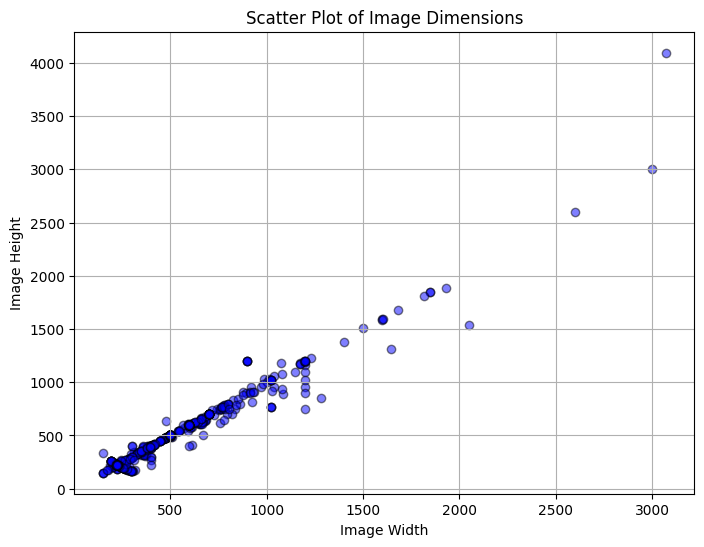

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the CSV file
df = pd.read_csv('image_data.csv')

# Scatter plot
plt.figure(figsize=(8, 6))
plt.scatter(df['width'], df['height'], alpha=0.5, c='blue', edgecolors='black')

# Labels and title
plt.xlabel('Image Width')
plt.ylabel('Image Height')
plt.title('Scatter Plot of Image Dimensions')
plt.grid(True)

# Show the plot
plt.show()

In [ ]:
median_width = df['width'].median()
median_height = df['height'].median()

print(f"Median Width: {median_width}")
print(f"Median Height: {median_height}")

Median Width: 384.0
Median Height: 384.0


In [ ]:
import pandas as pd

# Load the CSV file
df = pd.read_csv('image_data.csv')

# Count images where width = 224 and height = 224
count_224 = df[(df['width'] == 384) & (df['height'] == 384)].shape[0]

print(f"Number of images with width and height both as 224: {count_224}")

Number of images with width and height both as 224: 0
